In this approach we use Bag of decision trees.
**Features:**

Surrouding cells for a given cell.

**Data Augmentation**
* Background color is detected using custom logic.
* Custom logic is written to find the colors which need to be excempted from augmentation.
 * All the colors which are present in all the input of training exmaples are marked for excemption.
 * Color which is not present in input but present in output are excepted.
* For rest of colors all permutations are used to augment.

**Model** 

 Bag of decision trees are used since, single decision tree have some randomness factor which may give incorrect result.
 
 **Result**
 
 Training: Solved 41/400


In [0]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
from pathlib import Path
from collections import defaultdict
from itertools import product
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations,permutations
from sklearn.tree import *
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
import random
from math import floor


In [0]:
data_path = Path("/kaggle/input/abstraction-and-reasoning-challenge")
train_path = data_path/'training'
test_path = data_path/'test'

In [0]:
def plot_result(inp,eoup,oup):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 3, figsize=(15,15))
    
    axs[0].imshow(inp, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Input')

    axs[1].imshow(eoup, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Output')
    
    axs[2].imshow(oup, cmap=cmap, norm=norm)
    axs[2].axis('off')
    axs[2].set_title('Model prediction')
    
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_mats(mats):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, len(mats), figsize=(15,15))
    
    for i in range(len(mats)):
        axs[i].imshow(mats[i], cmap=cmap, norm=norm)
        axs[i].axis('off')
        axs[i].set_title('Fig: '+str(i))
    
    plt.rc('grid', linestyle="-", color='white')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [0]:
def getiorc(pair):
    inp = pair["input"]
    return pair["input"],pair["output"],len(inp),len(inp[0])
    
def getAround(i,j,inp,size=1):
    #v = [-1,-1,-1,-1,-1,-1,-1,-1,-1]
    r,c = len(inp),len(inp[0])
    v = []
    sc = [0]
    for q in range(size):
        sc.append(q+1)
        sc.append(-(q+1))
    for idx,(x,y) in enumerate(product(sc,sc)):
        ii = (i+x)
        jj = (j+y)
        v.append(-1)
        if((0<= ii < r) and (0<= jj < c)):
            v[idx] = (inp[ii][jj])
    return v

def getDiagonal(i,j,r,c):
    return
        
    
def getX(inp,i,j,size):
    z = []
    n_inp = np.array(inp)
    z.append(i)
    z.append(j)
    r,c = len(inp),len(inp[0])
    for m in range(5):
        z.append(i%(m+1))
        z.append(j%(m+1))
    z.append(i+j)
    z.append(i*j)
#     z.append(i%j)
#     z.append(j%i)
    z.append((i+1)/(j+1))
    z.append((j+1)/(i+1))
    z.append(r)
    z.append(c)
    z.append(len(np.unique(n_inp[i,:])))
    z.append(len(np.unique(n_inp[:,j])))
    arnd = getAround(i,j,inp,size)
    z.append(len(np.unique(arnd)))
    z.extend(arnd)
    return z

def getXy(inp,oup,size):
    x = []
    y = []
    r,c = len(inp),len(inp[0])
    for i in range(r):
        for j in range(c):
            x.append(getX(inp,i,j,size))
            y.append(oup[i][j])
    return x,y
    
def getBkgColor(task_json):
    color_dict = defaultdict(int)
    
    for pair in task_json['train']:
        inp,oup,r,c = getiorc(pair)
        for i in range(r):
            for j in range(c):
                color_dict[inp[i][j]]+=1
    color = -1
    max_count = 0
    for col,cnt in color_dict.items():
        if(cnt > max_count):
            color = col
            max_count = cnt
    return color

In [0]:
def get_num_colors(inp,oup,bl_cols):
    r,c = len(inp),len(inp[0])
    return 

def replace(inp,uni,perm):
    # uni = '234' perm = ['5','7','9']
    #print(uni,perm)
    r_map = { int(c):int(s) for c,s in zip(uni,perm)}
    r,c = len(inp),len(inp[0])
    rp = np.array(inp).tolist()
    #print(rp)
    for i in range(r):
        for j in range(c):
            if(rp[i][j] in r_map):
                rp[i][j] = r_map[rp[i][j]]
    return rp
            
    
def augment(inp,oup,bl_cols):
    cols = "0123456789"
    npr_map = [1,9,72,3024,15120,60480,181440,362880,362880]
    uni = "".join([str(x) for x in np.unique(inp).tolist()])
    for c in bl_cols:
        cols=cols.replace(str(c),"")
        uni=uni.replace(str(c),"")

    exp_size = len(inp)*len(inp[0])*npr_map[len(uni)]
    
    mod = floor(exp_size/120000)
    mod = 1 if mod==0 else mod
    
    #print(exp_size,mod,len(uni))
    result = []
    count = 0
    for comb in combinations(cols,len(uni)):
        for perm in permutations(comb):
            count+=1
            if(count % mod == 0):
                result.append((replace(inp,uni,perm),replace(oup,uni,perm)))
    return result
            
def get_flips(inp,oup):
    result = []
    n_inp = np.array(inp)
    n_oup = np.array(oup)
    result.append((np.fliplr(inp).tolist(),np.fliplr(oup).tolist()))
    result.append((np.rot90(np.fliplr(inp),1).tolist(),np.rot90(np.fliplr(oup),1).tolist()))
    result.append((np.rot90(np.fliplr(inp),2).tolist(),np.rot90(np.fliplr(oup),2).tolist()))
    result.append((np.rot90(np.fliplr(inp),3).tolist(),np.rot90(np.fliplr(oup),3).tolist()))
    result.append((np.flipud(inp).tolist(),np.flipud(oup).tolist()))
    result.append((np.rot90(np.flipud(inp),1).tolist(),np.rot90(np.flipud(oup),1).tolist()))
    result.append((np.rot90(np.flipud(inp),2).tolist(),np.rot90(np.flipud(oup),2).tolist()))
    result.append((np.rot90(np.flipud(inp),3).tolist(),np.rot90(np.flipud(oup),3).tolist()))
    result.append((np.fliplr(np.flipud(inp)).tolist(),np.fliplr(np.flipud(oup)).tolist()))
    result.append((np.flipud(np.fliplr(inp)).tolist(),np.flipud(np.fliplr(oup)).tolist()))
    return result
    
def gettaskxy(task_json,aug,around_size,bl_cols,flip=True):    
    X = []
    Y = []
    for pair in task_json['train']:
        inp,oup=pair["input"],pair["output"]
        tx,ty = getXy(inp,oup,around_size)
        X.extend(tx)
        Y.extend(ty)
        if(flip):
            for ainp,aoup in get_flips(inp,oup):
                tx,ty = getXy(ainp,aoup,around_size)
                X.extend(tx)
                Y.extend(ty)
                if(aug):
                    augs = augment(ainp,aoup,bl_cols)
                    for ainp,aoup in augs:
                        tx,ty = getXy(ainp,aoup,around_size)
                        X.extend(tx)
                        Y.extend(ty)
        if(aug):
            augs = augment(inp,oup,bl_cols)
            for ainp,aoup in augs:
                tx,ty = getXy(ainp,aoup,around_size)
                X.extend(tx)
                Y.extend(ty)
    return X,Y

def test_predict(task_json,model,size):
    inp = task_json['test'][0]['input']
    eoup = task_json['test'][0]['output']
    r,c = len(inp),len(inp[0])
    oup = predict(inp,model,size)
    return inp,eoup,oup

def predict(inp,model,size):
    r,c = len(inp),len(inp[0])
    oup = np.zeros([r,c],dtype=int)
    for i in range(r):
        for j in range(c):
            x = getX(inp,i,j,size)
            o = int(model.predict([x]))
            o = 0 if o<0 else o
            oup[i][j]=o
    return oup

def submit_predict(task_json,model,size):
    pred_map = {}
    idx=0
    for pair in task_json['test']:
        inp = pair["input"]
        oup = predict(inp,model,size)
        pred_map[idx] = oup.tolist()
        idx+=1
        plot_result(inp,oup,oup)
    return pred_map

def dumb_predict(task_json):
    pred_map = {}
    idx=0
    for pair in task_json['test']:
        inp = pair["input"]
        pred_map[idx] = [[0,0],[0,0]]
        idx+=1
    return pred_map
    

In [0]:
def get_loss(model,task_json,size):
    total = 0
    for pair in task_json['train']:
        inp,oup=pair["input"],pair["output"]
        eoup = predict(inp,model,size)
        total+= np.sum((np.array(oup) != np.array(eoup)))
    return total

def get_test_loss(model,task_json,size):
    total = 0
    for pair in task_json['test']:
        inp,oup=pair["input"],pair["output"]
        eoup = predict(inp,model,size)
        total+= np.sum((np.array(oup) != np.array(eoup)))
    return total

def get_a_size(task_json):
    return 4;

def get_bl_cols(task_json):
    result = []
    bkg_col = getBkgColor(task_json);
    result.append(bkg_col)
    # num_input,input_cnt,num_output,output_cnt
    met_map = {}
    for i in range(10):
        met_map[i] = [0,0,0,0]
        
    total_ex = 0
    for pair in task_json['train']:
        inp,oup=pair["input"],pair["output"]
        u,uc = np.unique(inp, return_counts=True)
        inp_cnt_map = dict(zip(u,uc))
        u,uc = np.unique(oup, return_counts=True)
        oup_cnt_map = dict(zip(u,uc))
        
        for col,cnt in inp_cnt_map.items():
            met_map[col][0] = met_map[col][0] + 1
            met_map[col][1] = met_map[col][1] + cnt
        for col,cnt in oup_cnt_map.items():
            met_map[col][2] = met_map[col][2] + 1
            met_map[col][3] = met_map[col][3] + cnt
        total_ex+=1
    
    for col,met in met_map.items():
        num_input,input_cnt,num_output,output_cnt = met
        if(num_input == total_ex or num_output == total_ex):
            result.append(col)
        elif(num_input == 0 and num_output > 0):
            result.append(col)
    
    result = np.unique(result).tolist()
    if(len(result) == 10):
        result.append(bkg_col)
    return np.unique(result).tolist()


In [0]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def combine_preds(tid,pm1,pm3,pm5):
    result = []
    for i in range(len(pm1)):
        tk_s = tid+"_"+str(i)
        str_pred = flattener(pm1[i])+" "+flattener(pm3[i])+" "+flattener(pm5[i])
        #print(tk_s,str_pred)
        result.append([tk_s,str_pred])
    return result
        

34b99a2b
3d31c5b3
0692e18c
20818e16
332efdb3


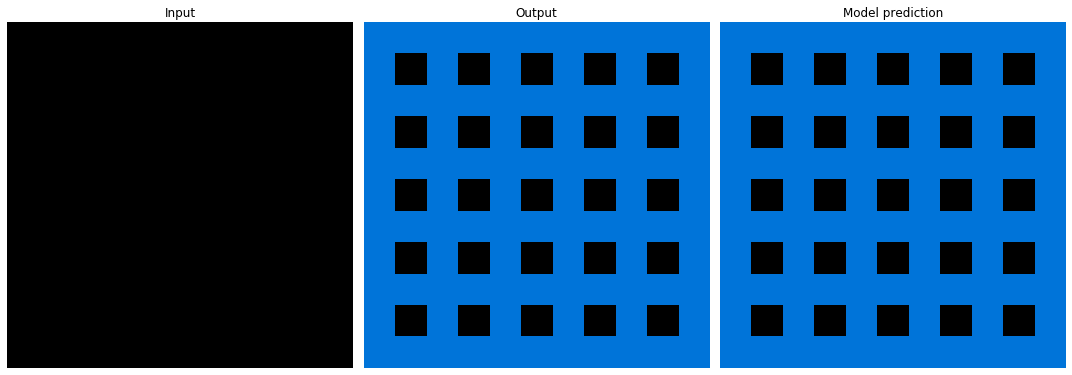

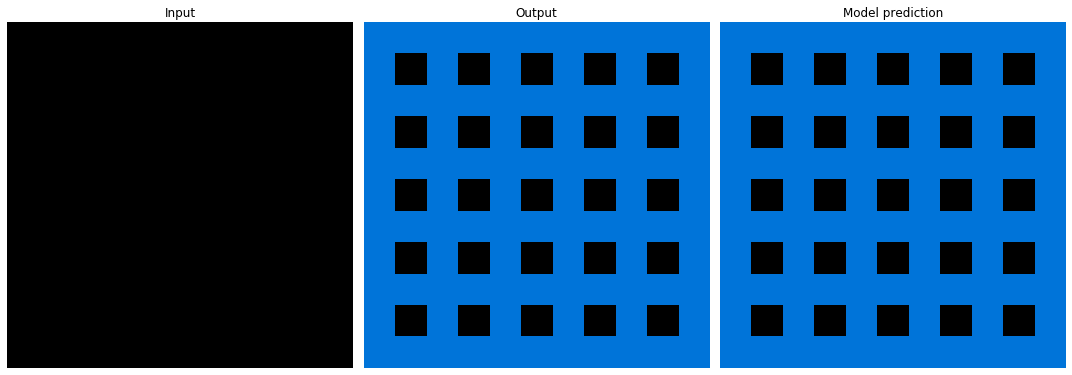

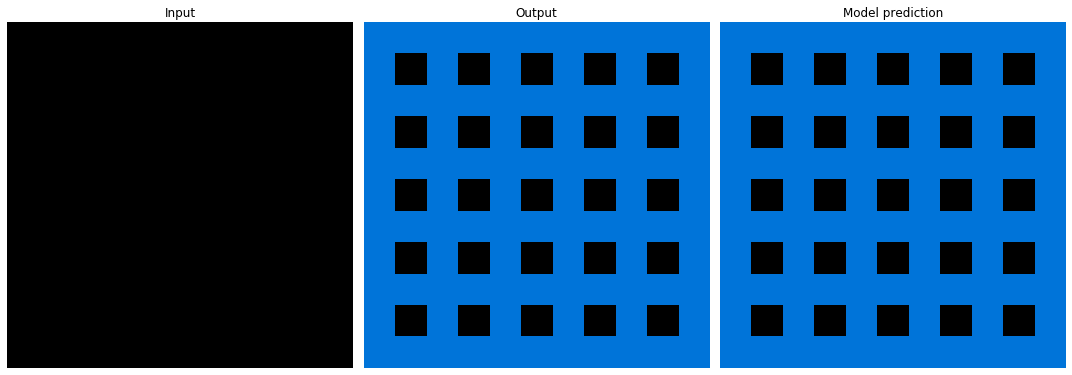

423a55dc


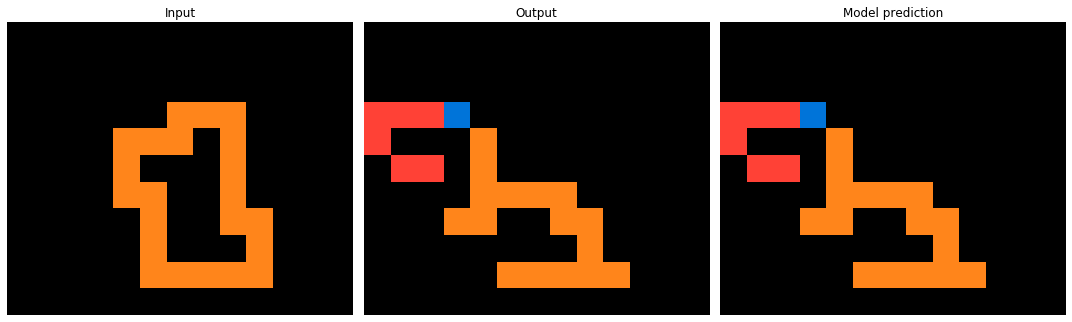

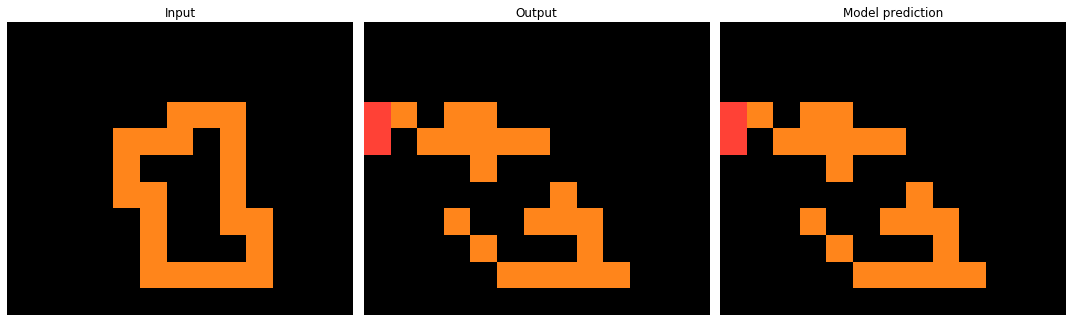

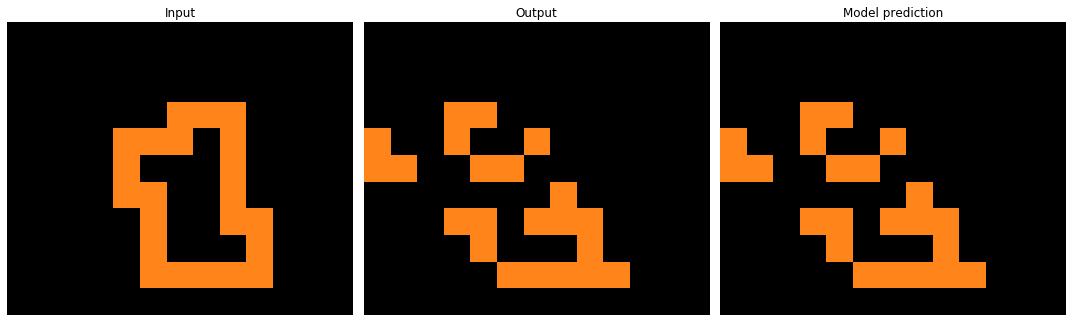

1e81d6f9


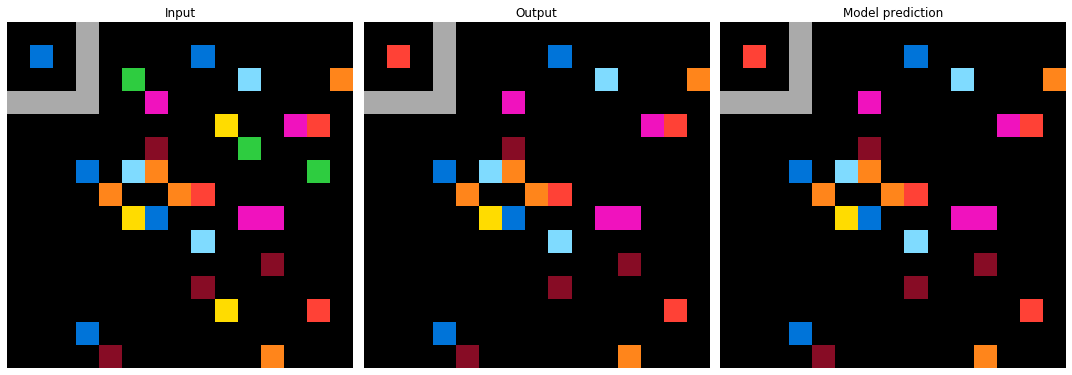

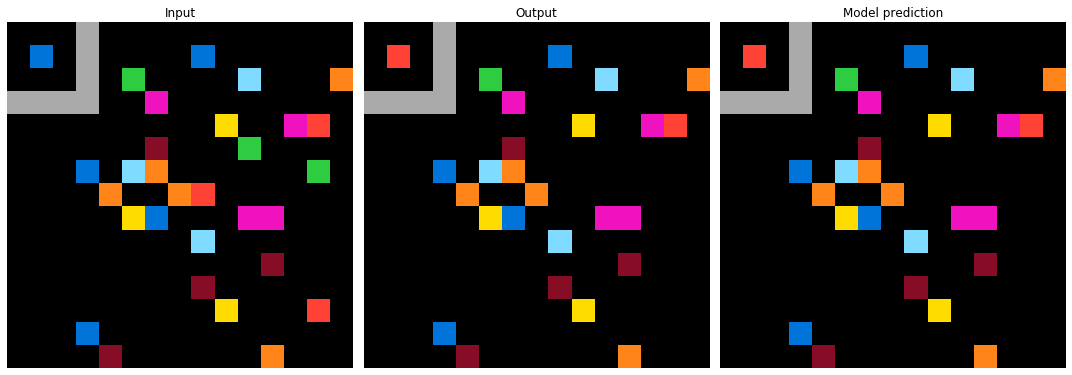

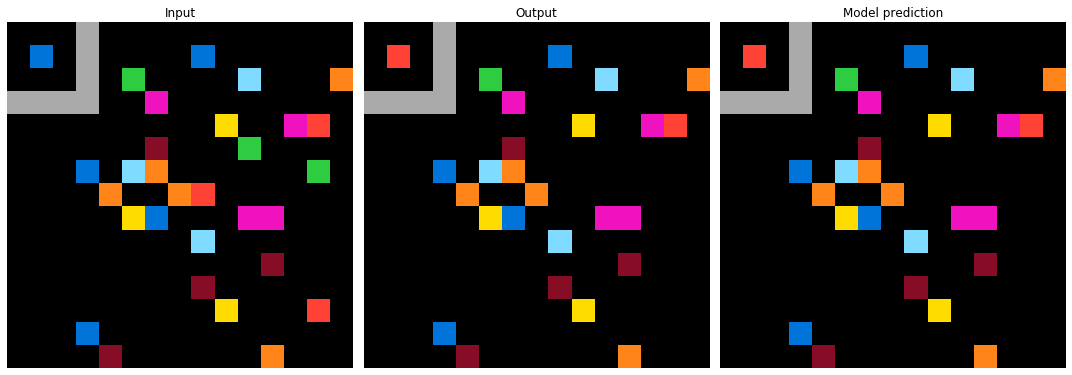

212895b5


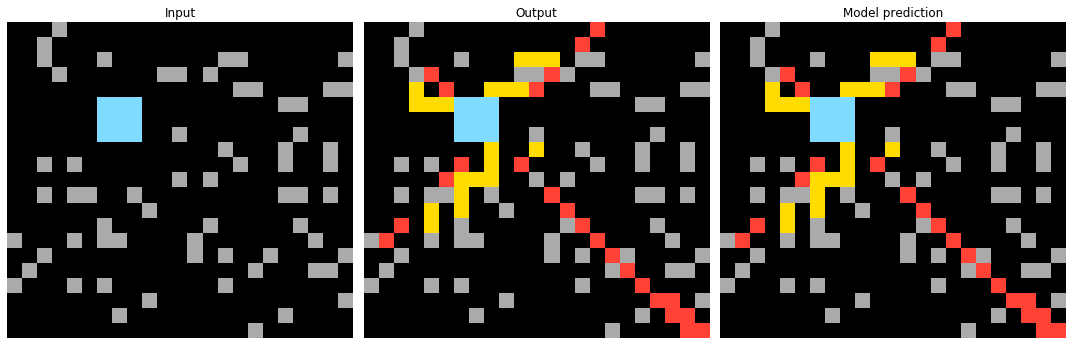

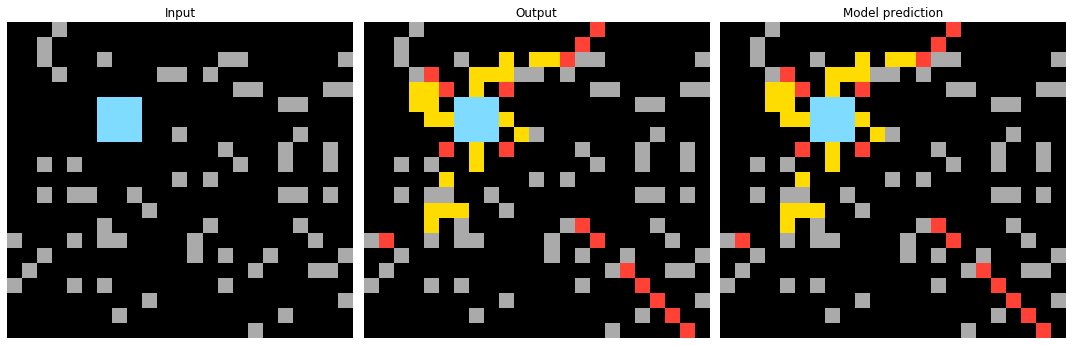

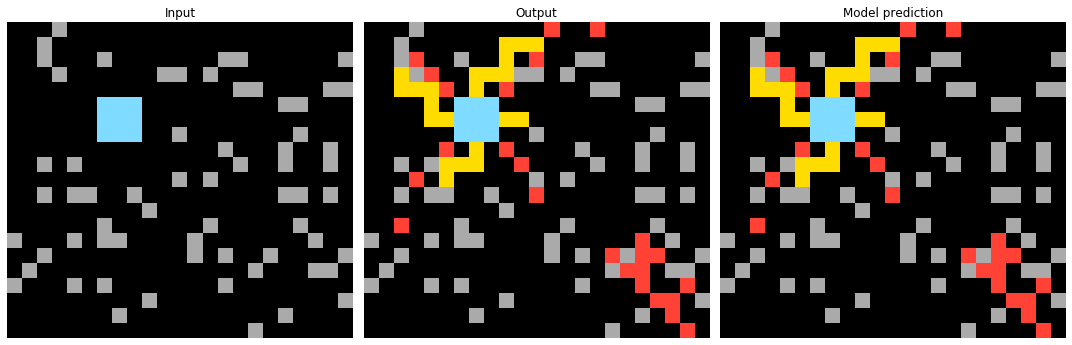

2037f2c7
3b4c2228
3ed85e70


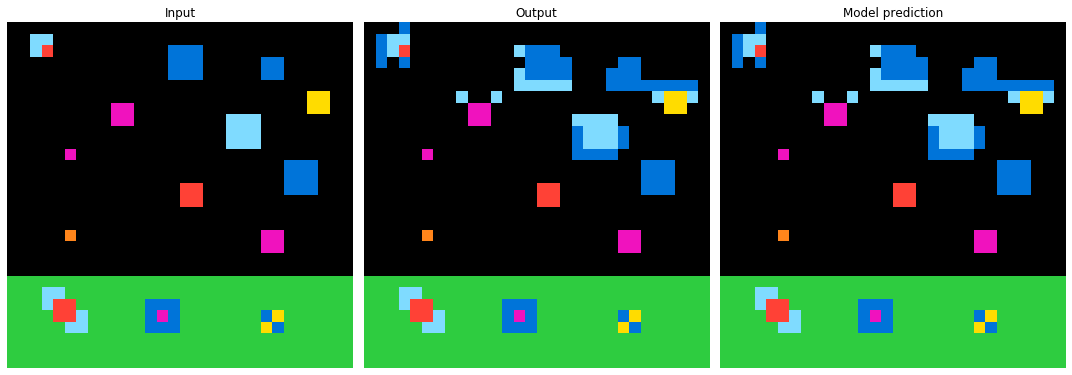

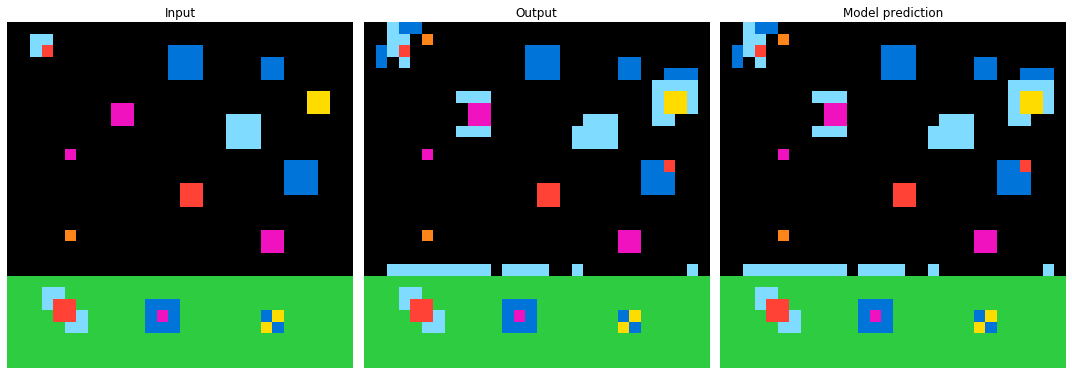

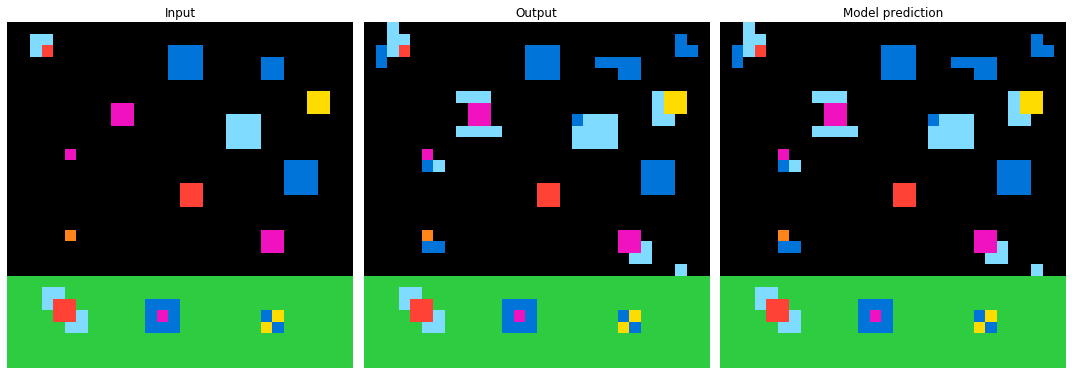

33b52de3


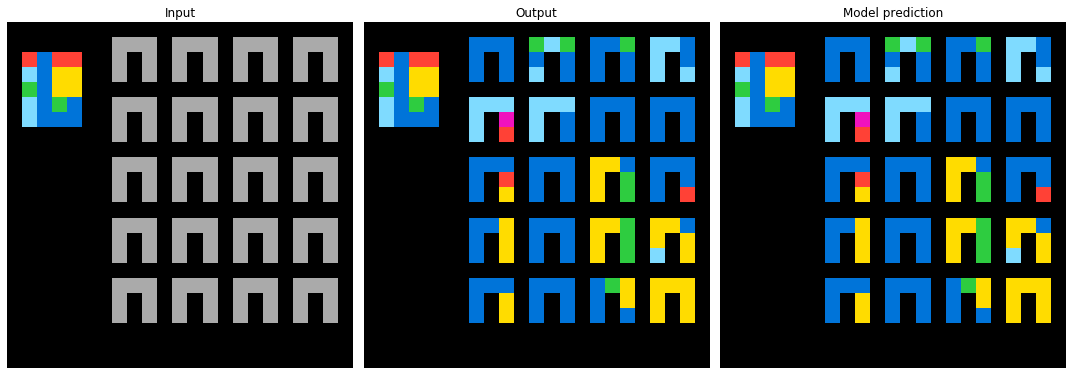

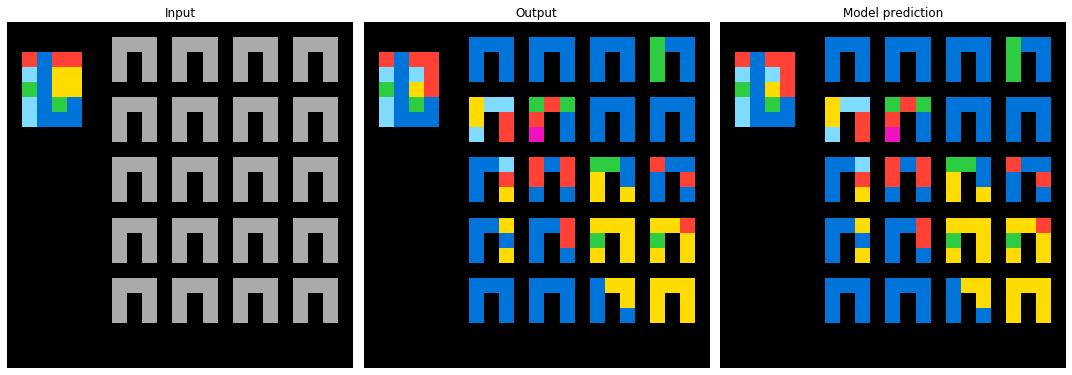

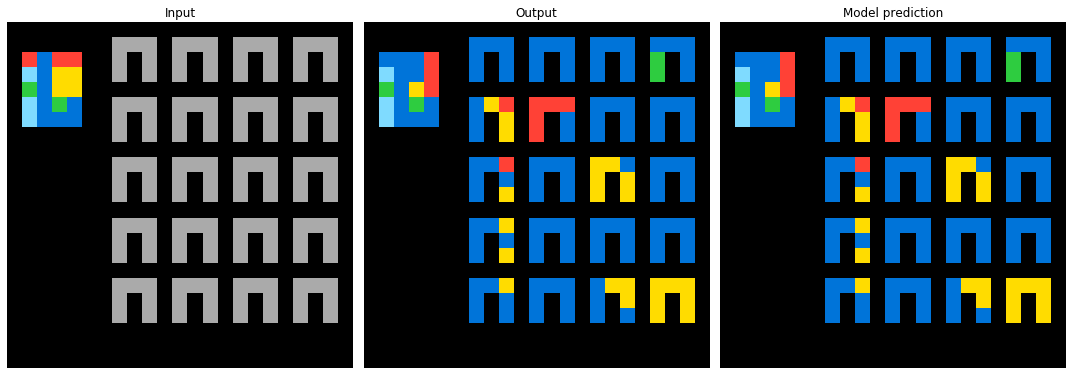

1a2e2828
0a2355a6


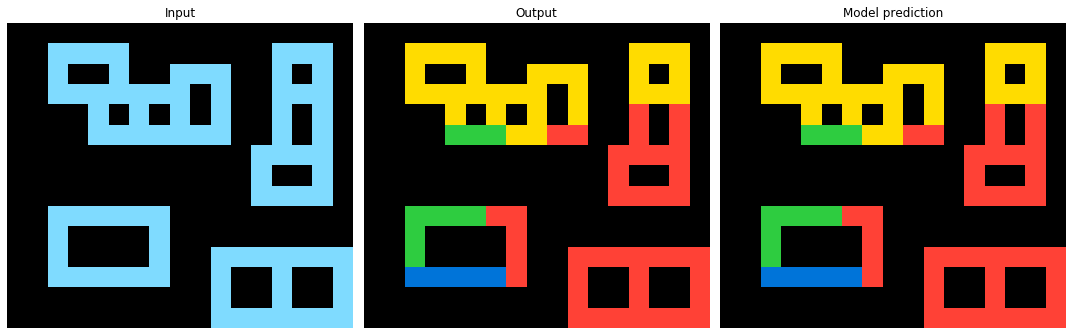

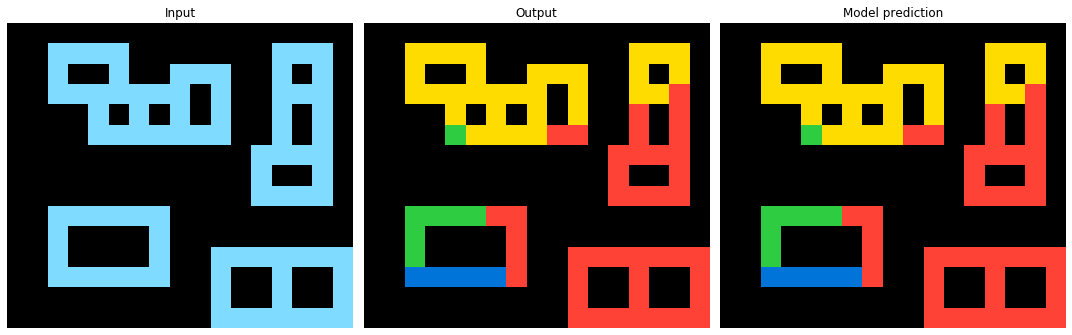

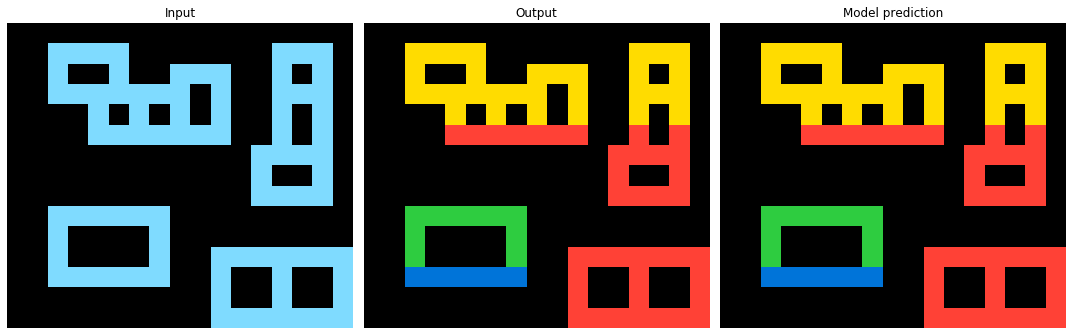

0b17323b


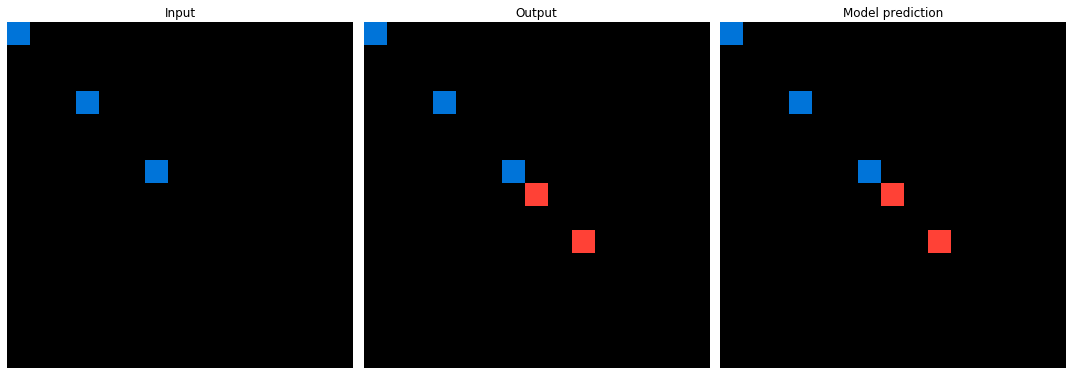

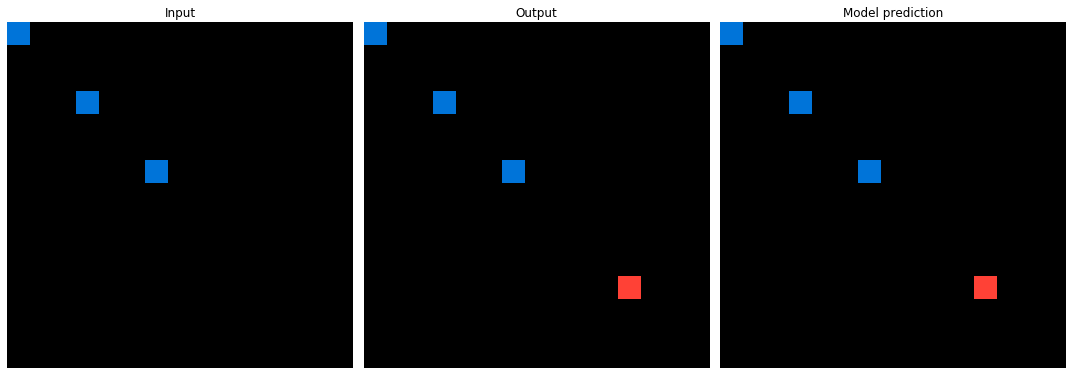

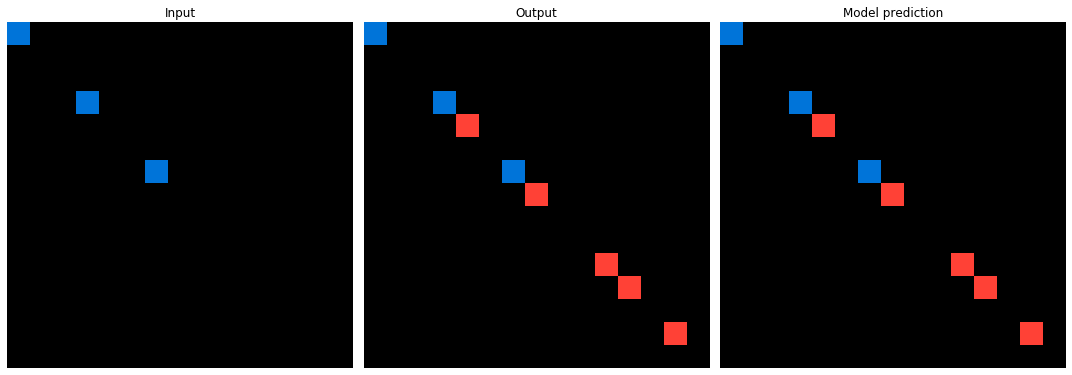

11e1fe23


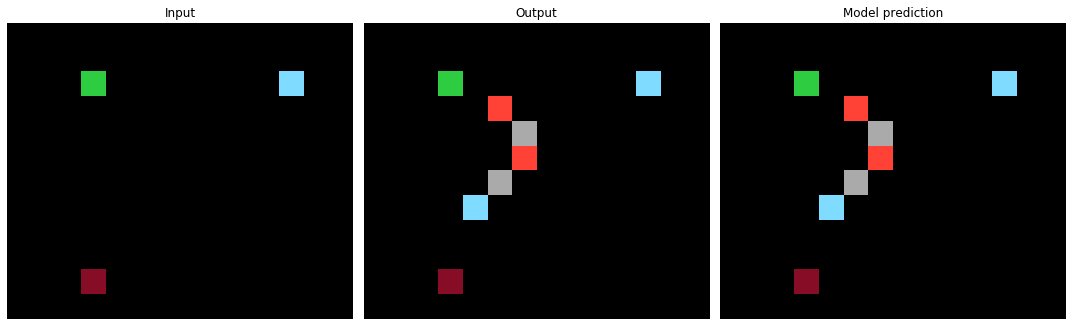

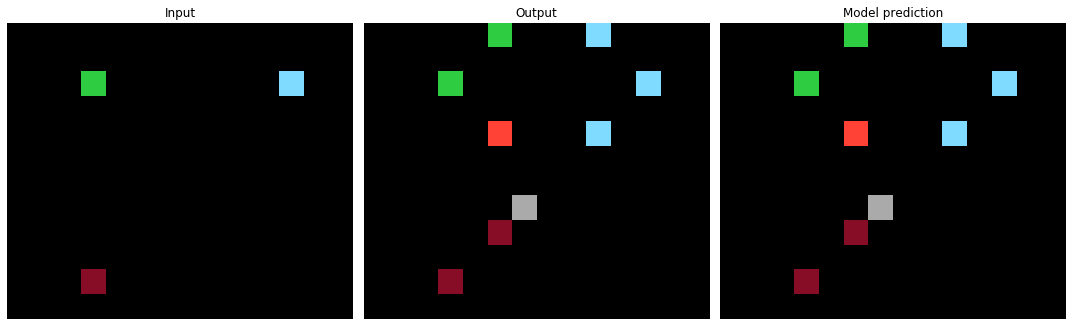

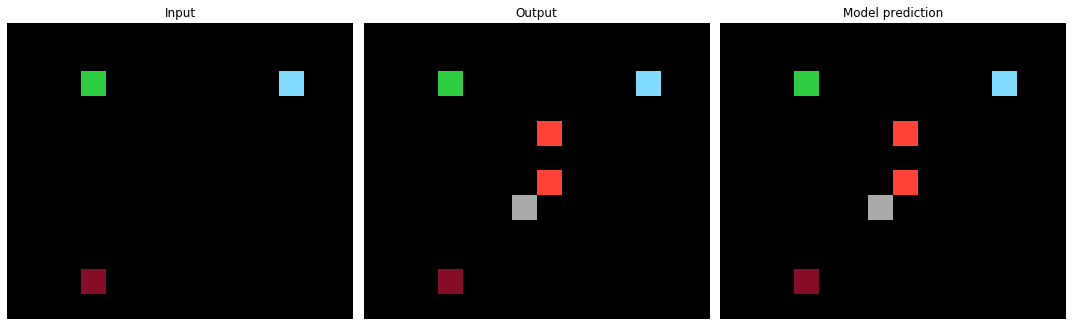

2685904e


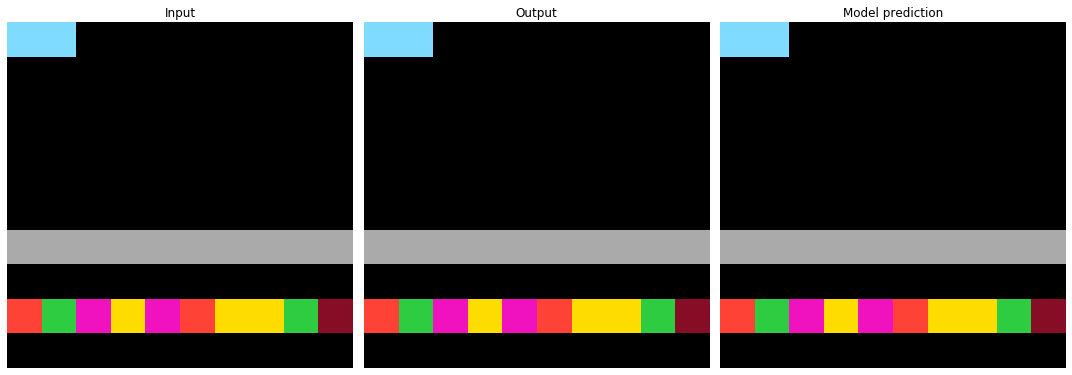

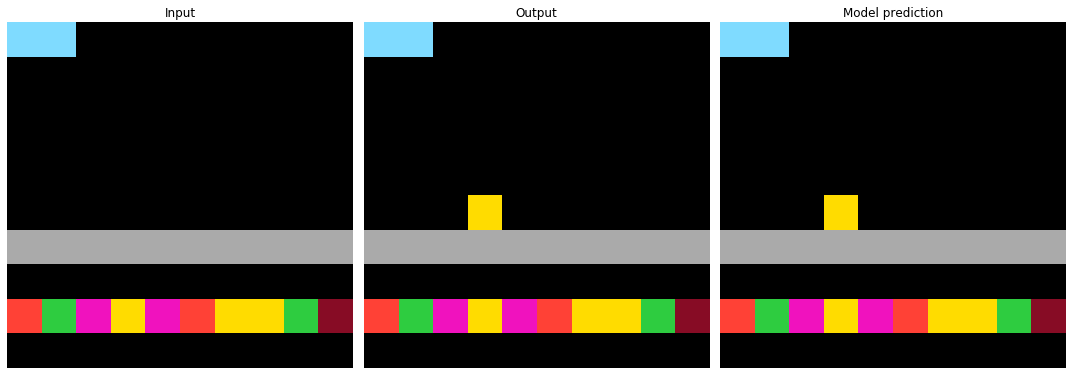

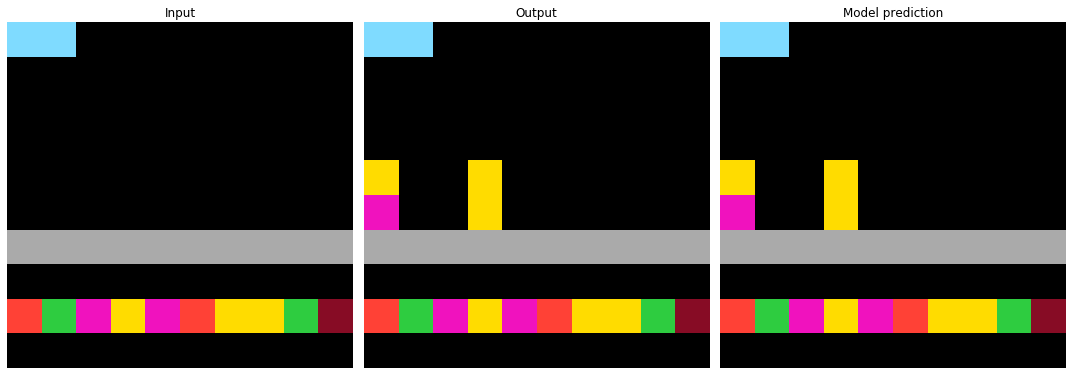

009d5c81


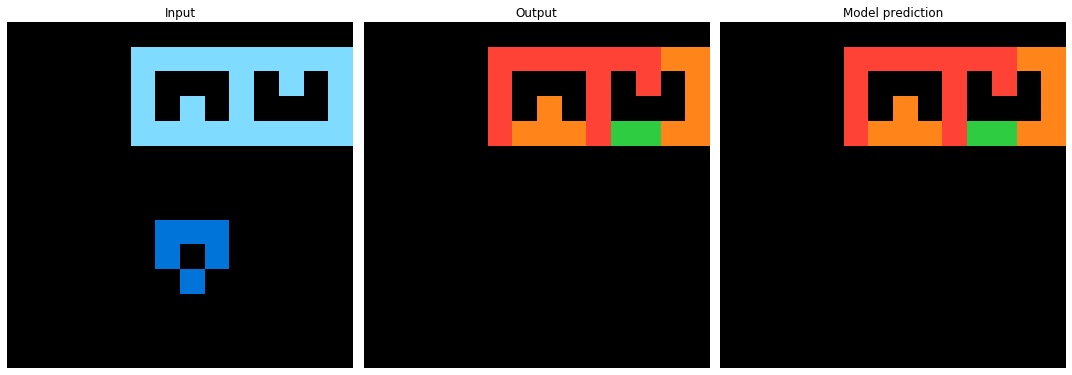

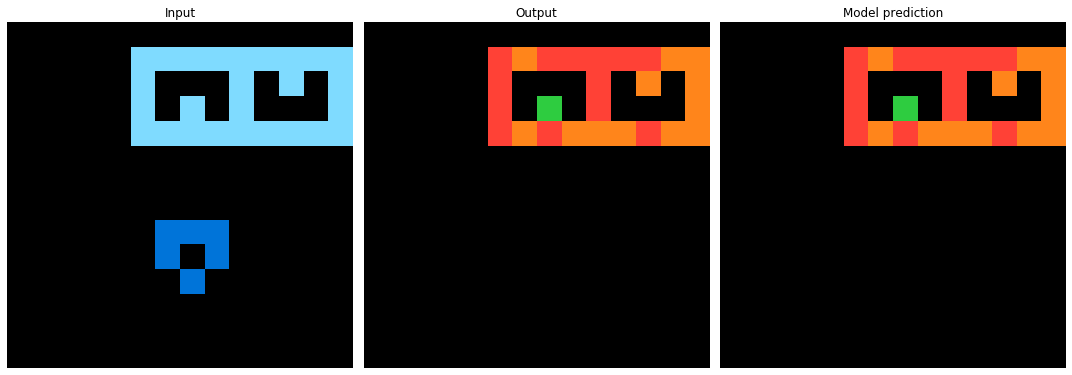

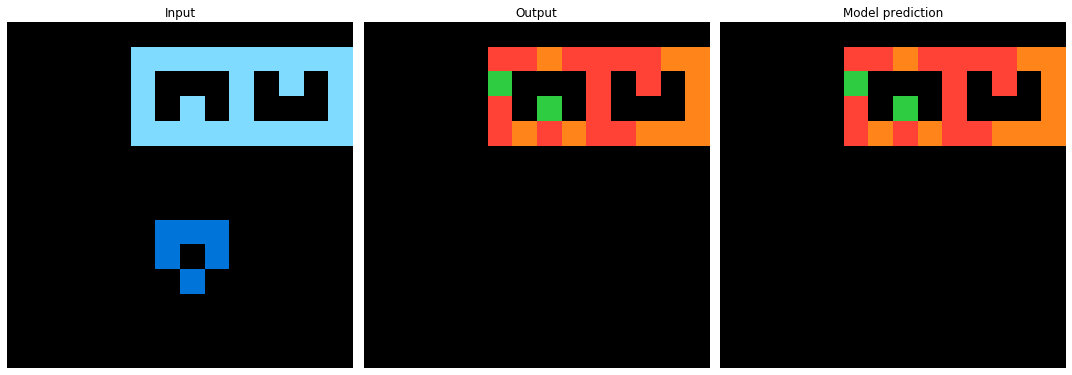

136b0064
05a7bcf2


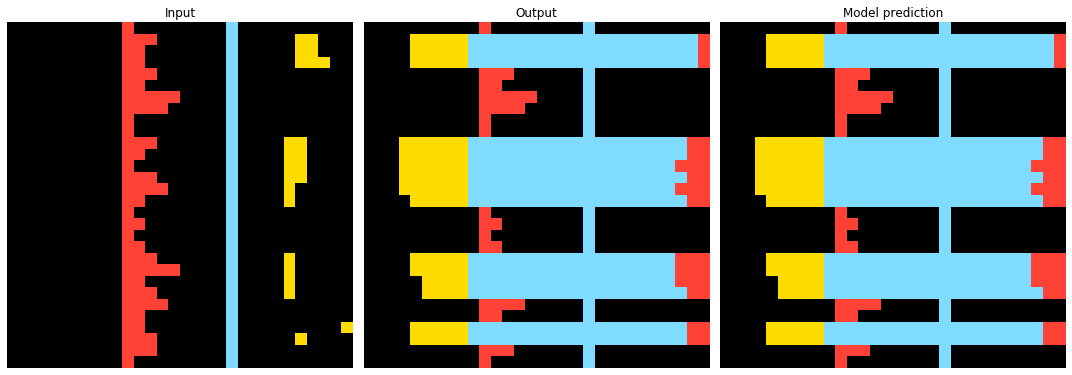

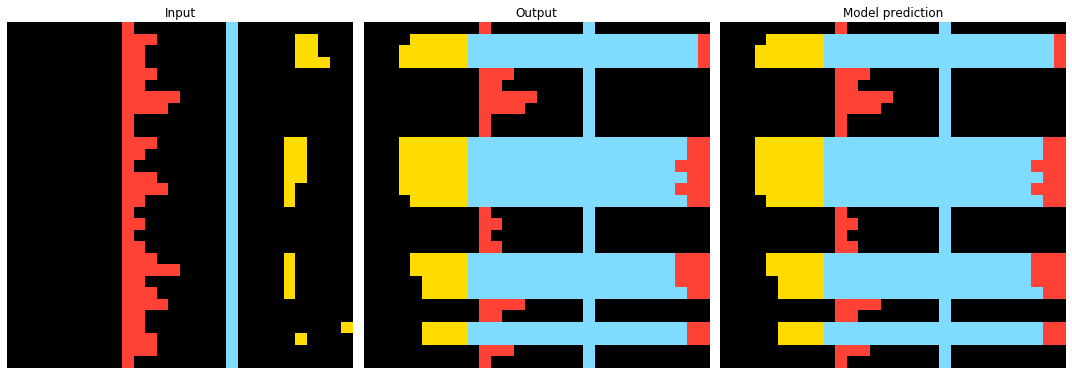

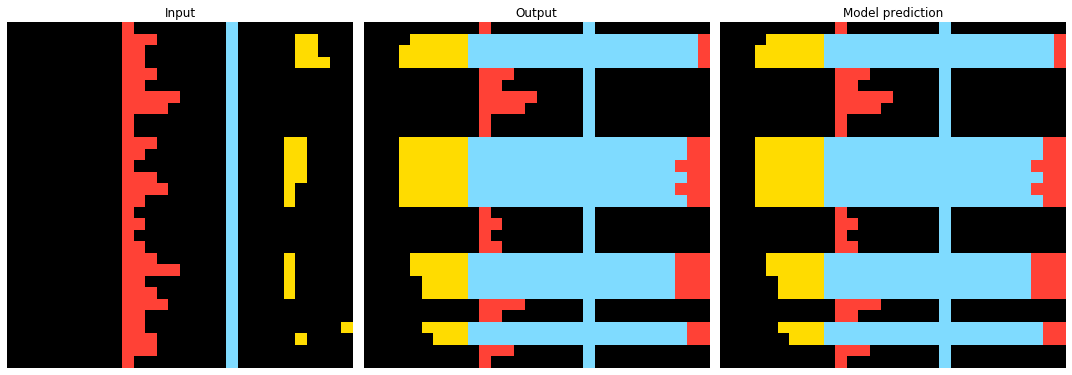

0e671a1a


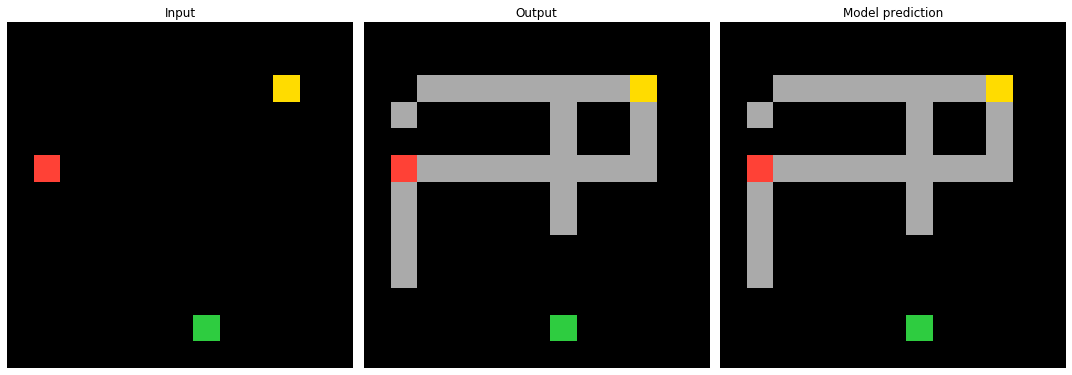

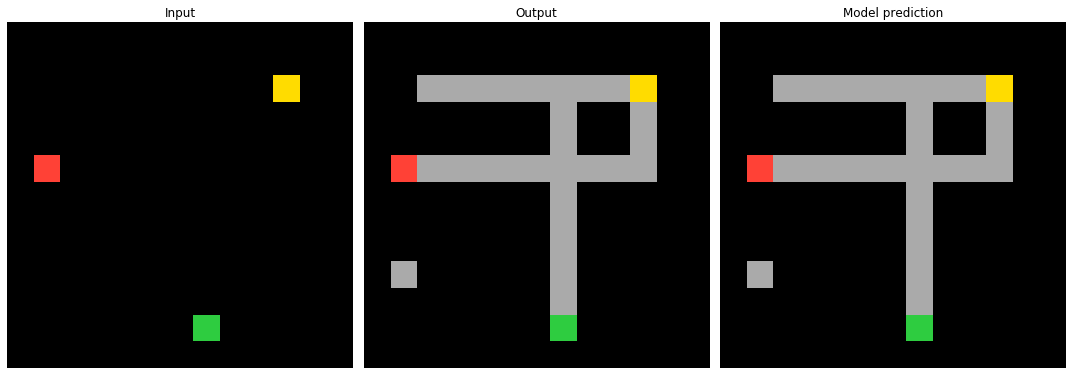

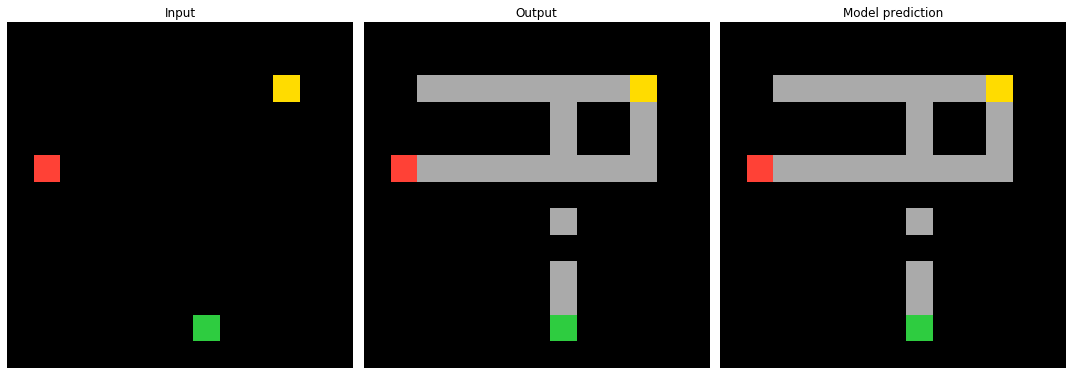

19bb5feb
195ba7dc
1c56ad9f


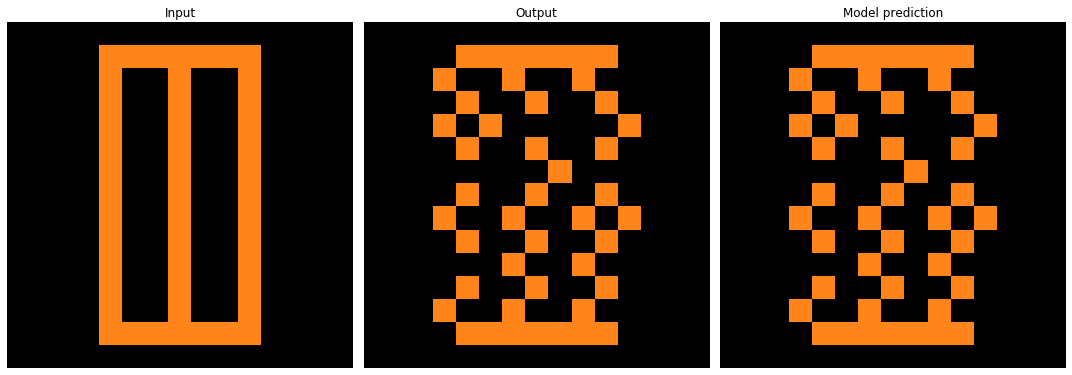

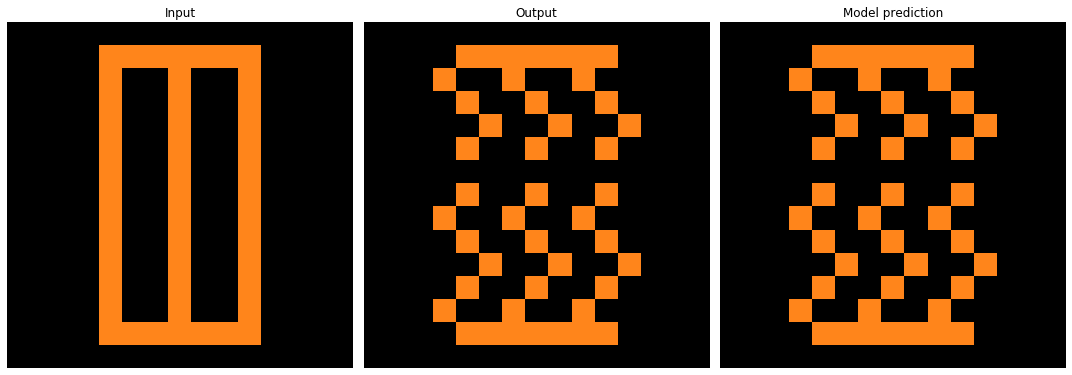

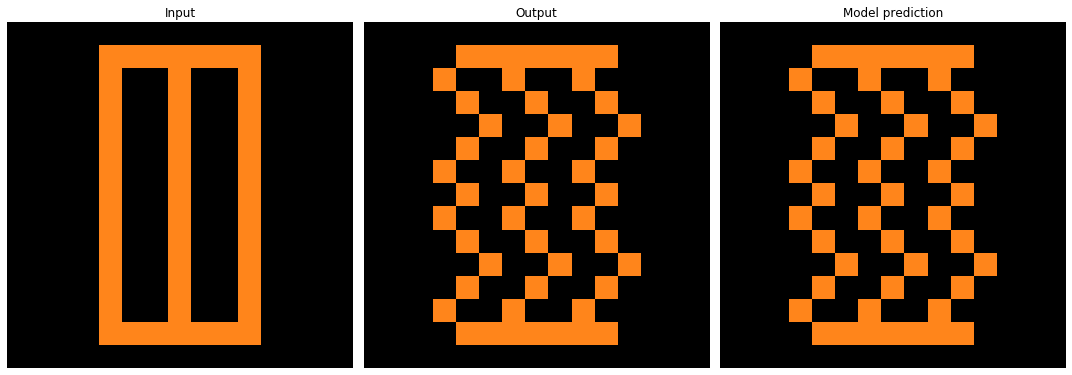

0607ce86


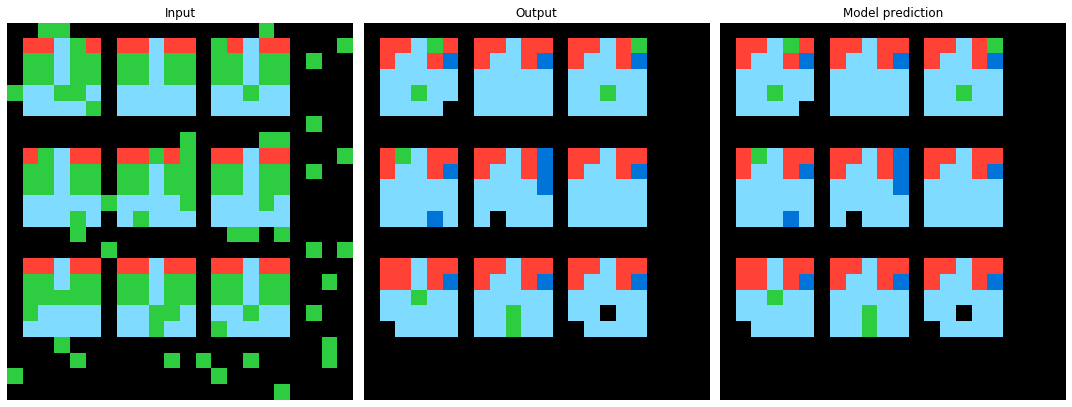

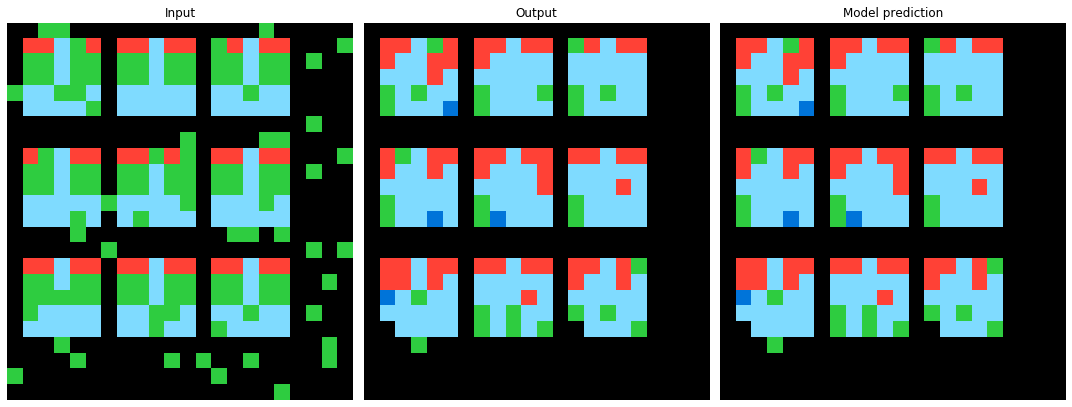

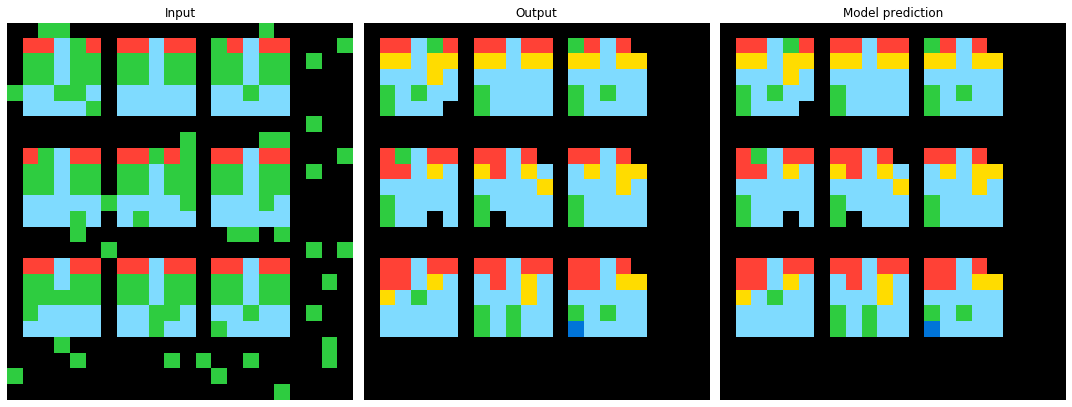

2c737e39


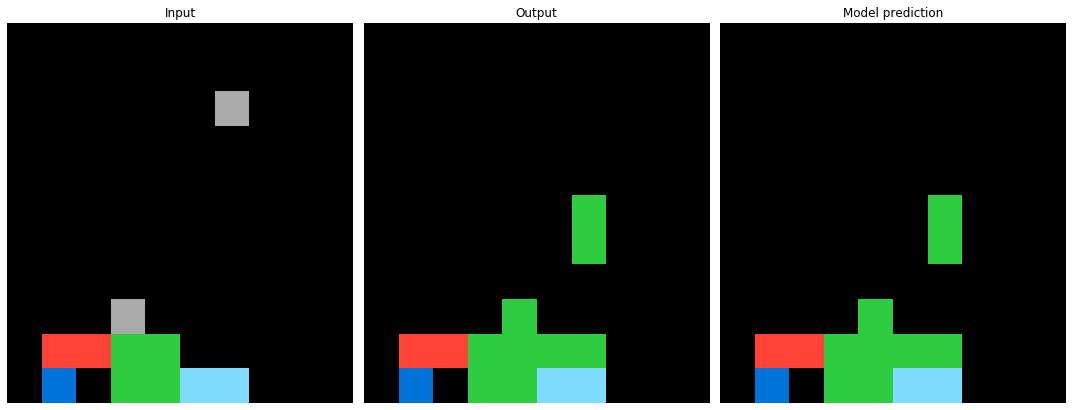

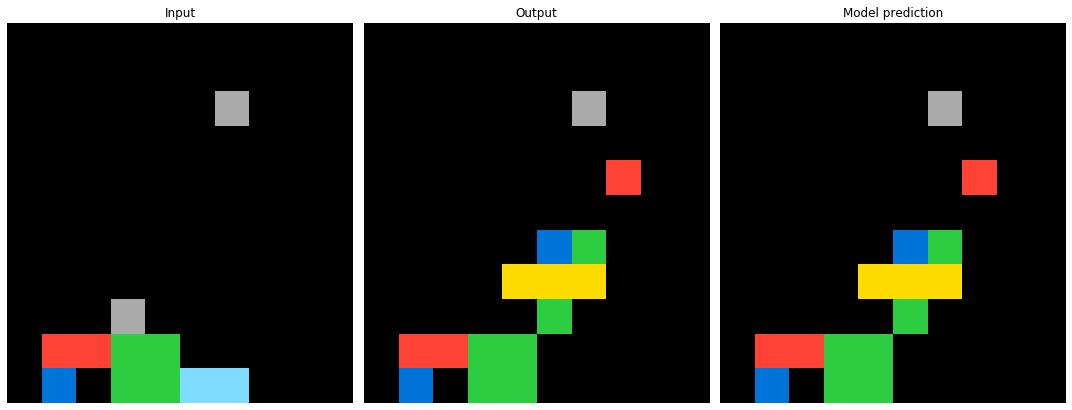

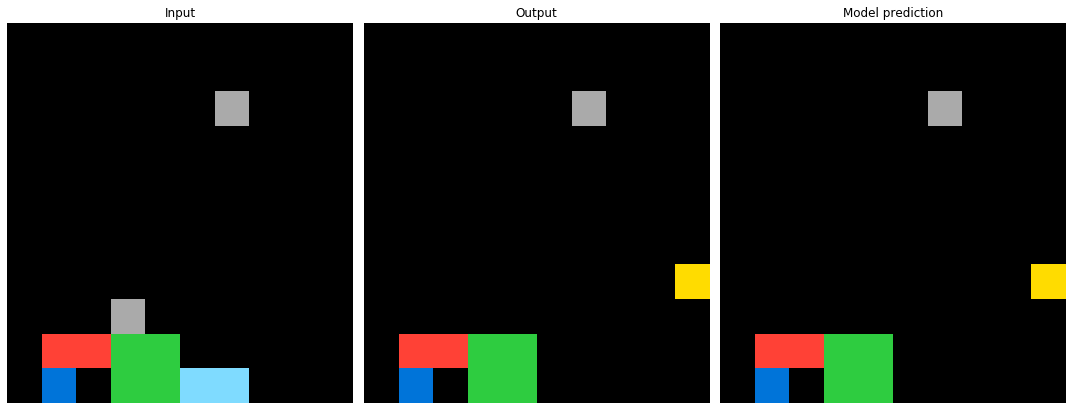

31adaf00


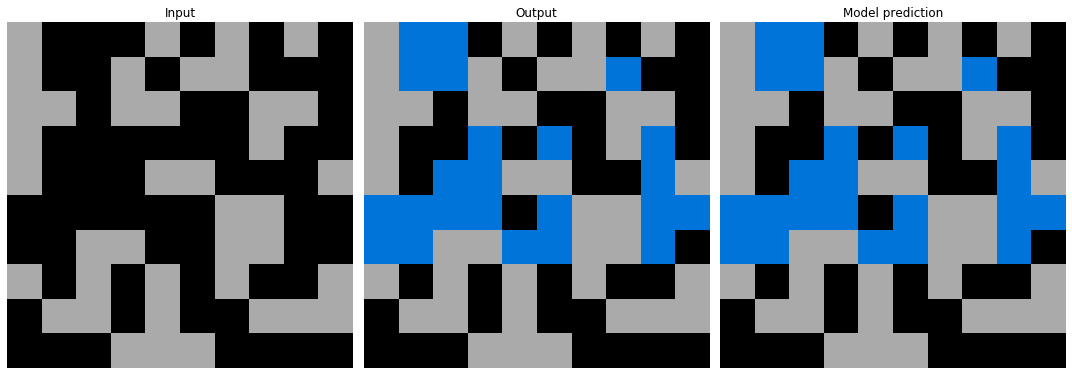

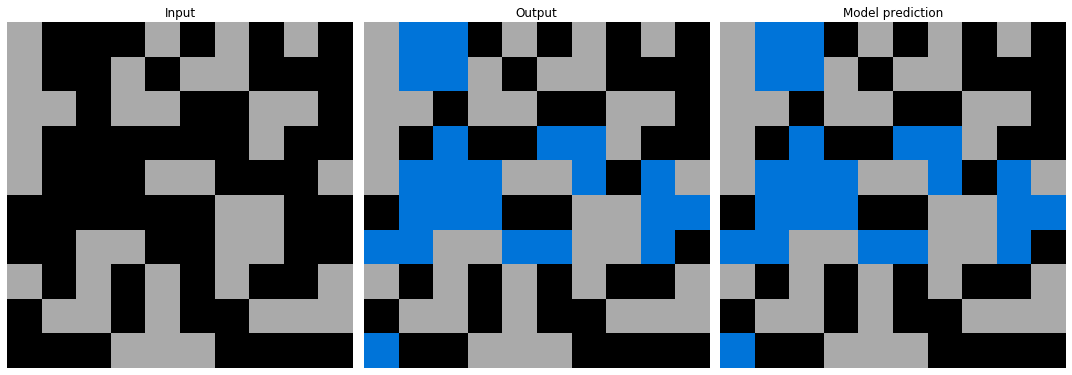

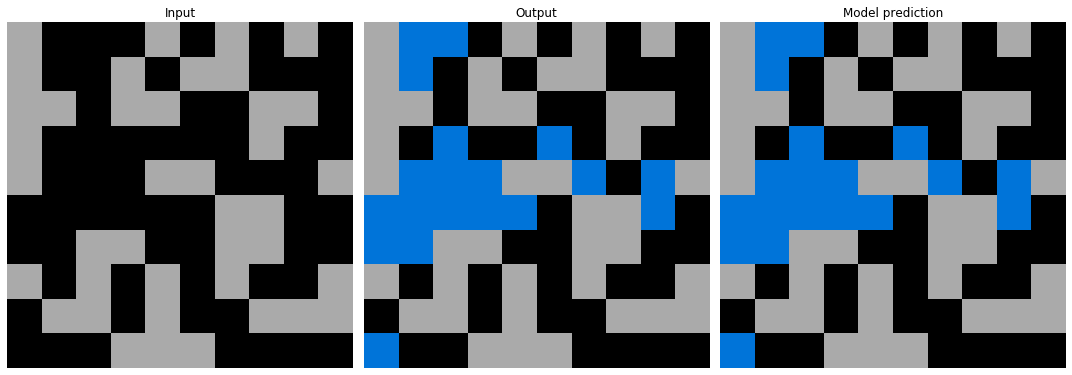

15696249
1a6449f1
3a301edc


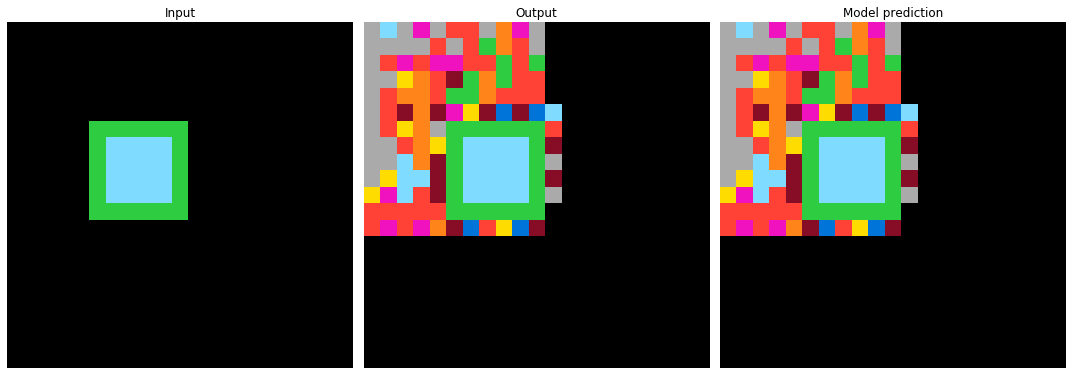

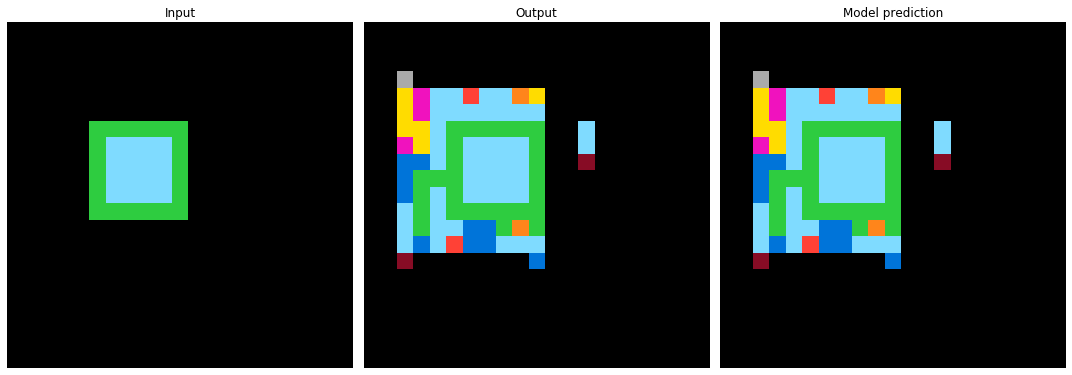

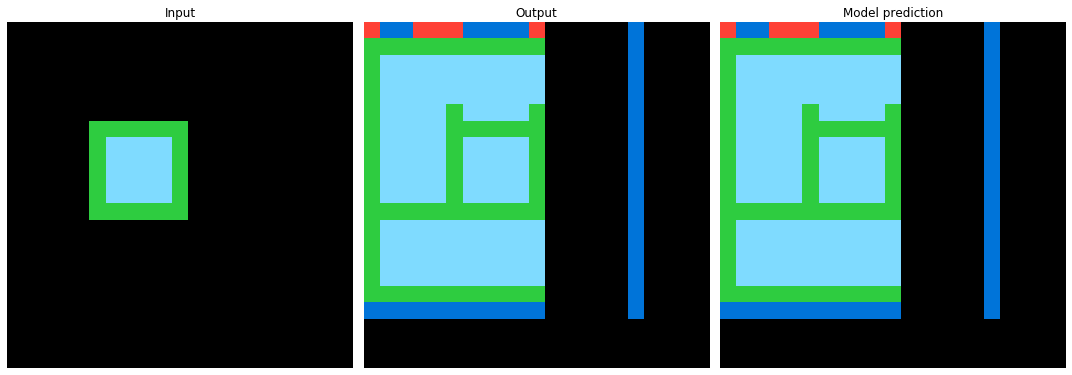

414297c0
37d3e8b2


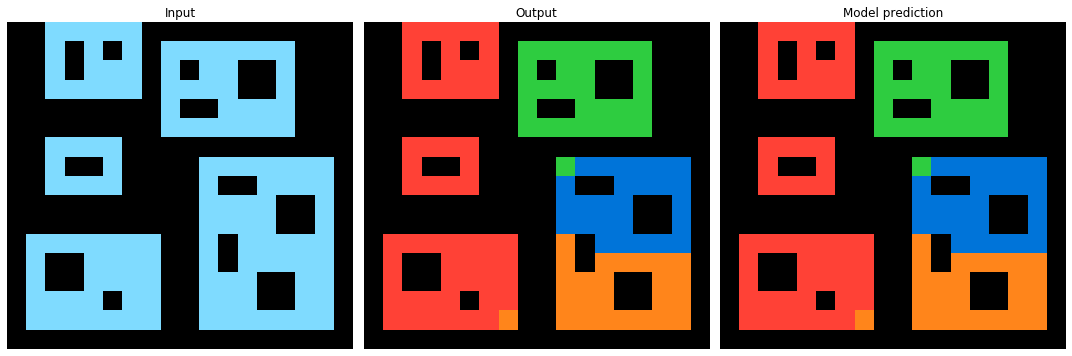

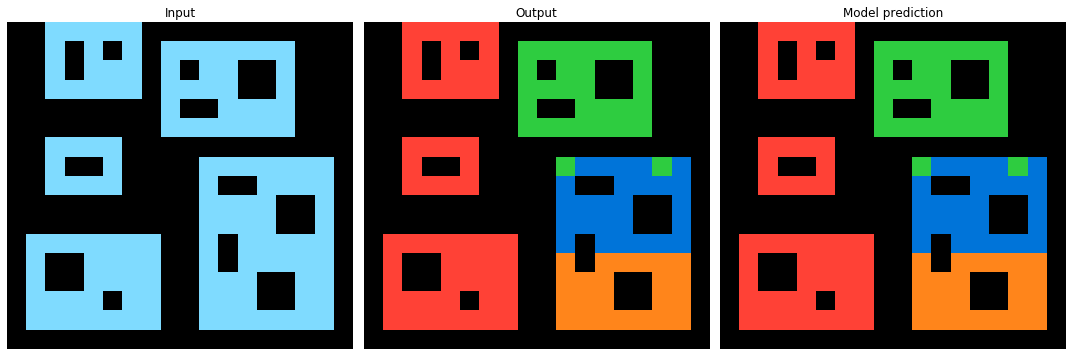

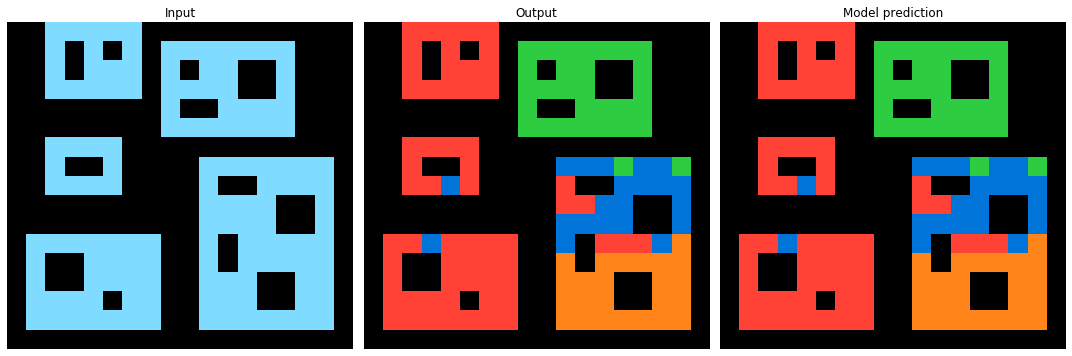

13713586


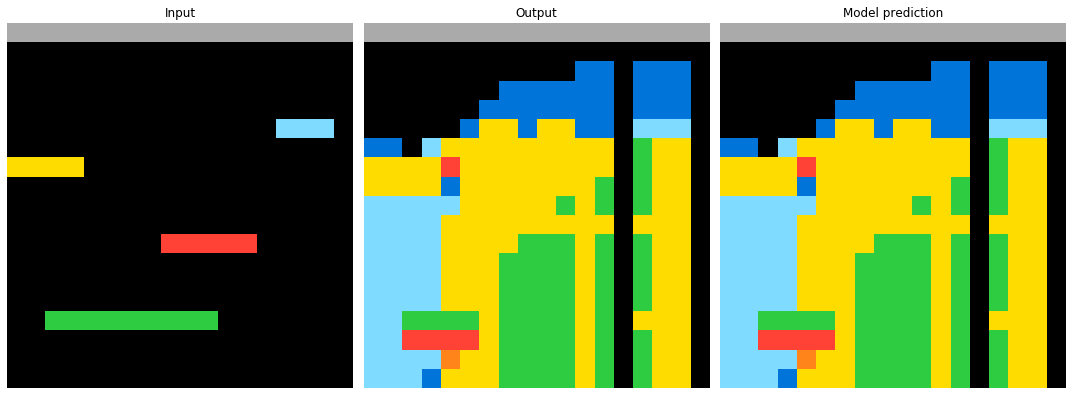

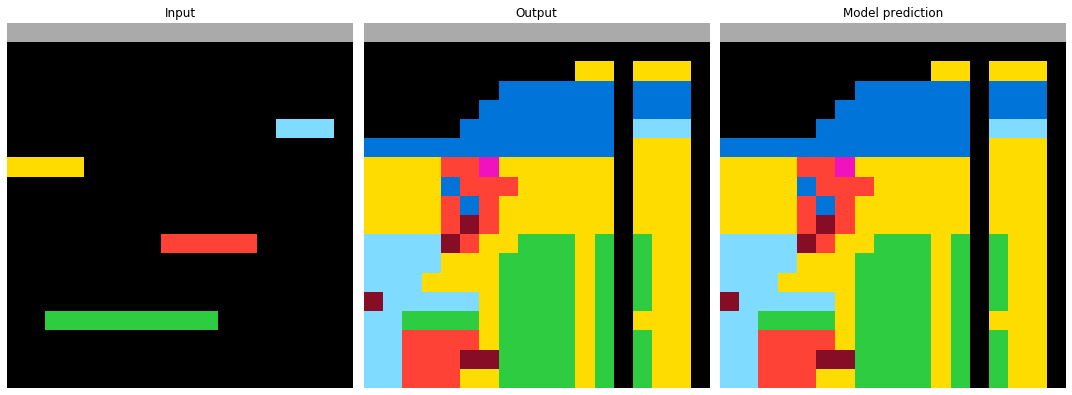

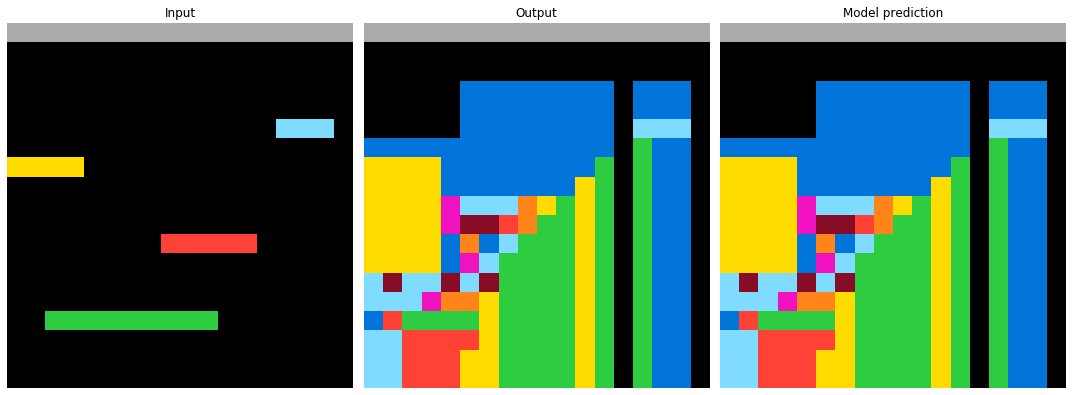

08573cc6


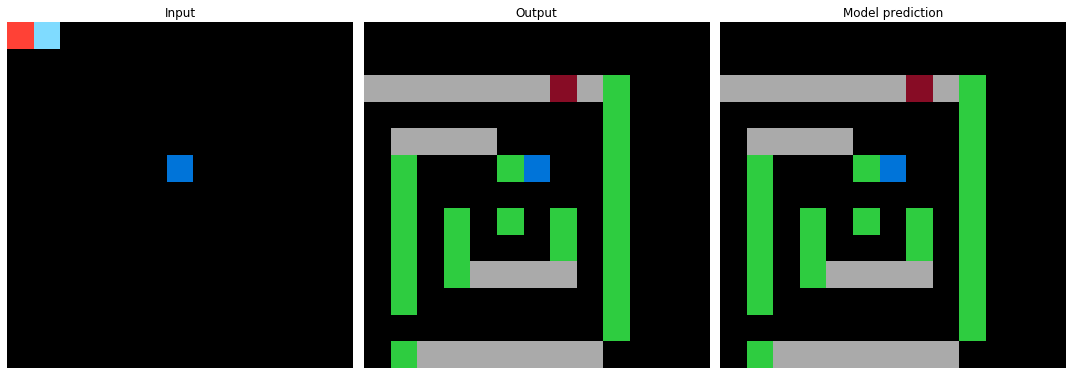

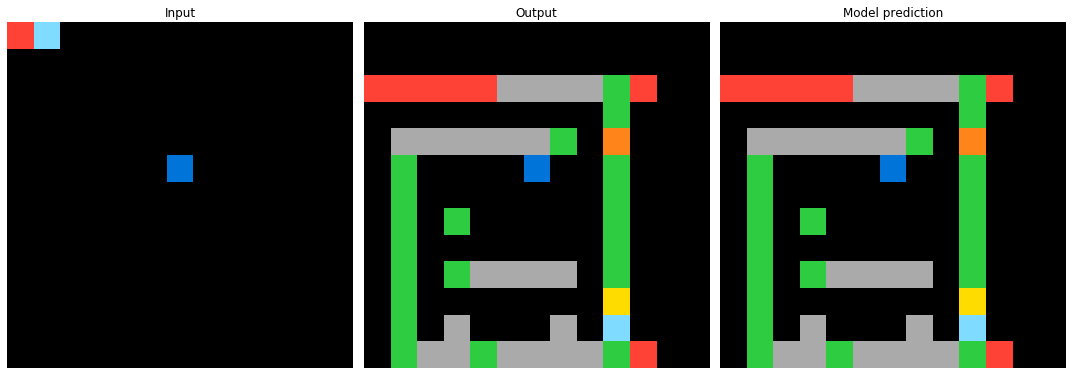

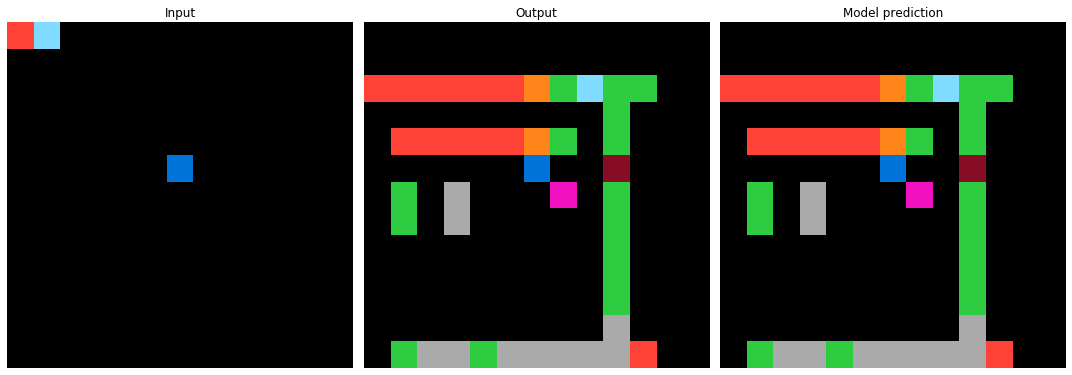

0a1d4ef5
15113be4


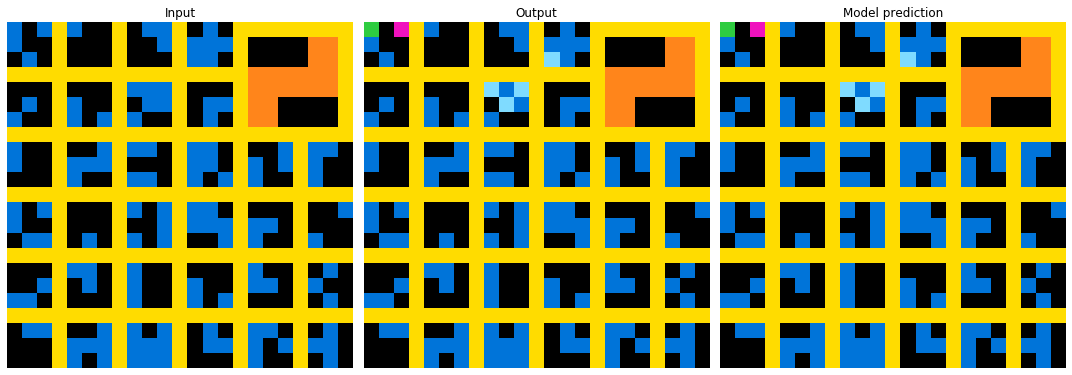

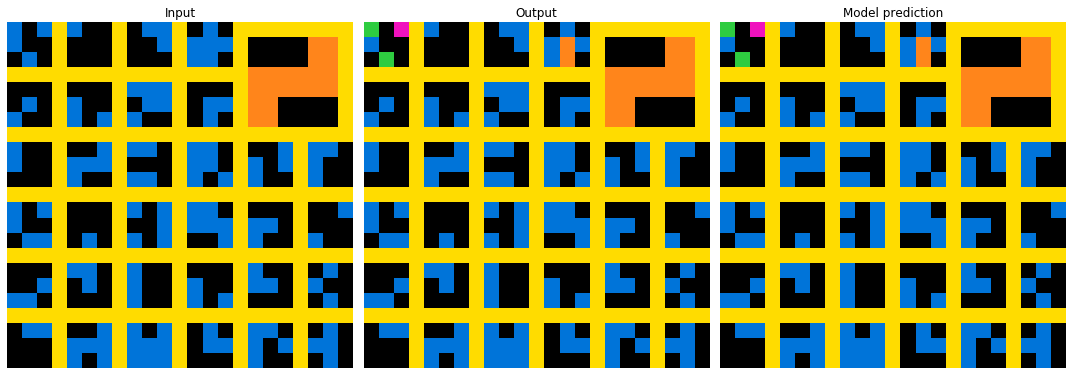

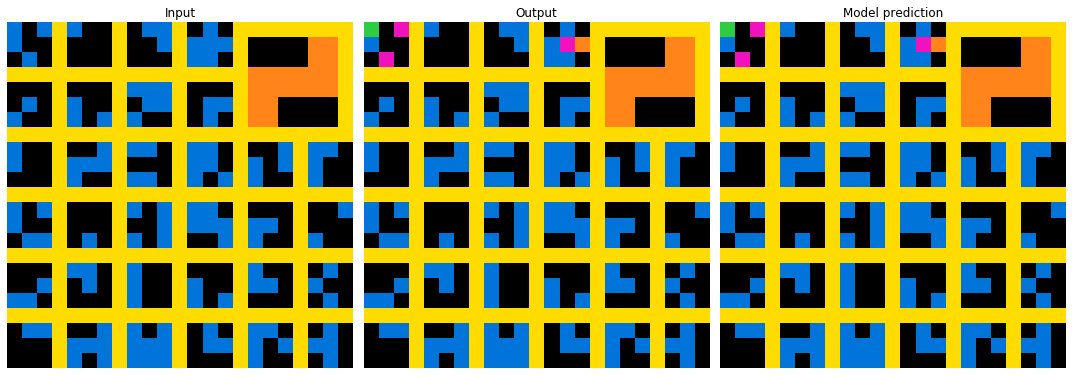

3f23242b


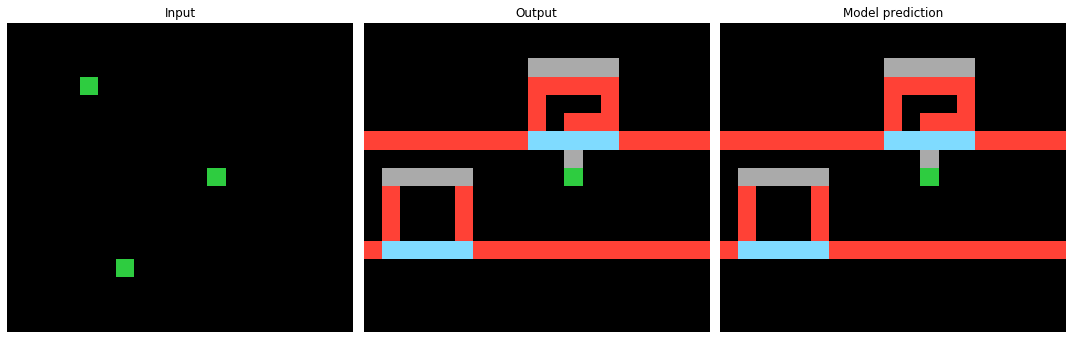

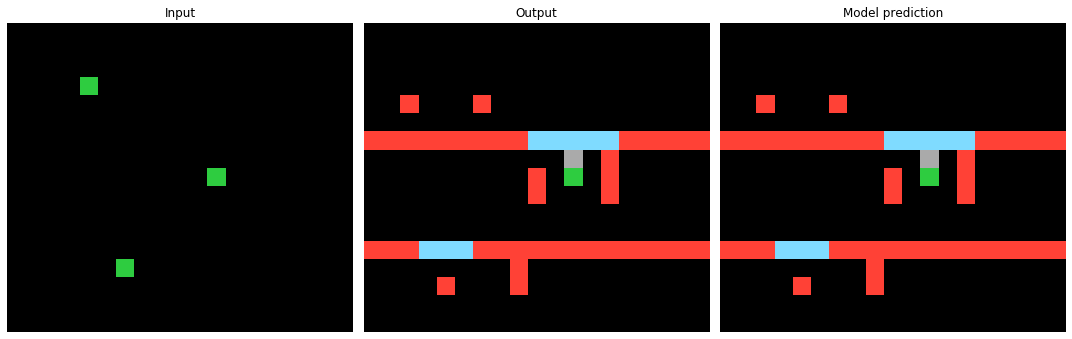

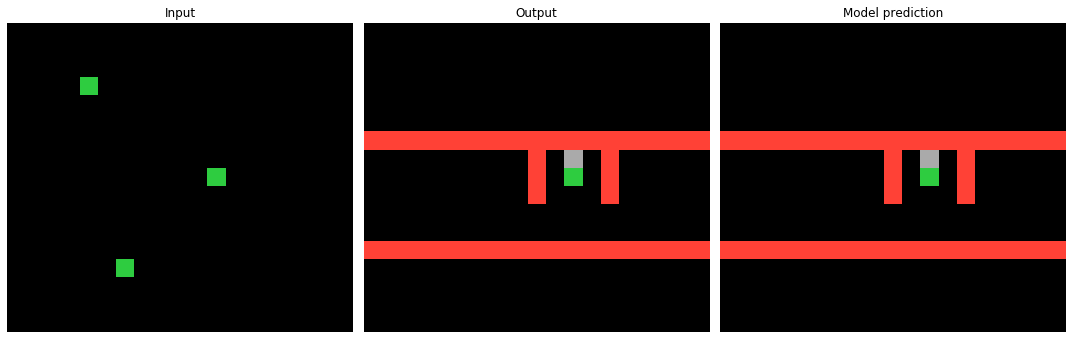

21f83797


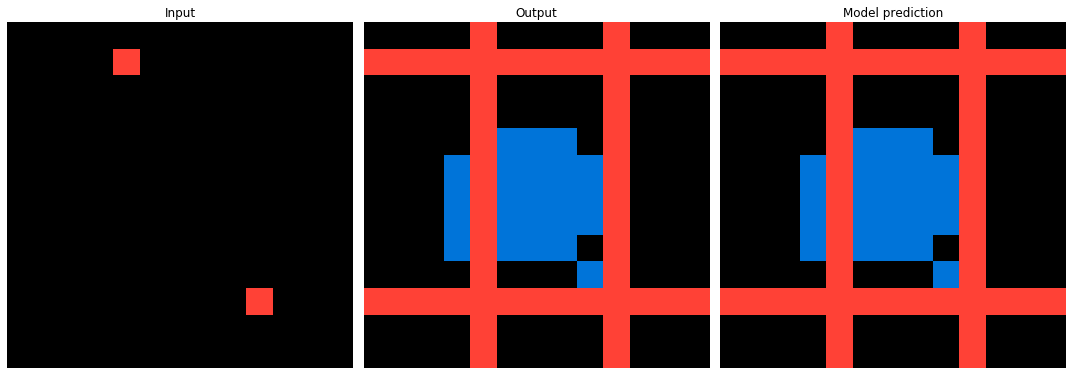

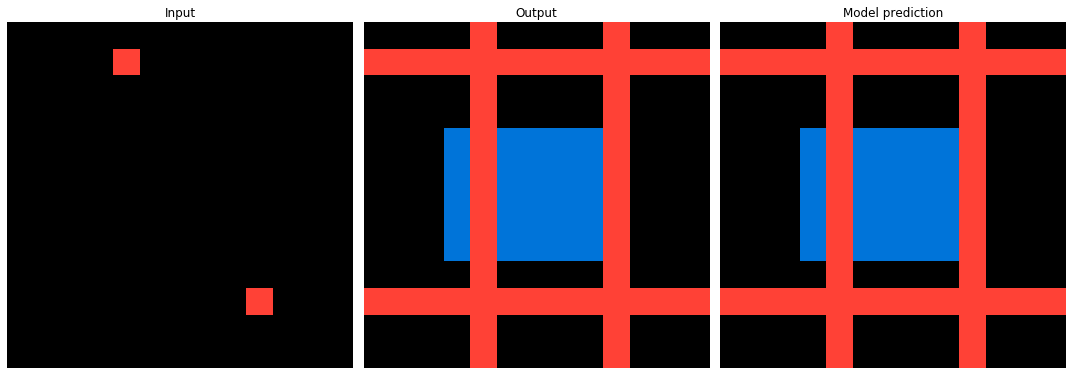

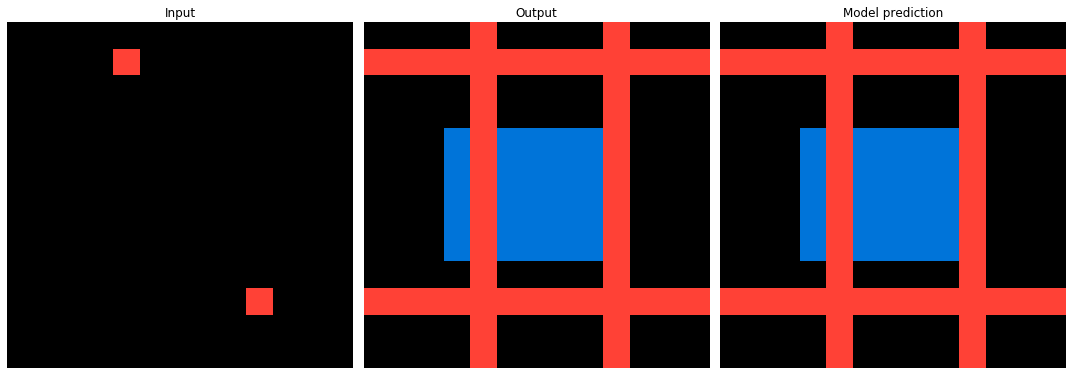

1990f7a8
00576224
1c0d0a4b


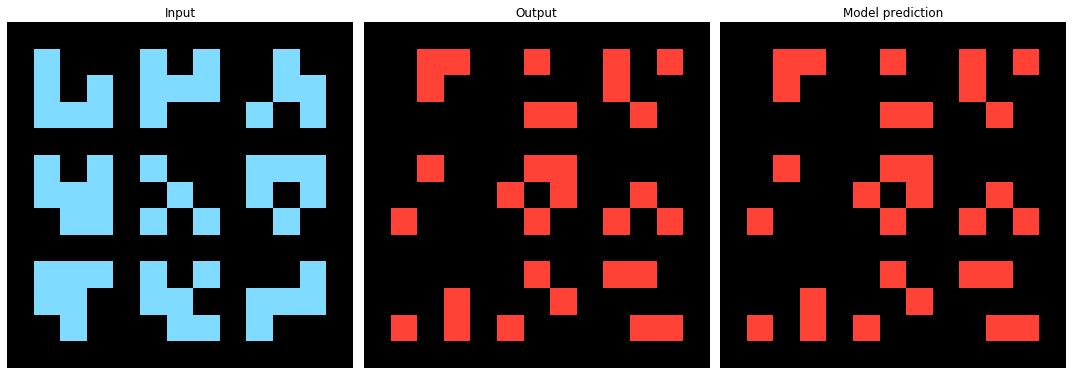

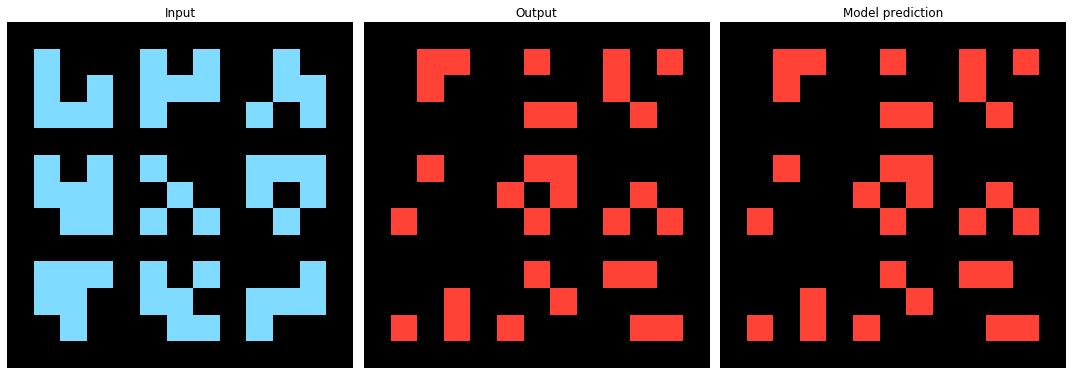

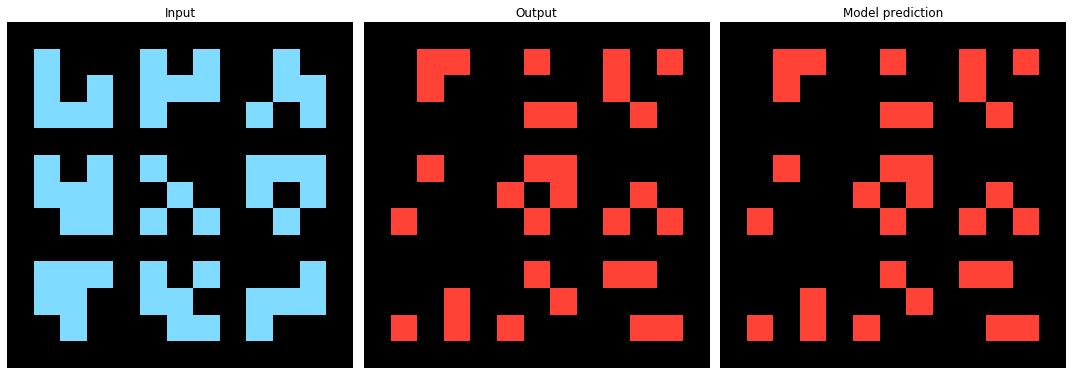

256b0a75


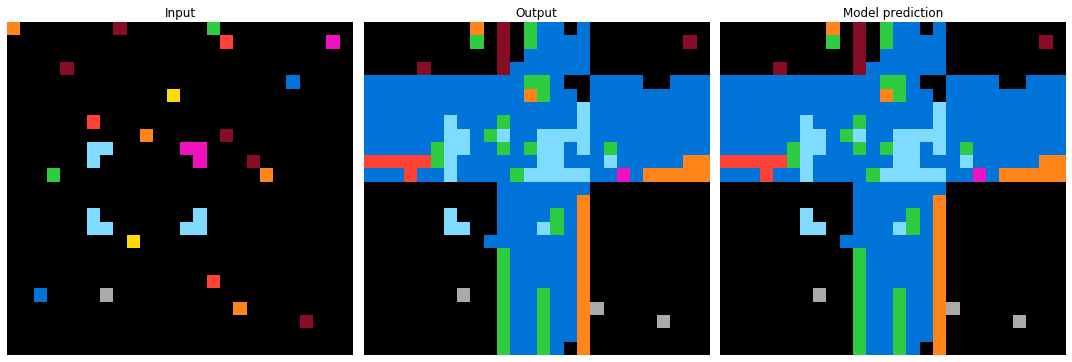

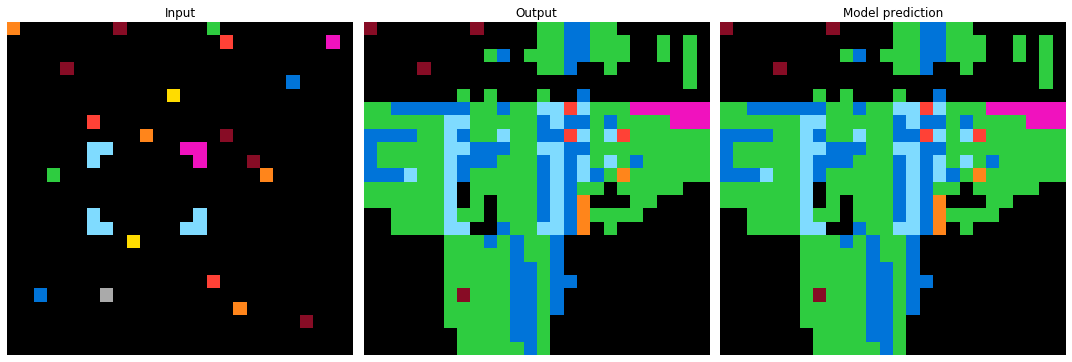

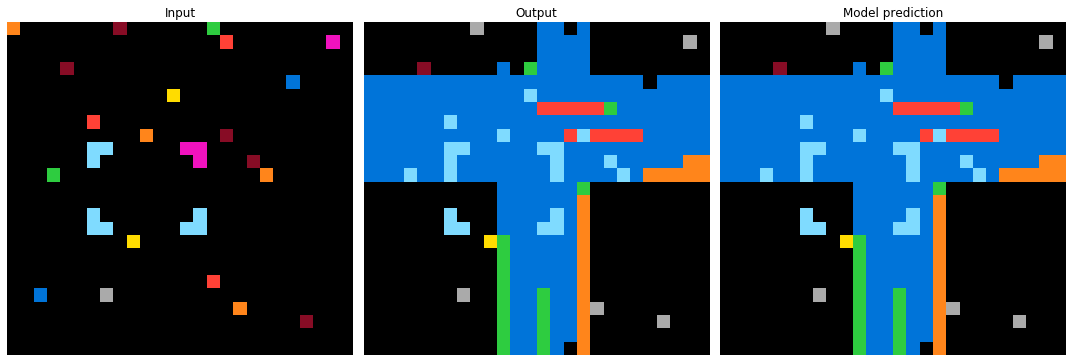

2546ccf6


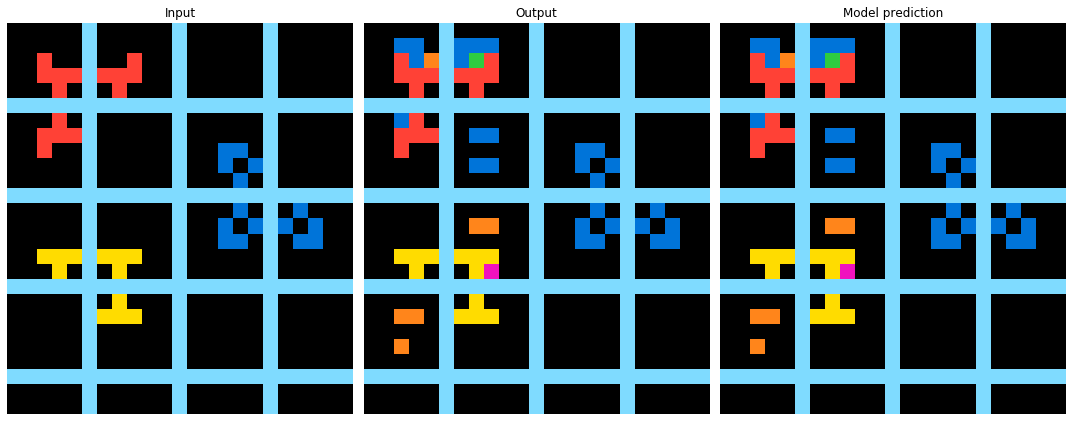

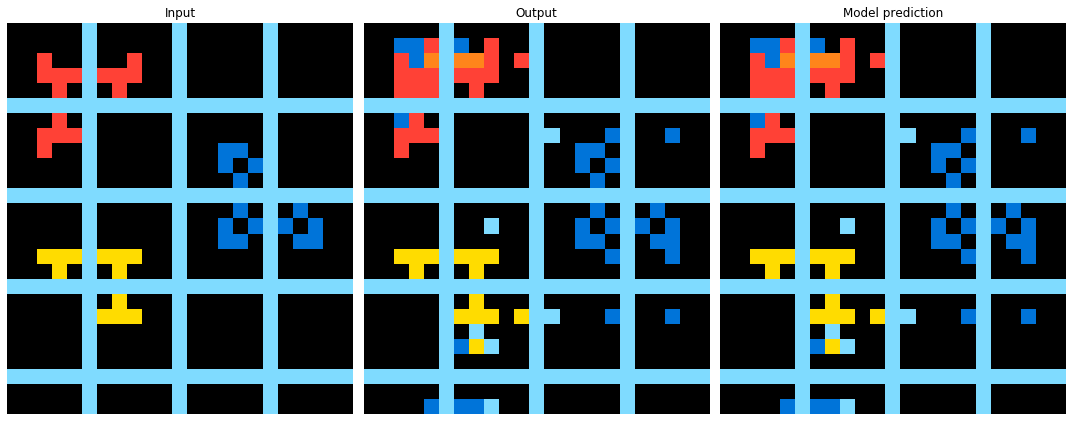

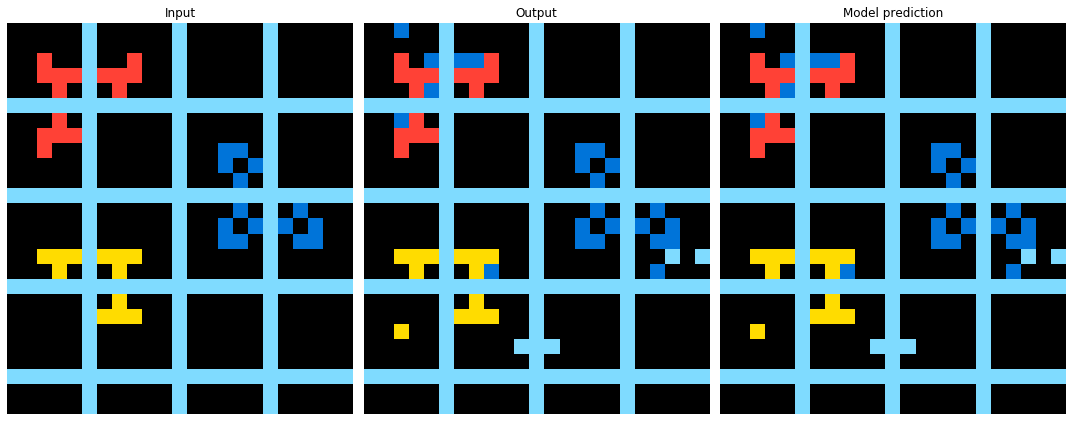

2c0b0aff
0d87d2a6


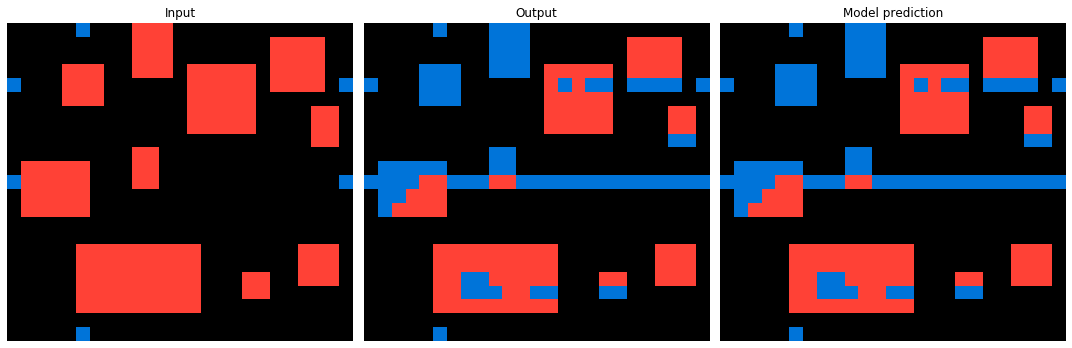

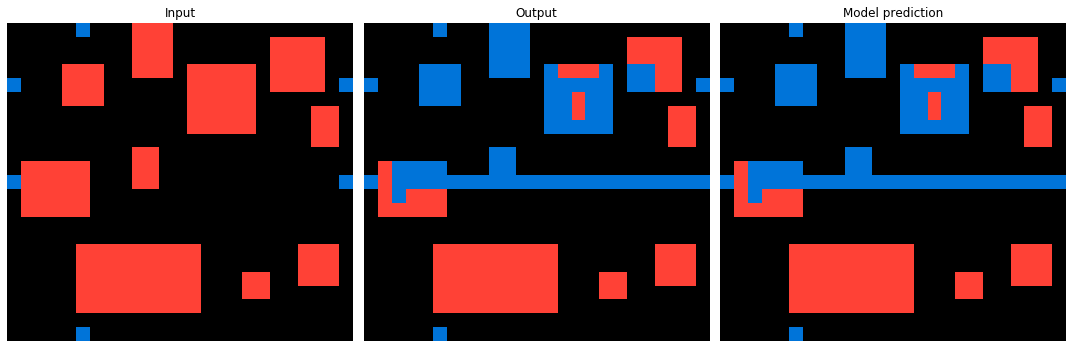

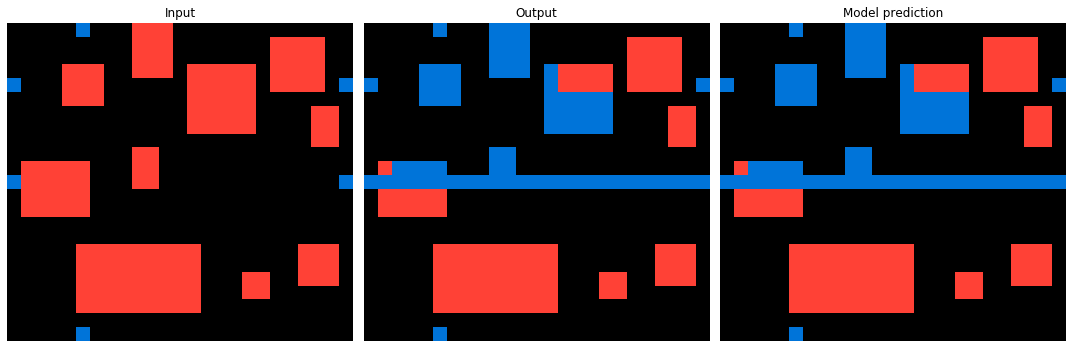

31d5ba1a
2697da3f
1d398264


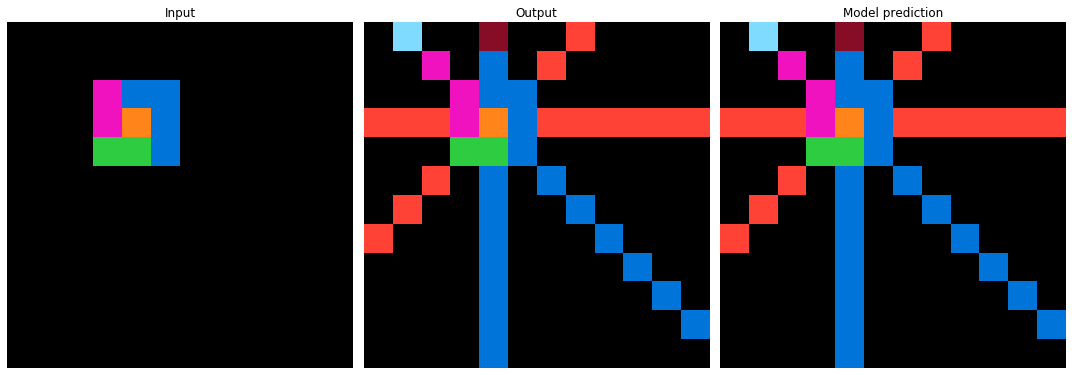

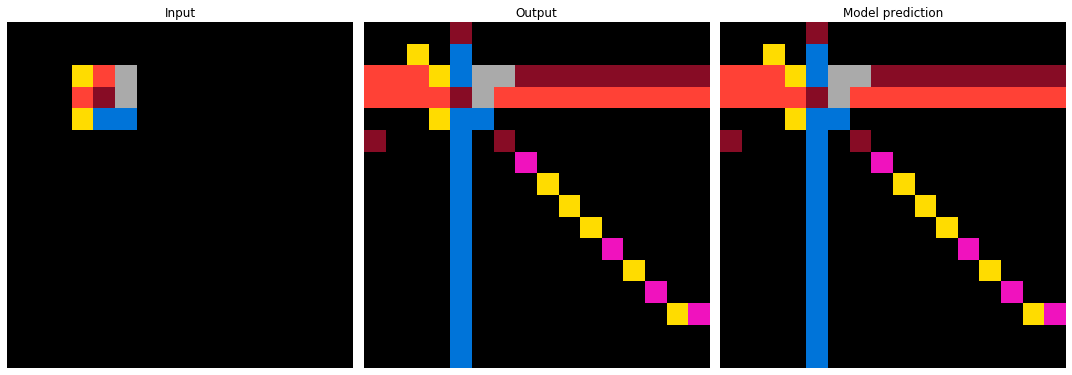

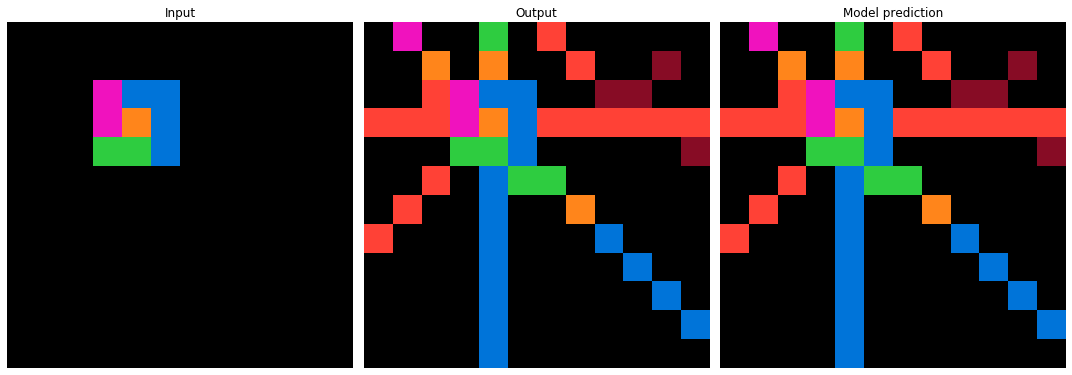

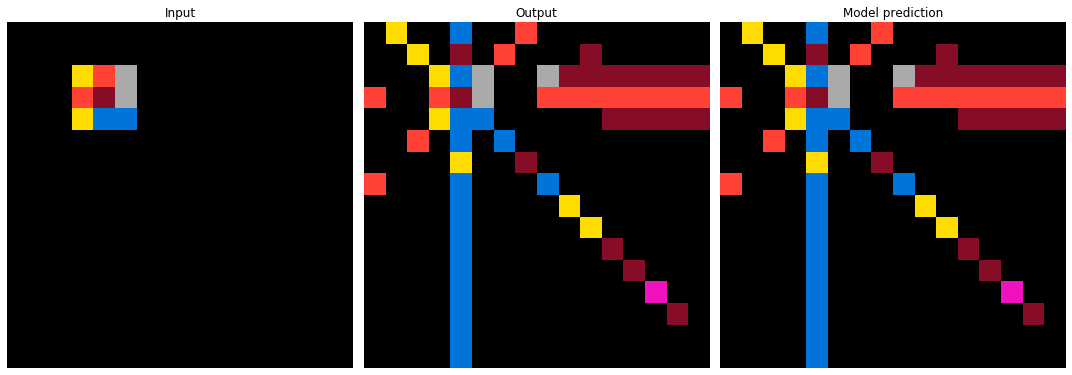

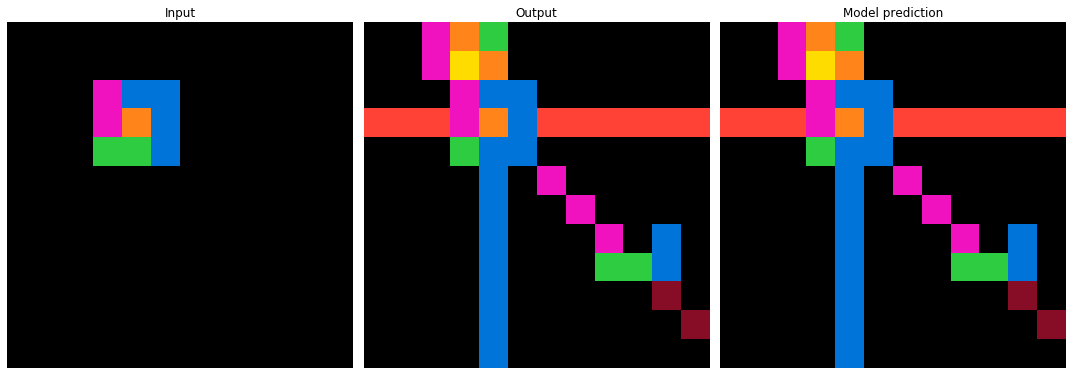

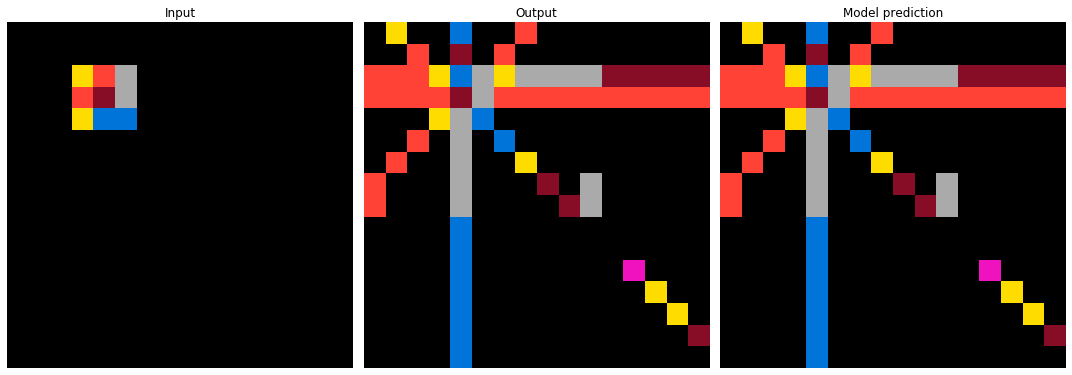

2753e76c
16b78196


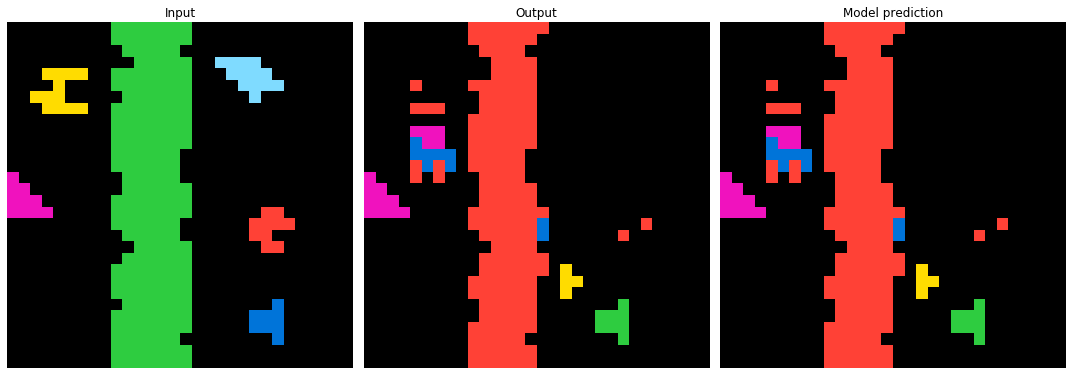

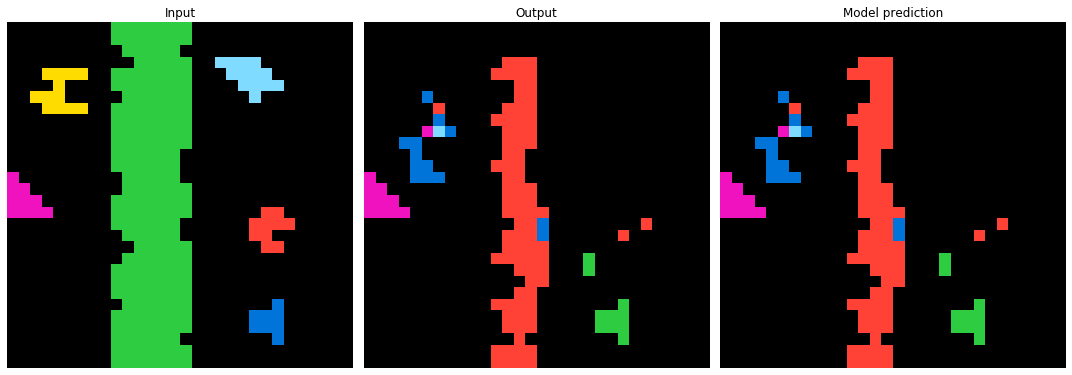

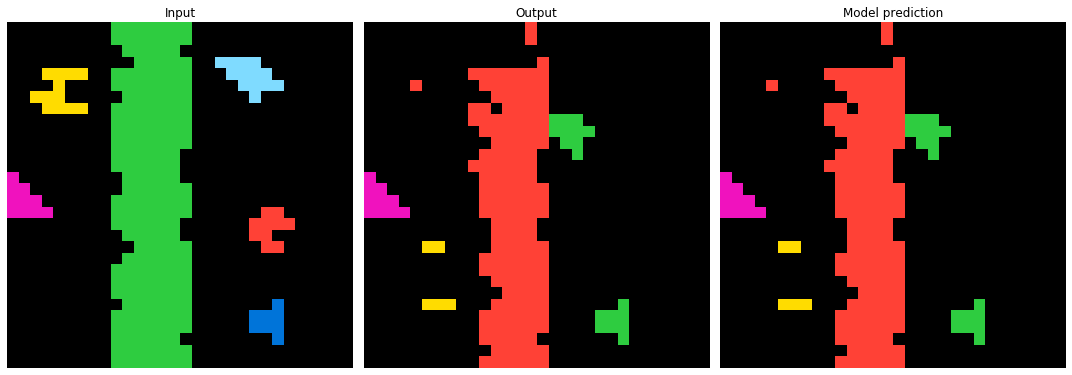

25094a63


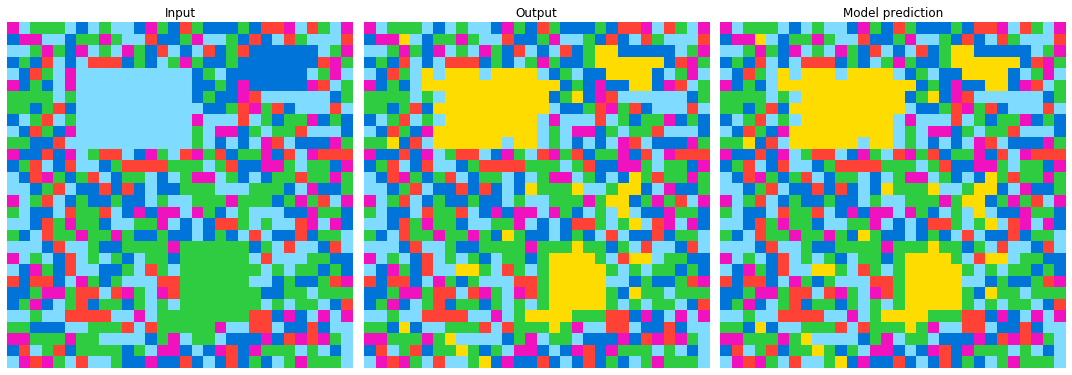

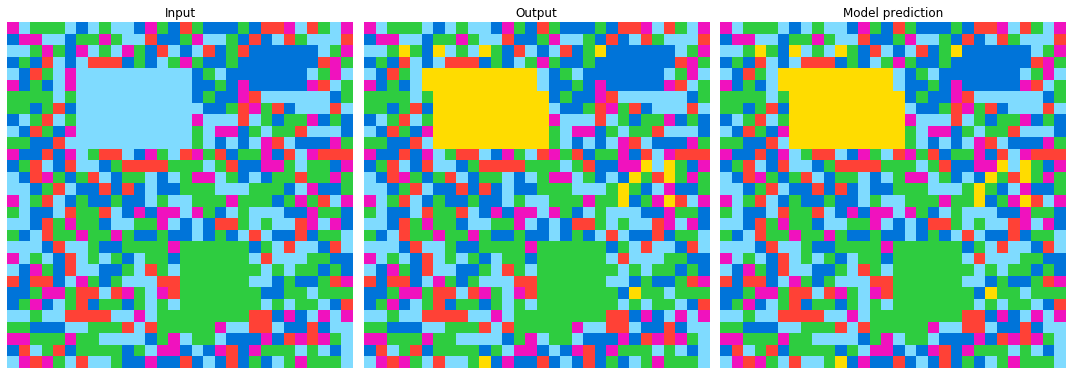

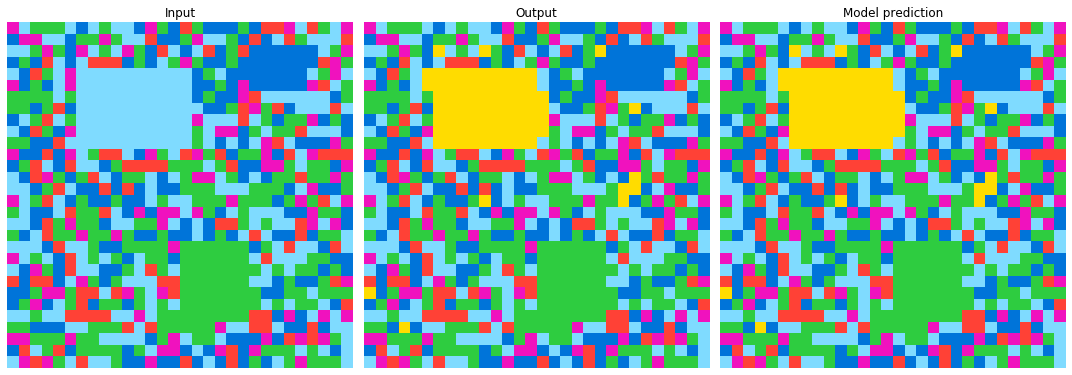

15663ba9


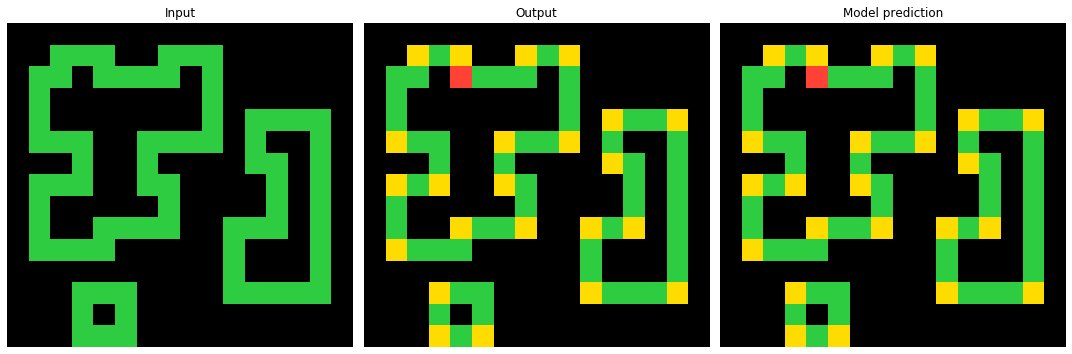

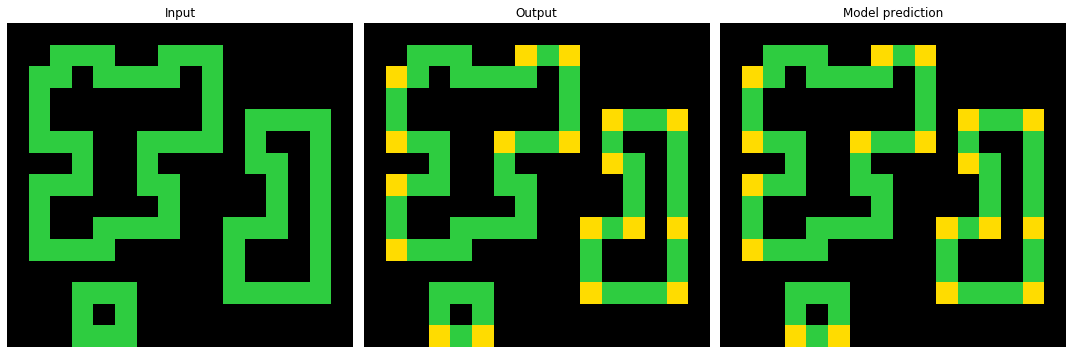

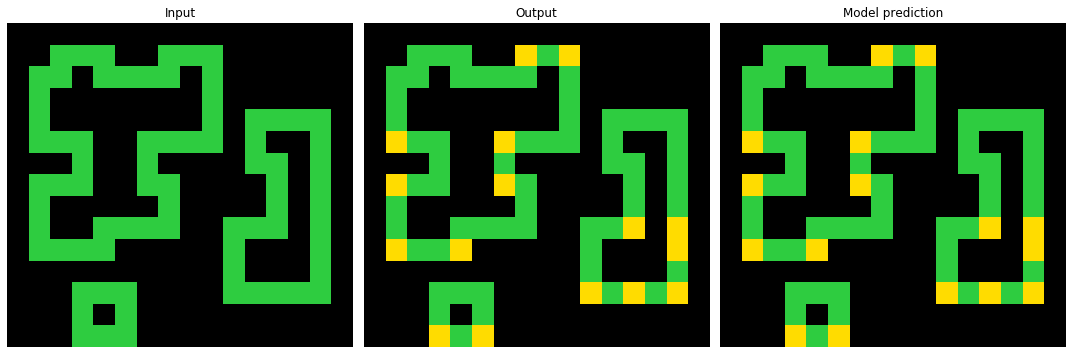

22a4bbc2


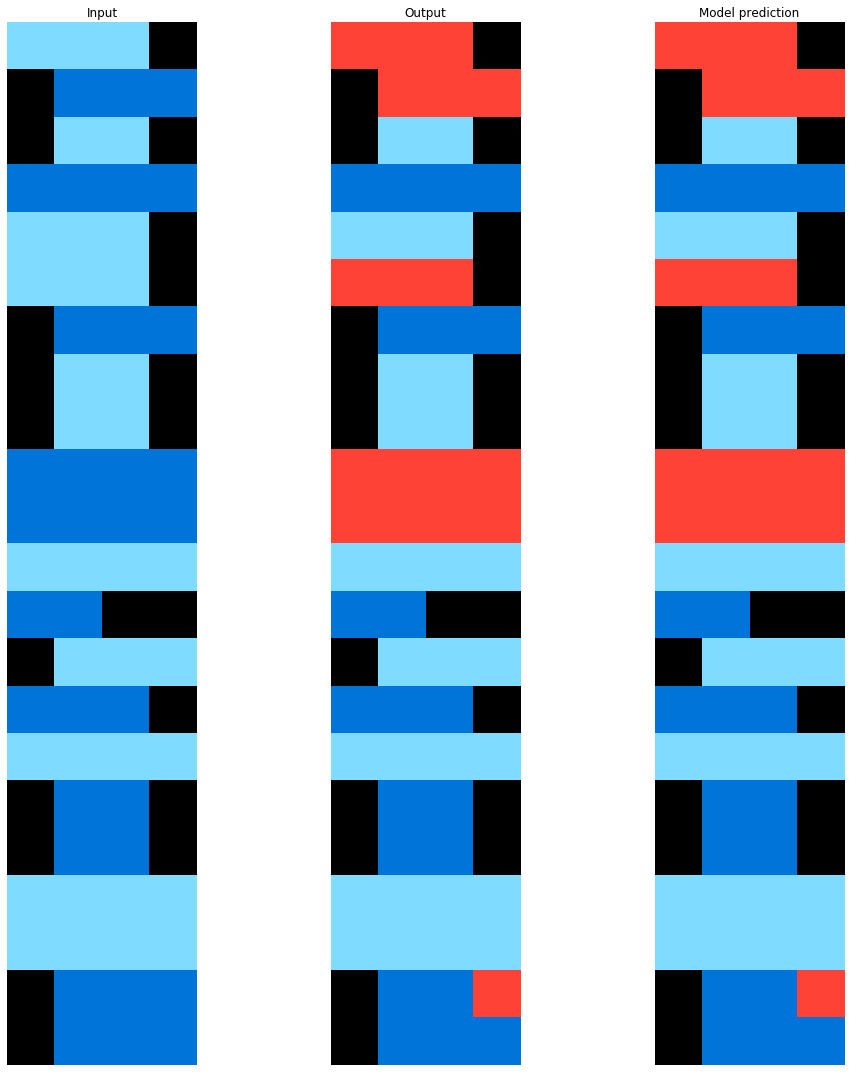

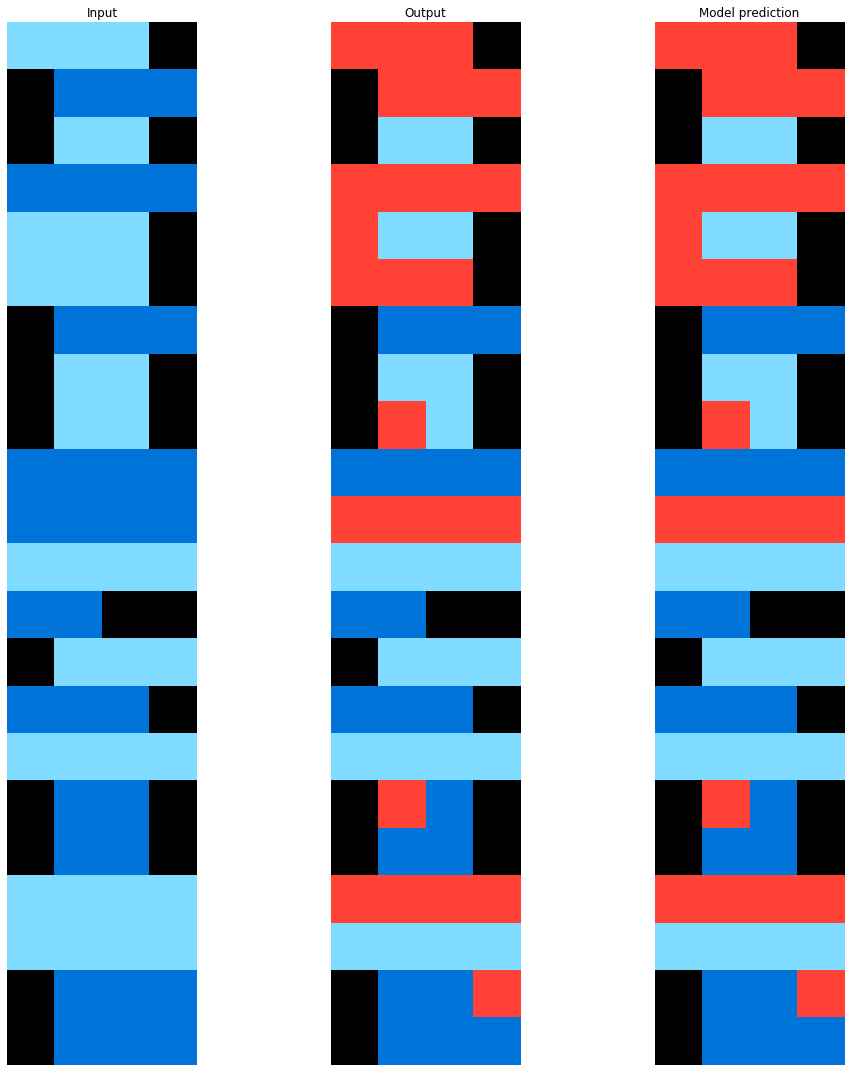

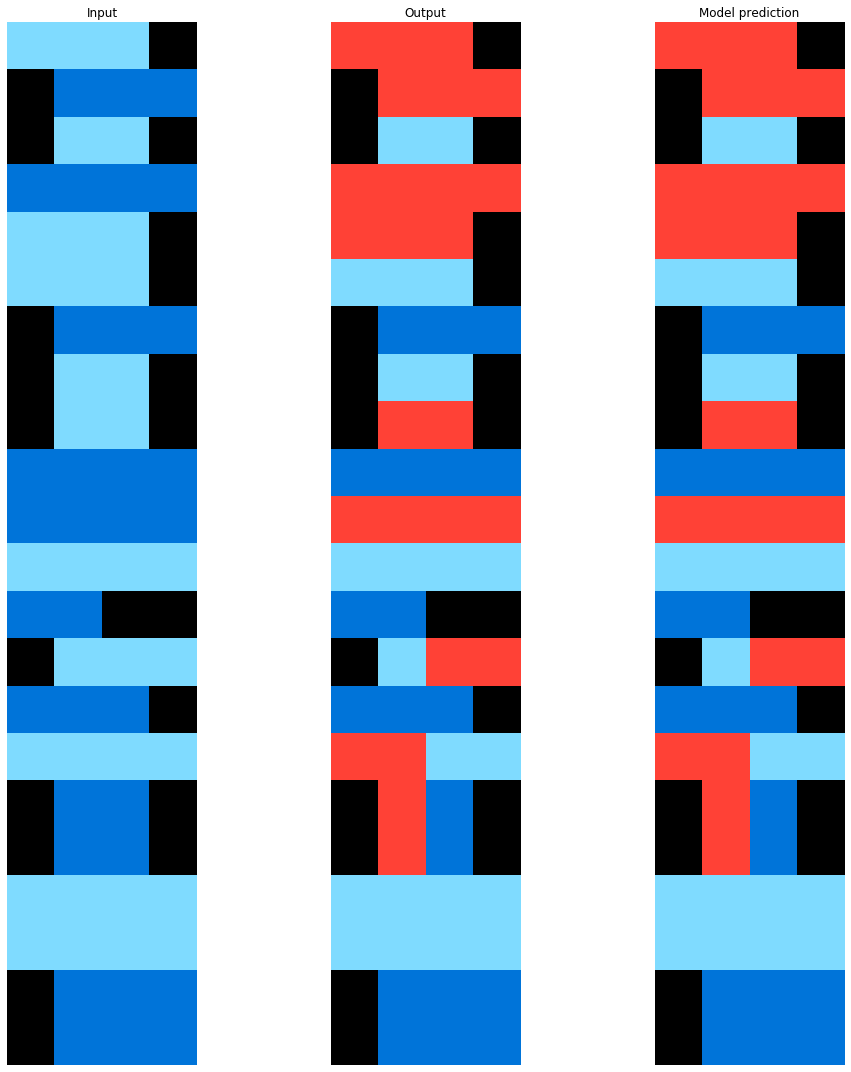

319f2597


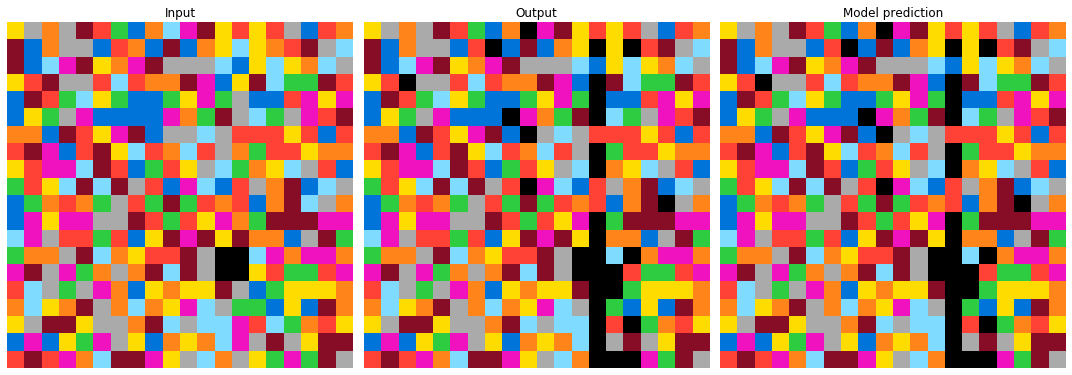

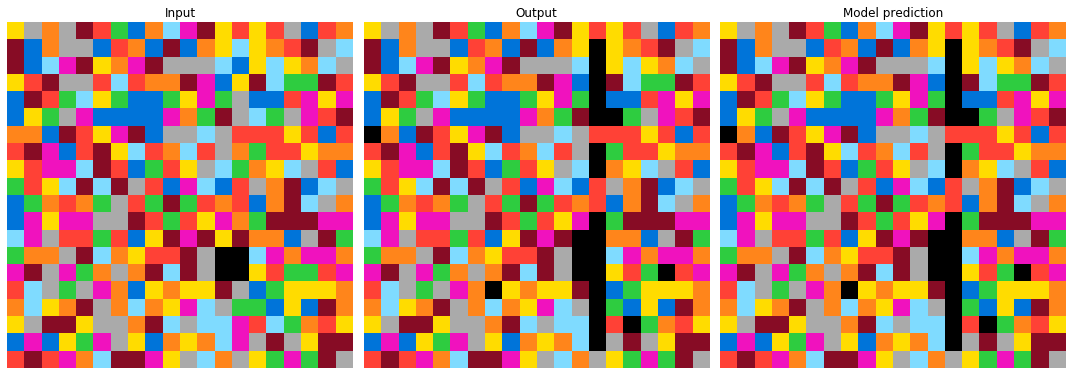

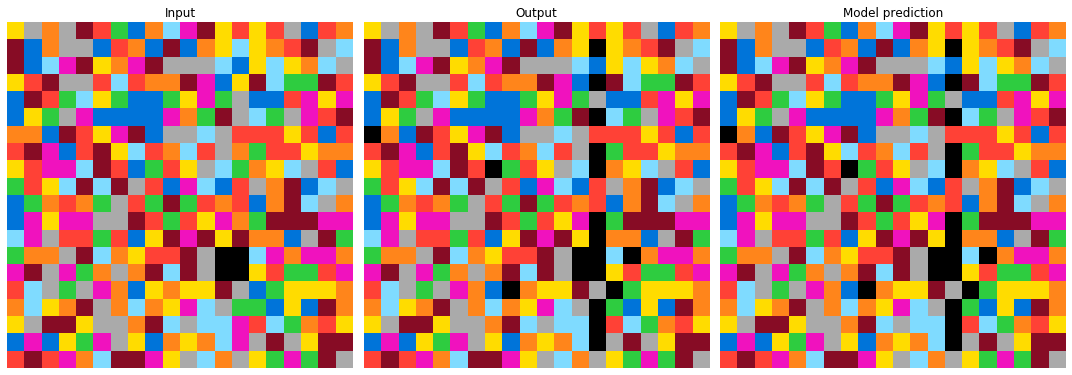

0bb8deee
2f0c5170
3490cc26


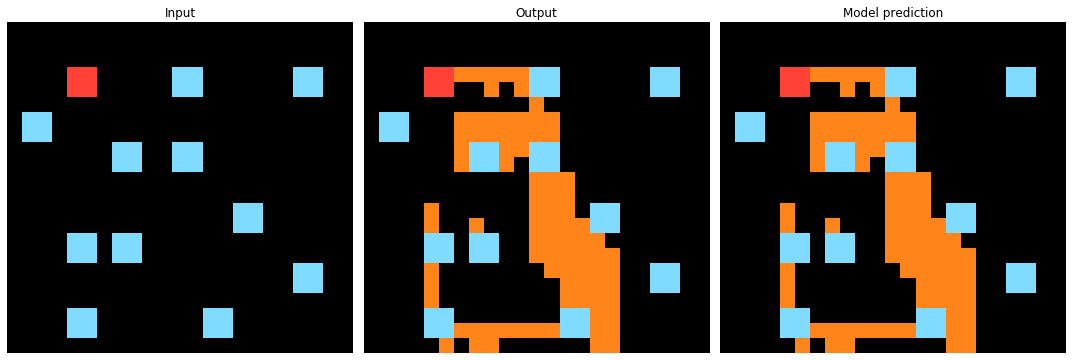

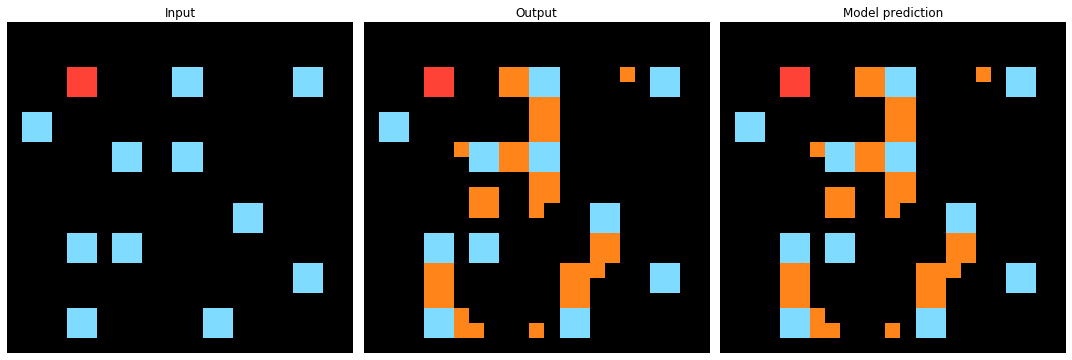

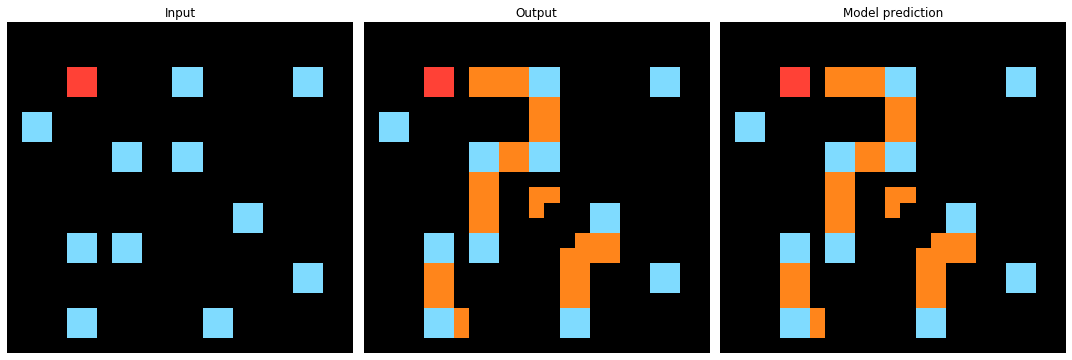

03560426


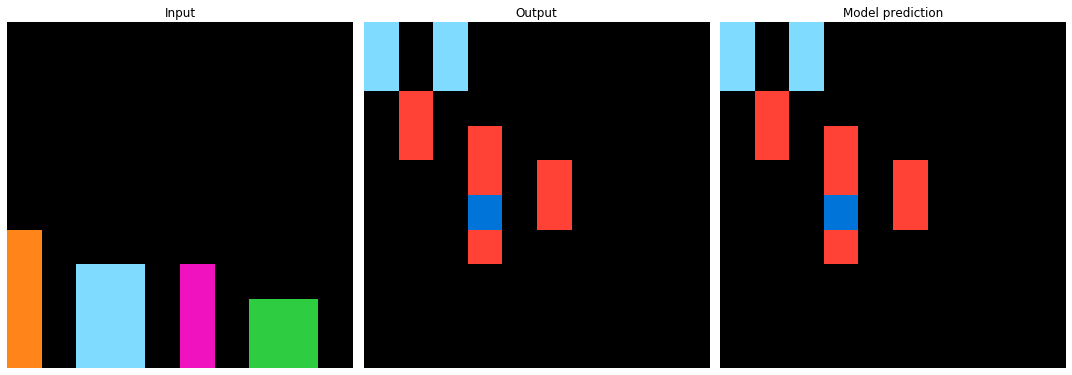

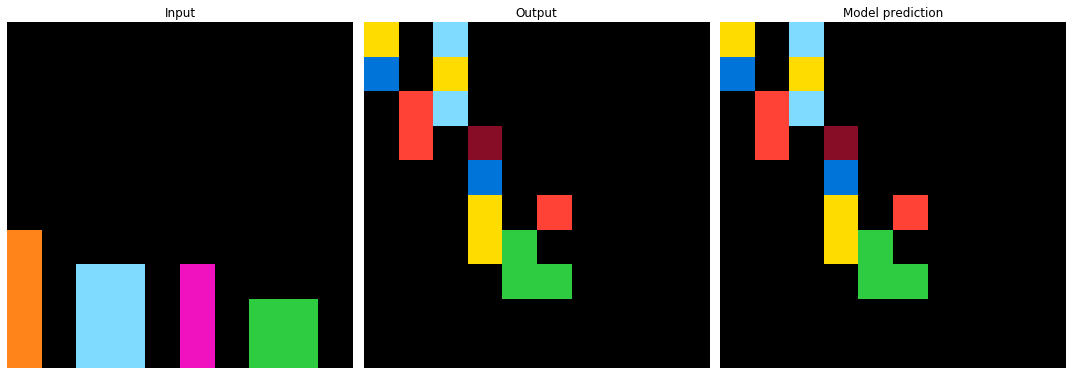

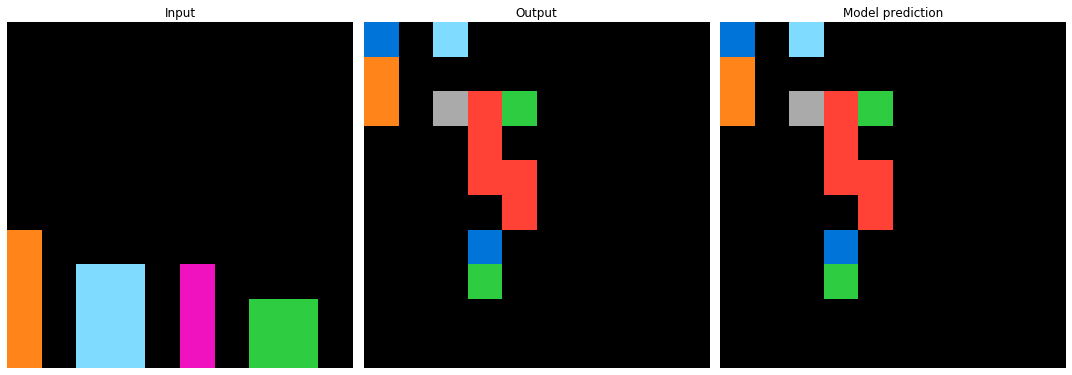

12422b43


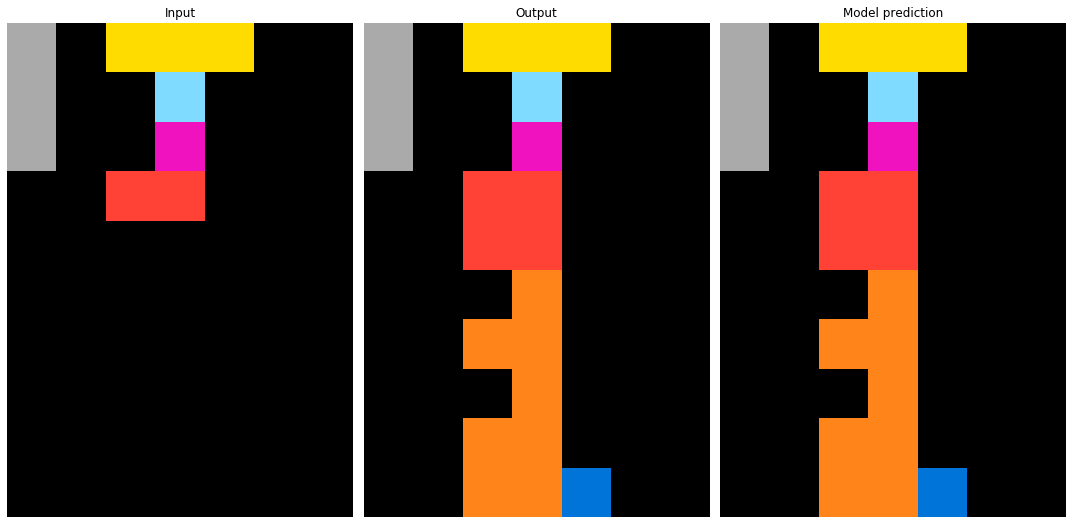

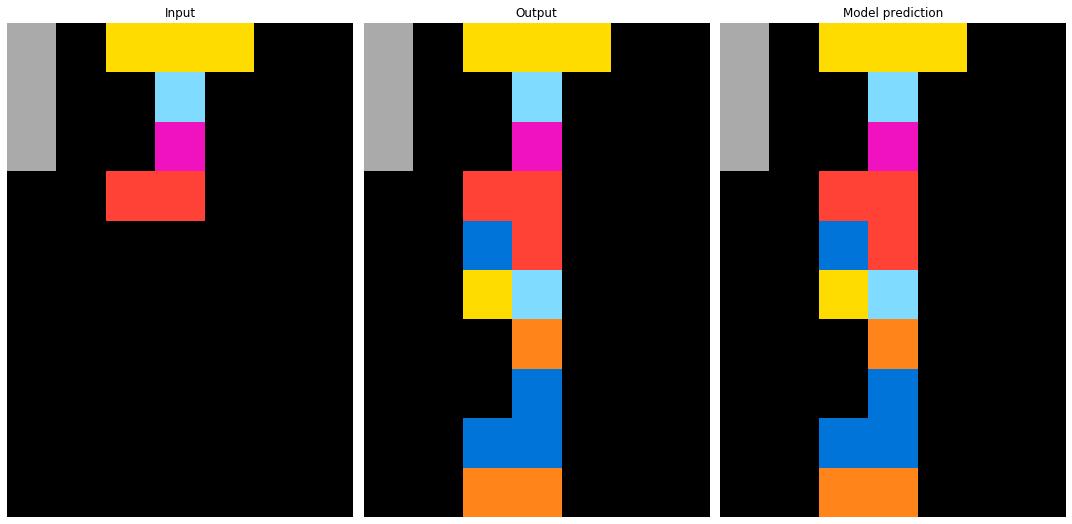

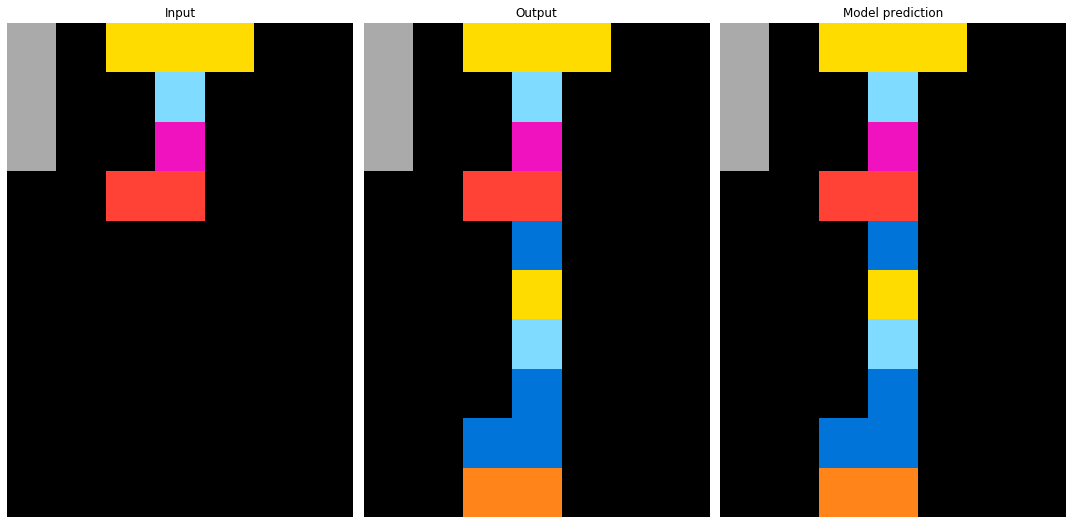

0c786b71
184a9768


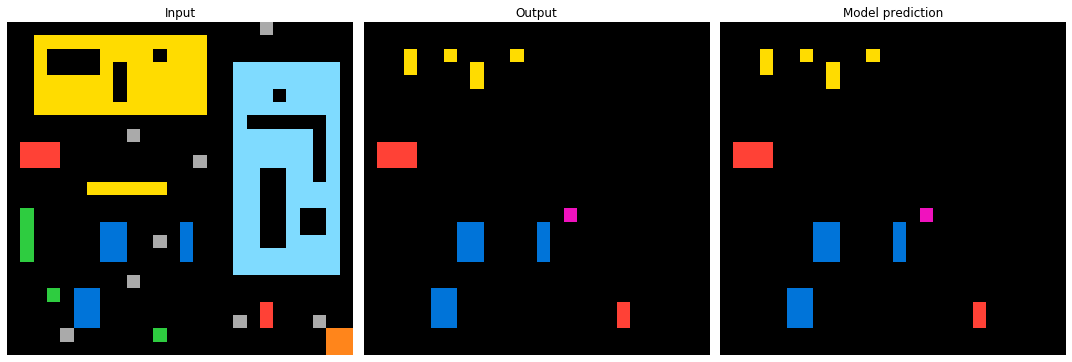

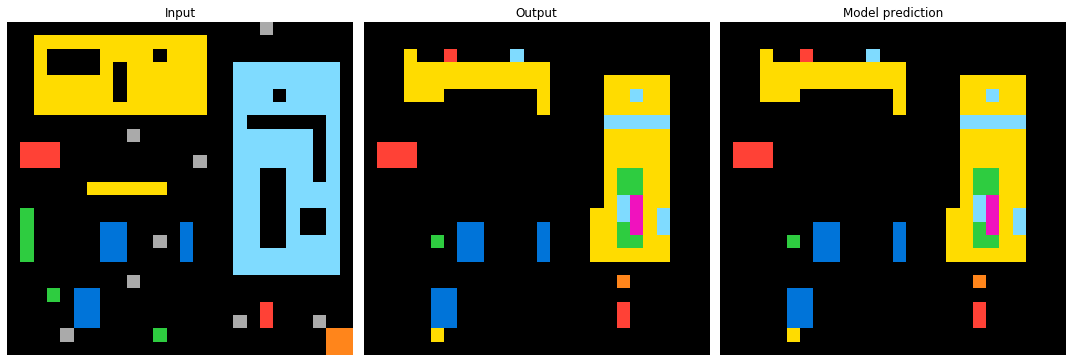

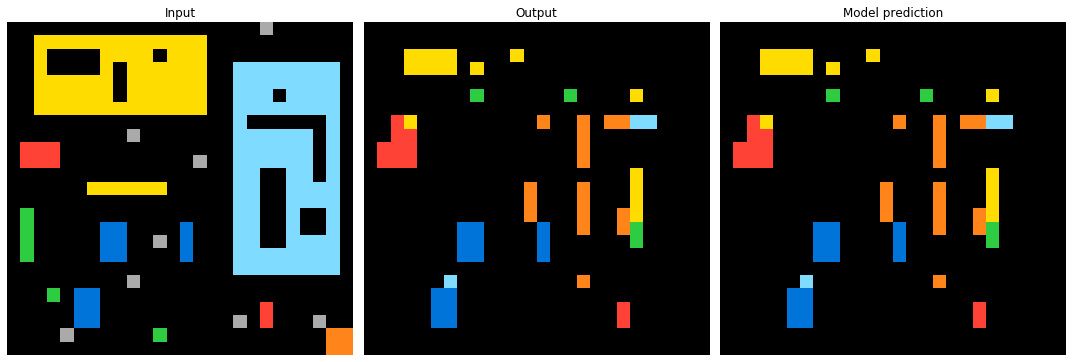

3391f8c0


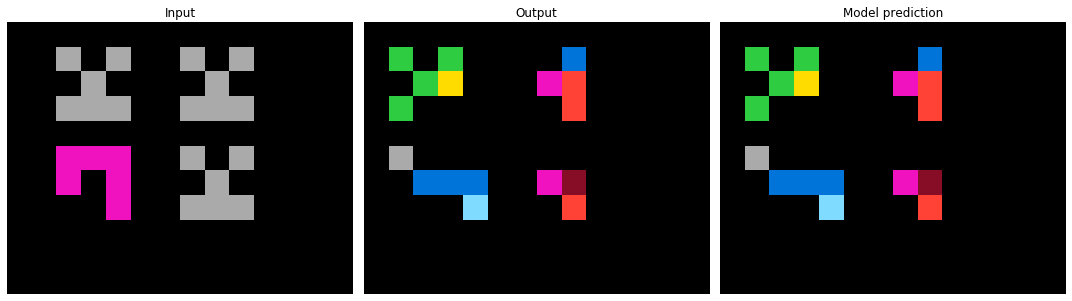

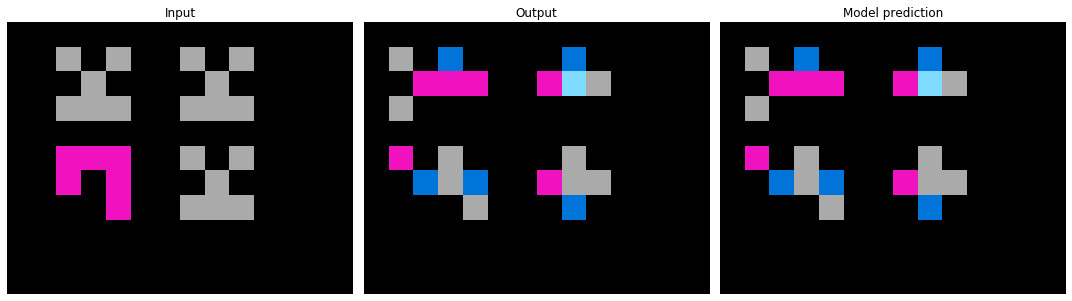

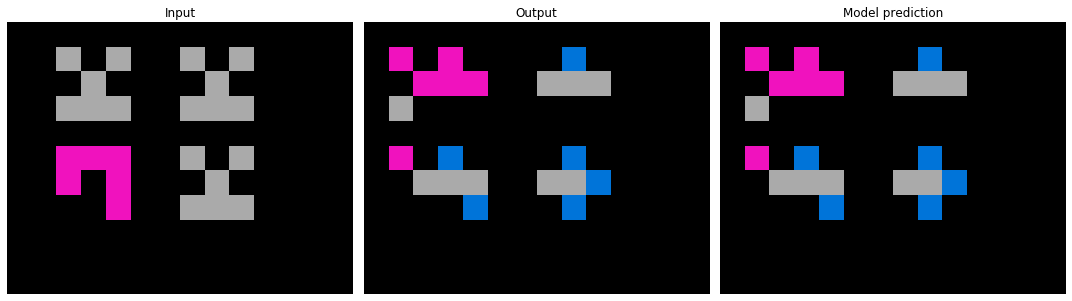

0c9aba6e
140c817e


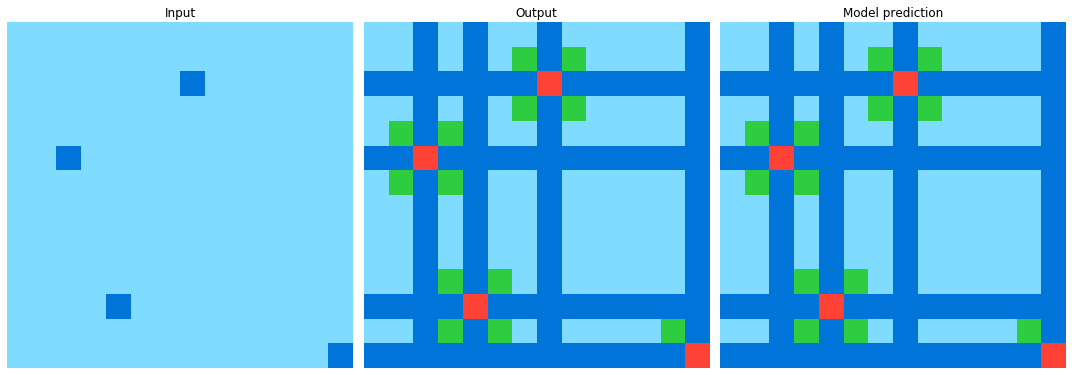

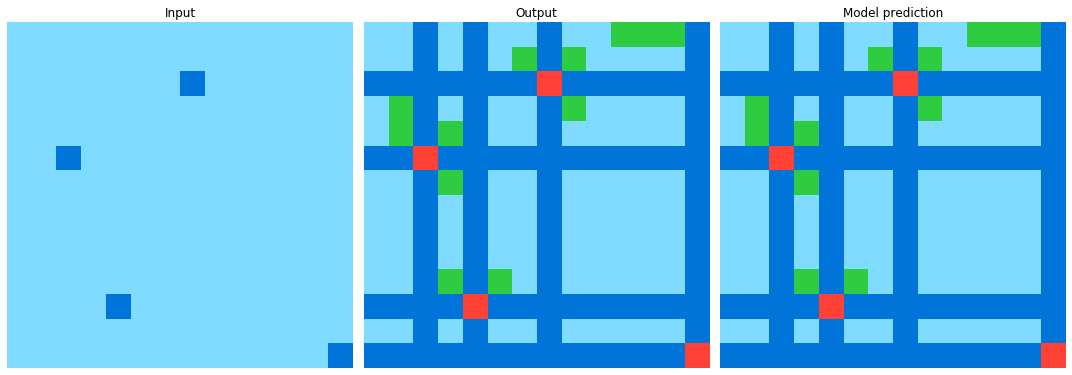

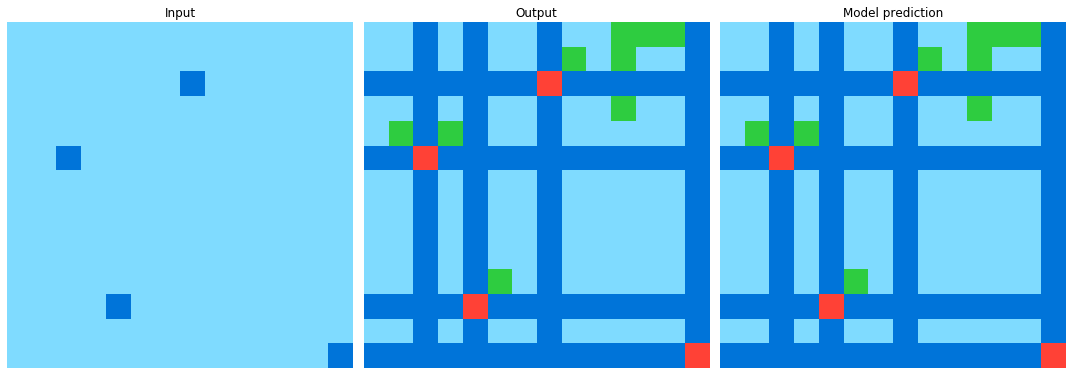

2072aba6
20981f0e


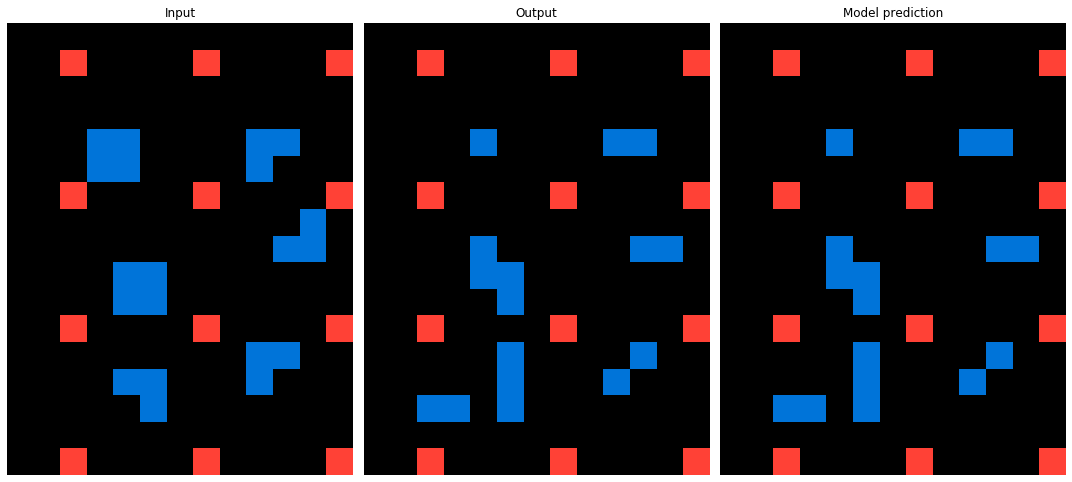

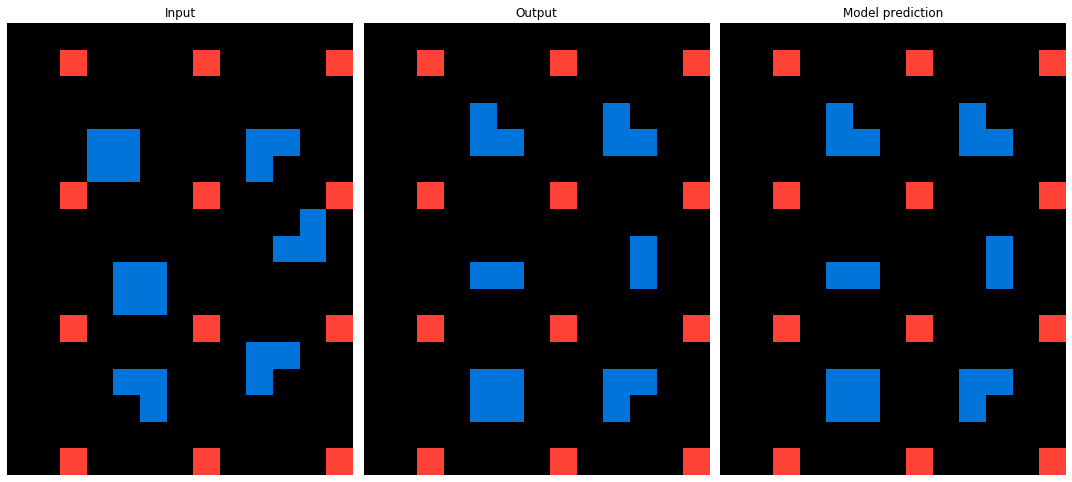

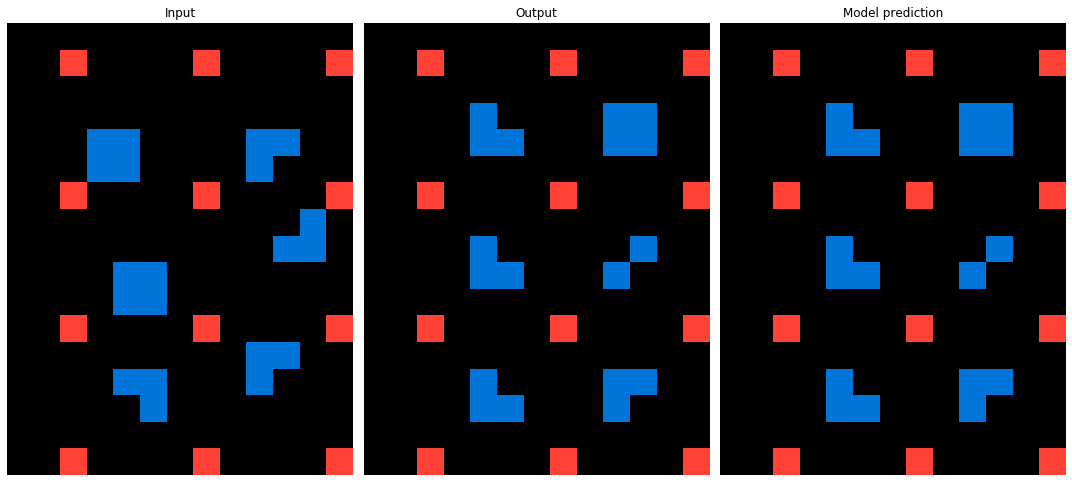

292dd178


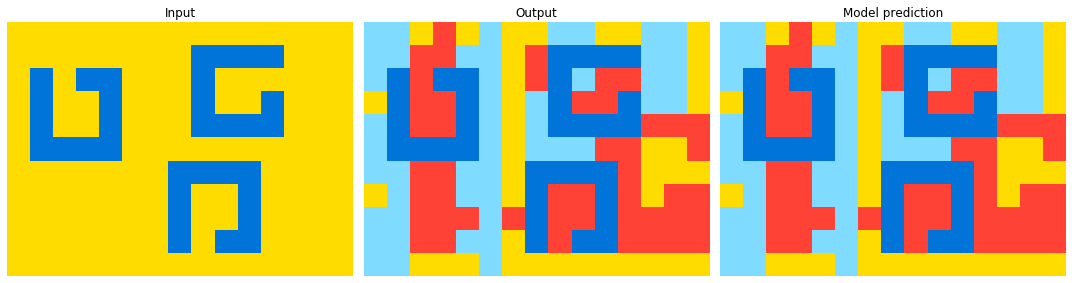

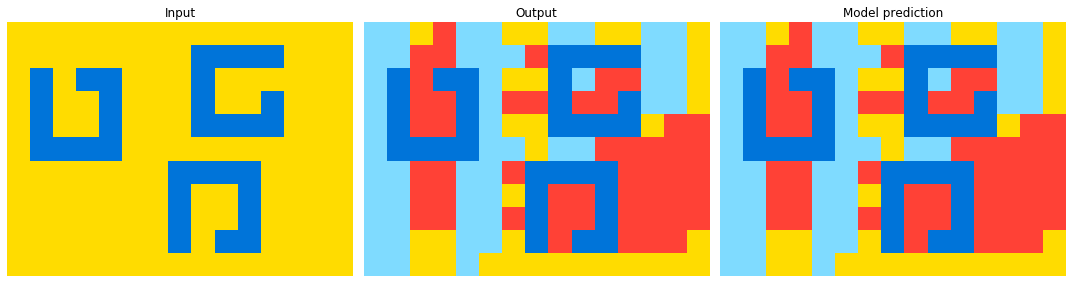

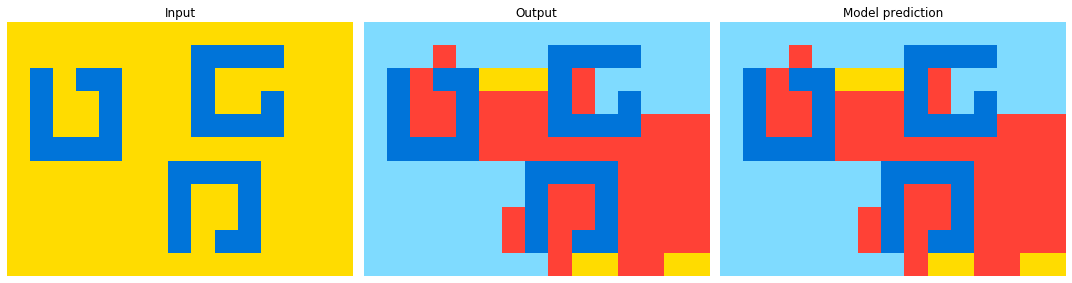

29700607


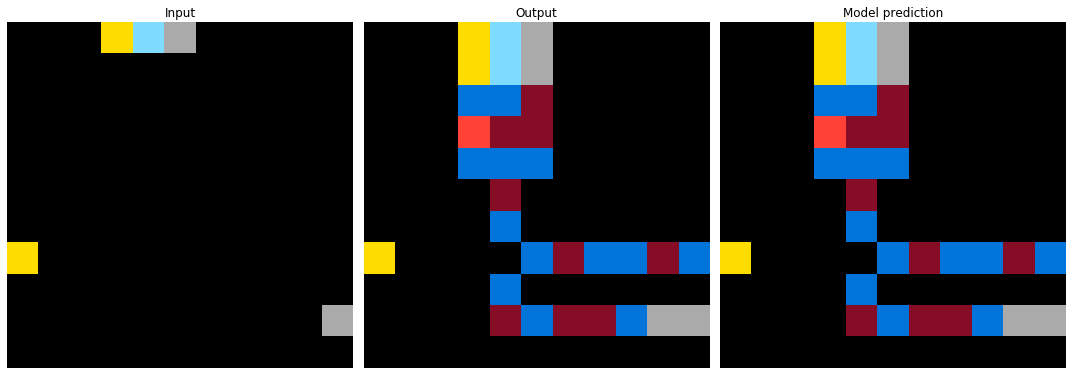

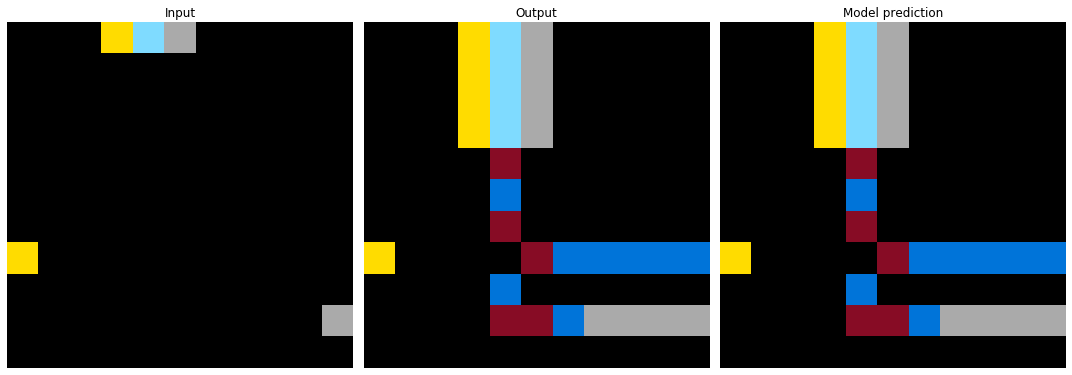

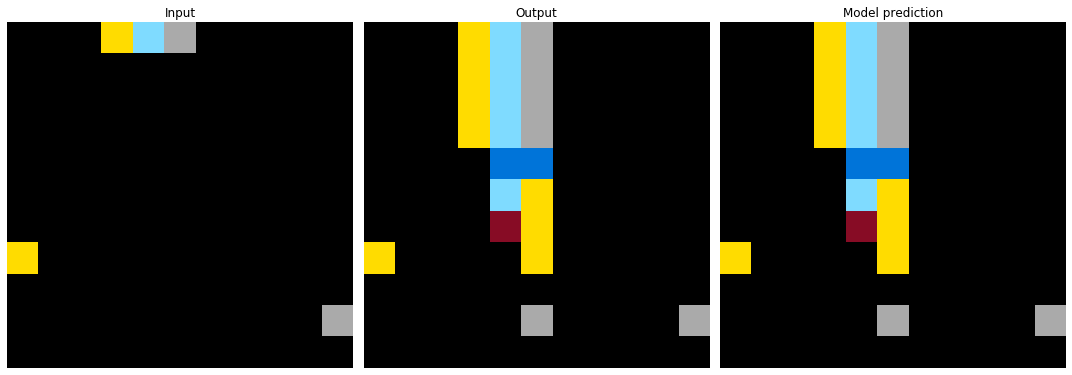

27a77e38


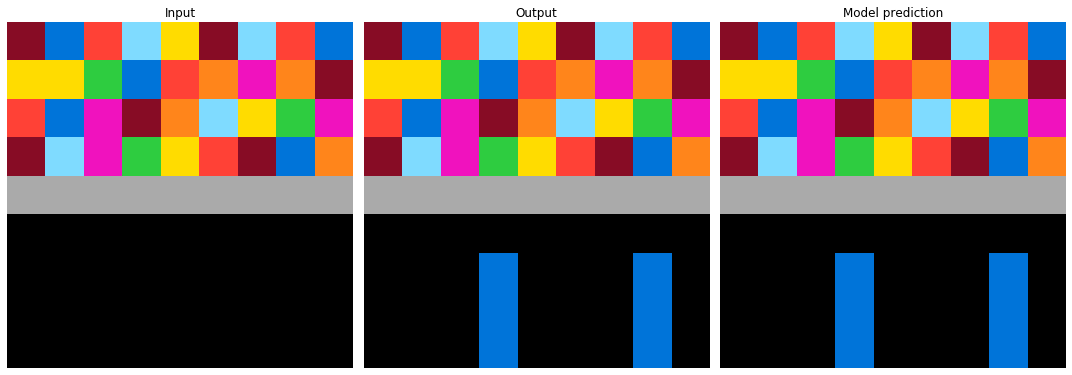

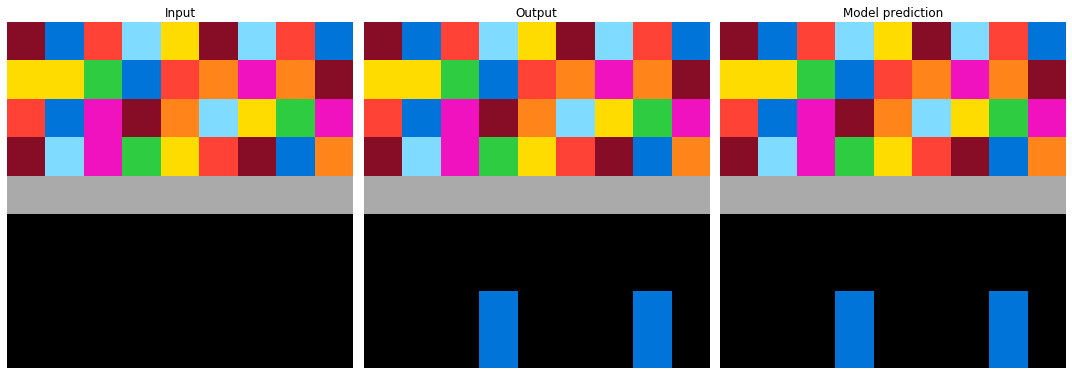

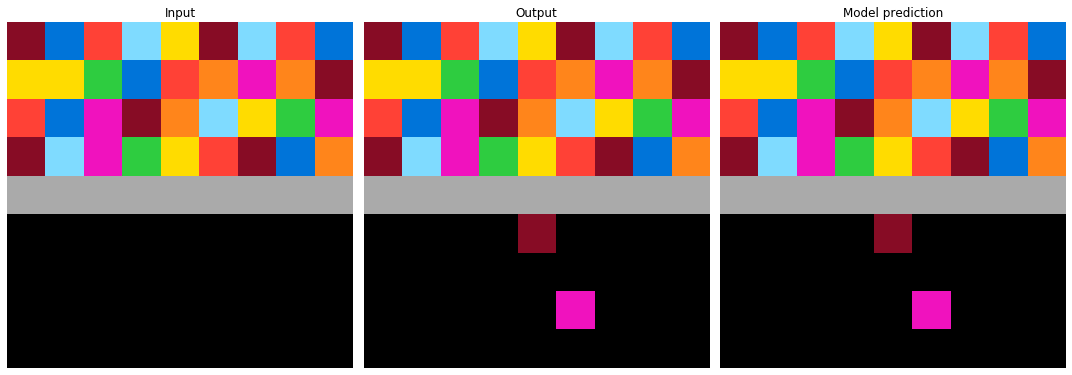

27f8ce4f
17cae0c1


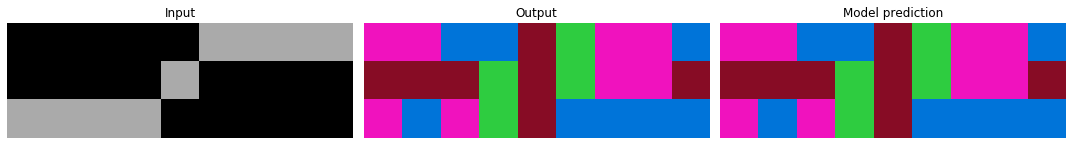

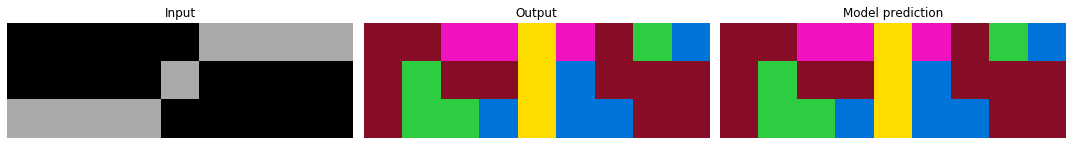

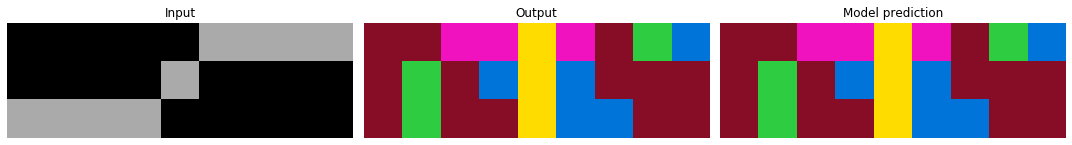

3979b1a8
40f6cd08


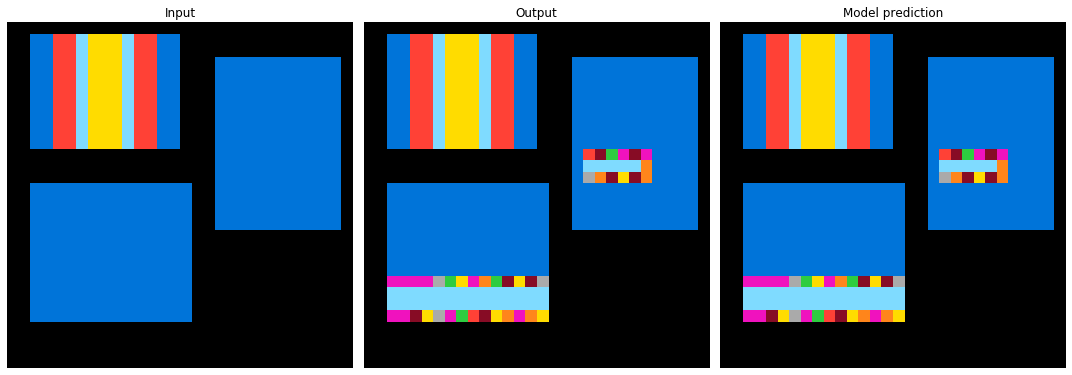

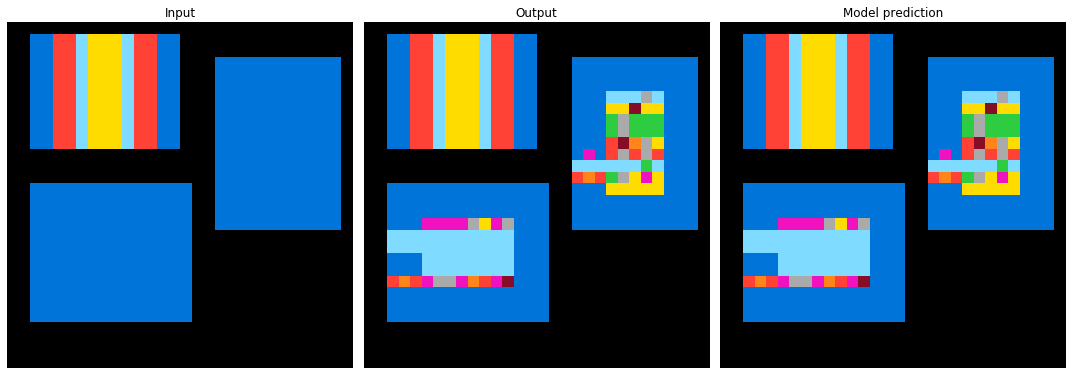

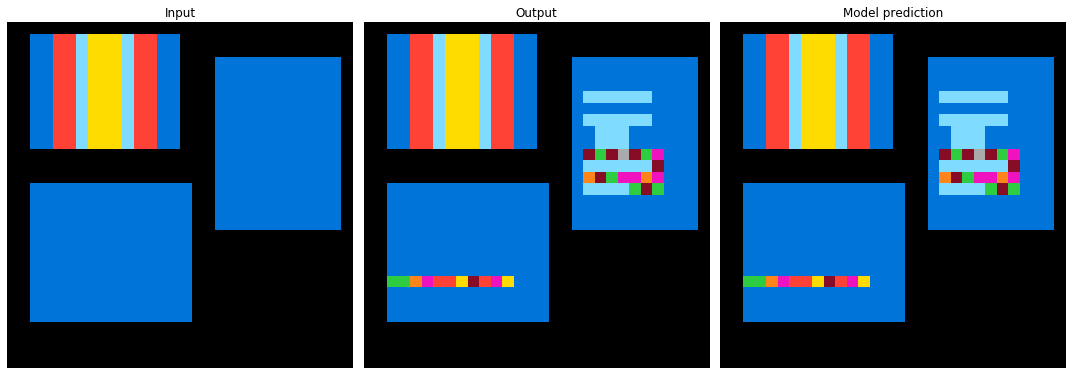

3194b014
32e9702f


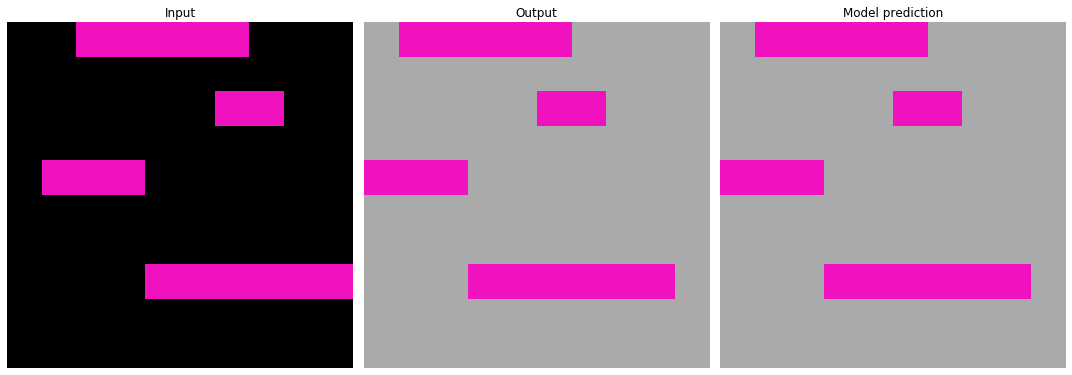

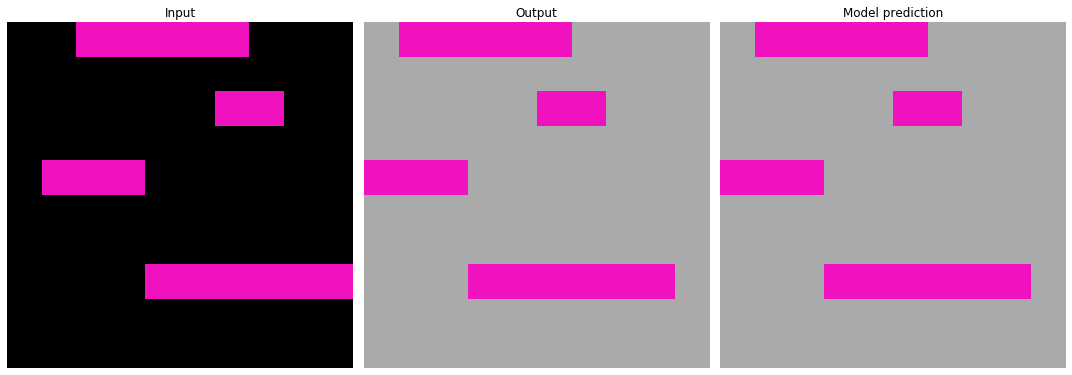

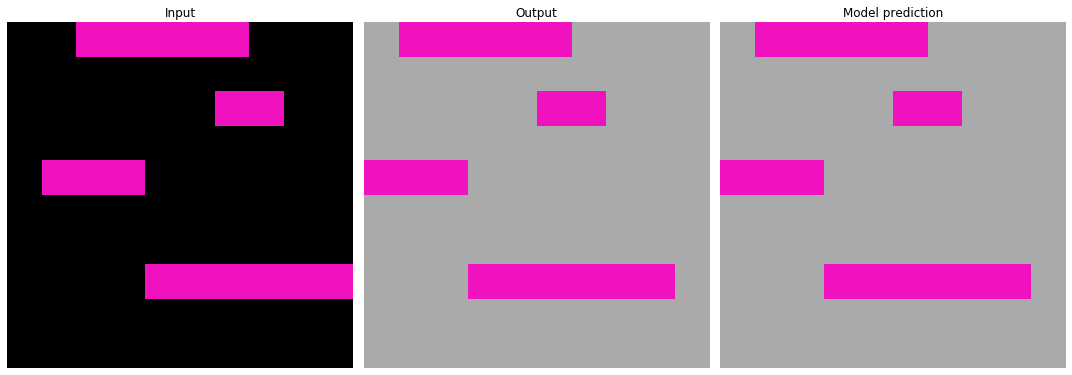

310f3251
358ba94e
137f0df0


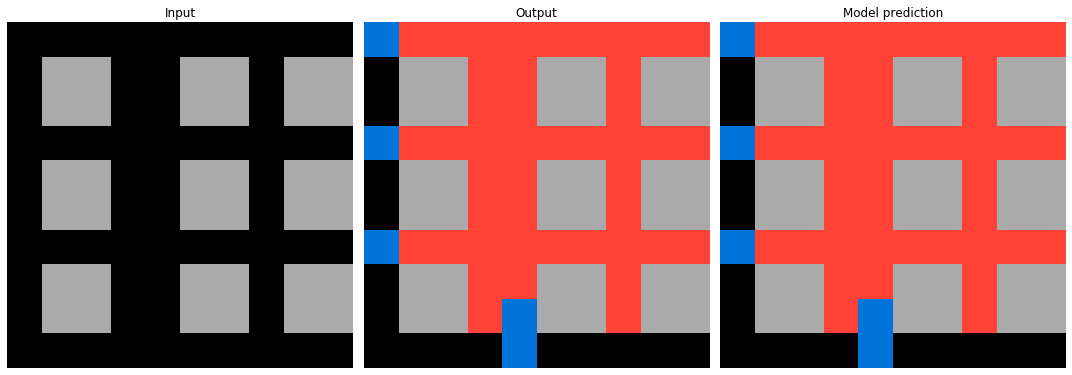

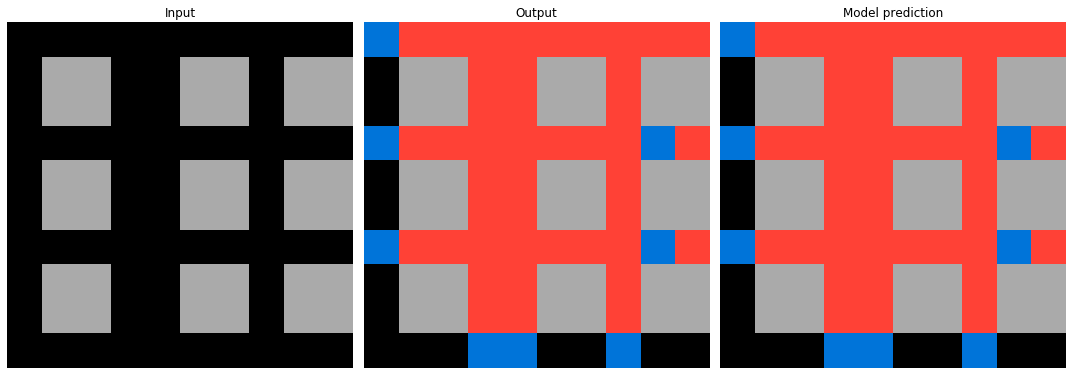

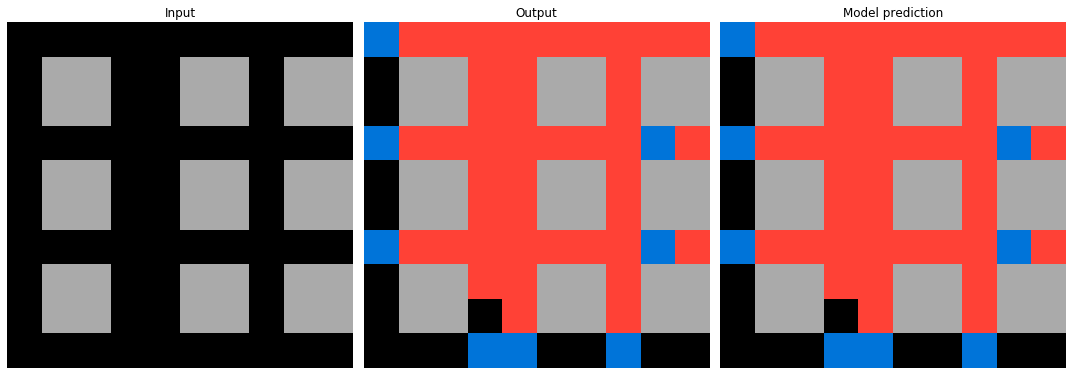

0becf7df


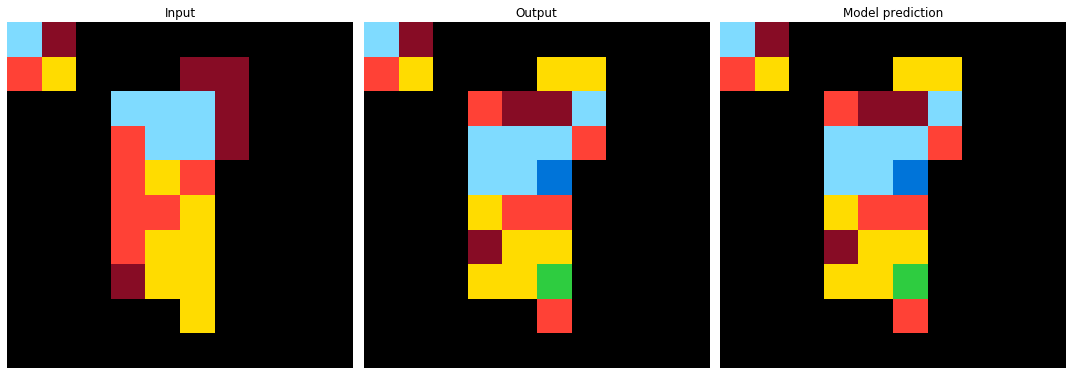

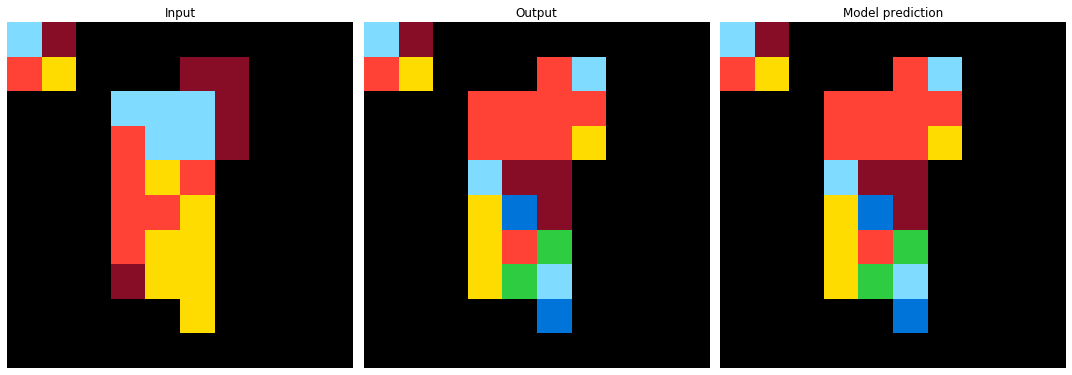

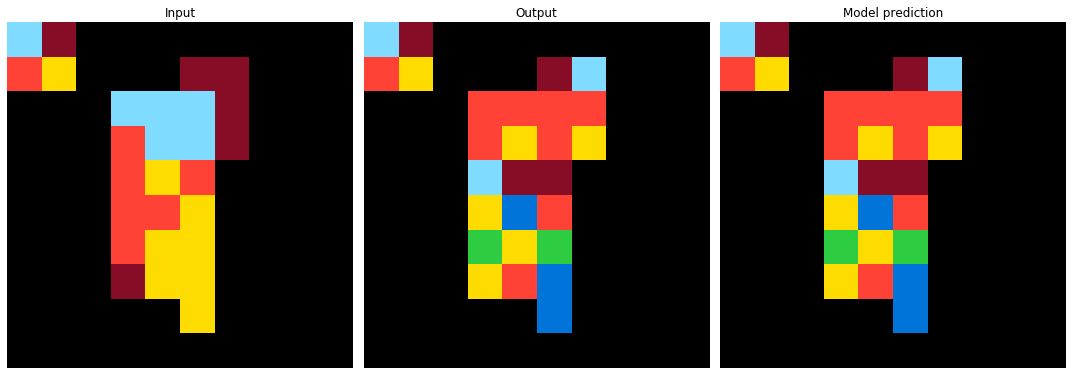

3ee1011a
17b80ad2


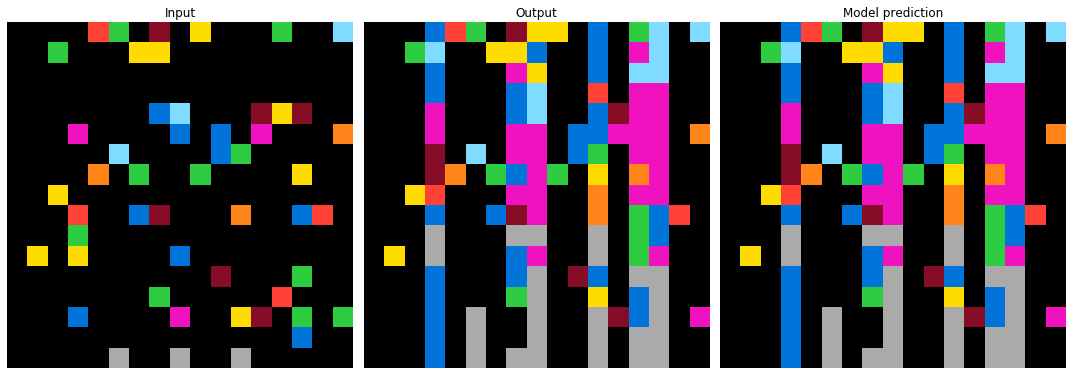

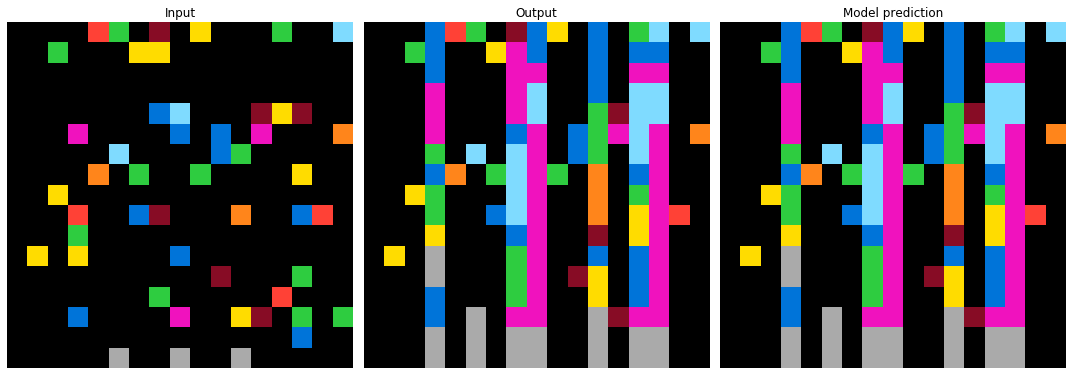

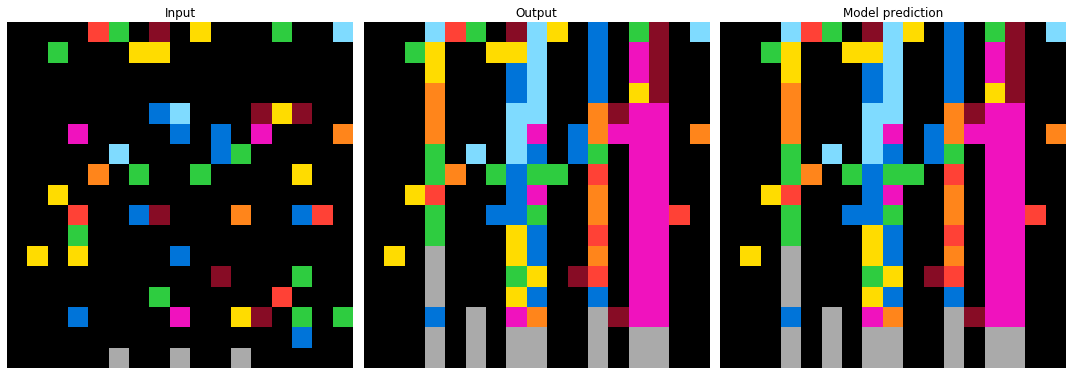

18419cfa


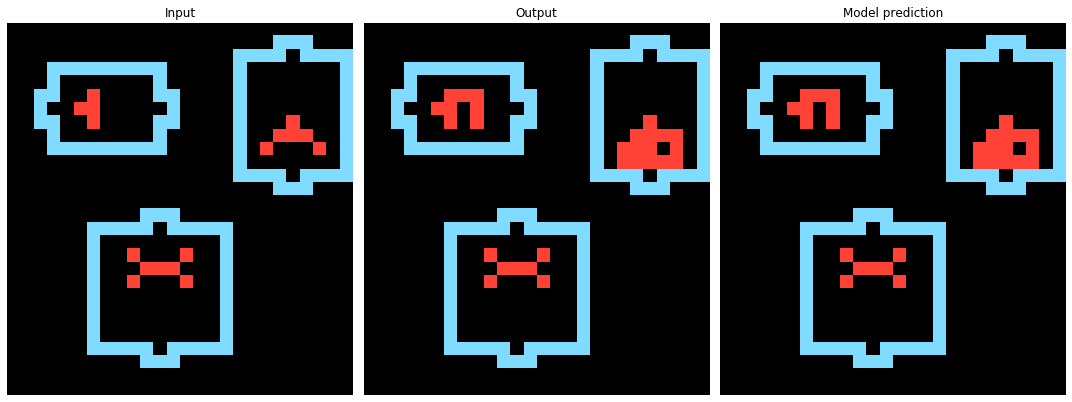

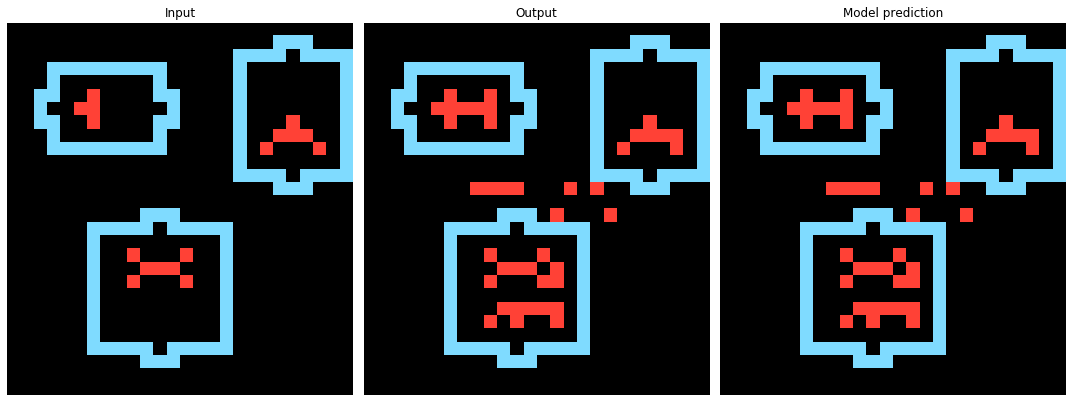

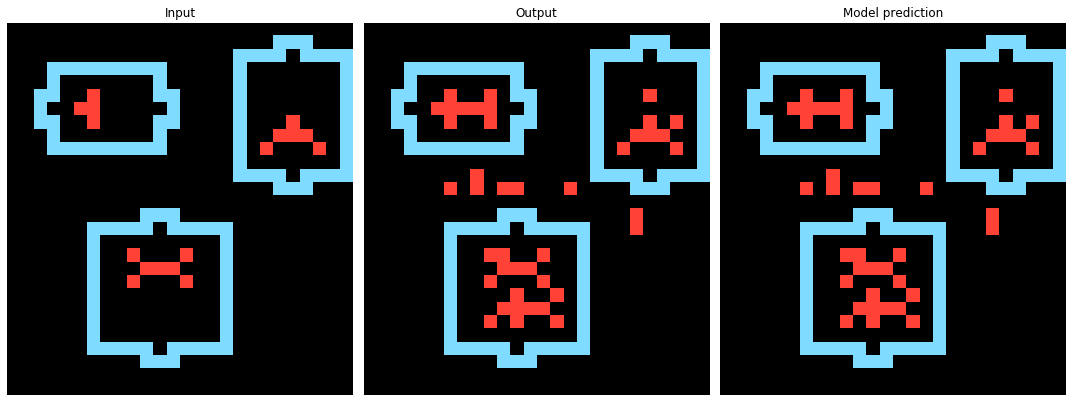

070dd51e


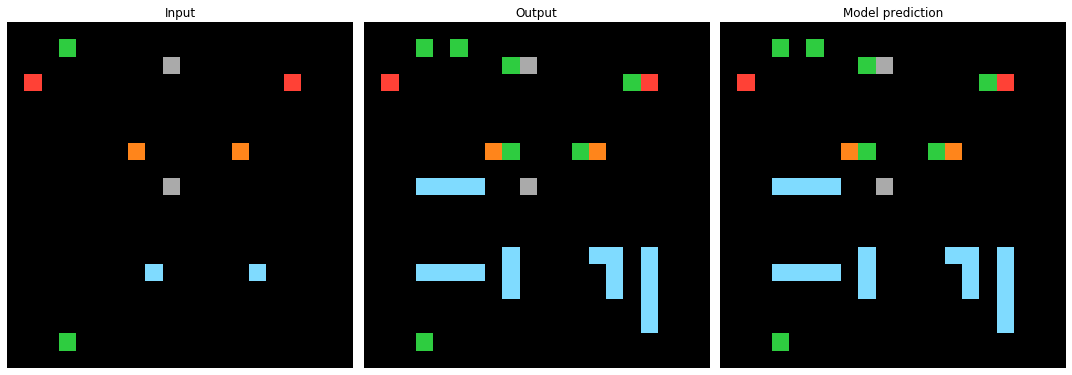

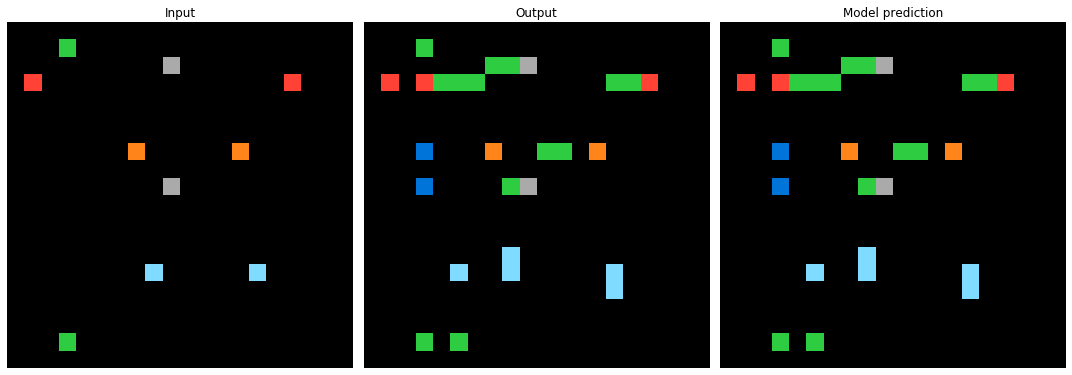

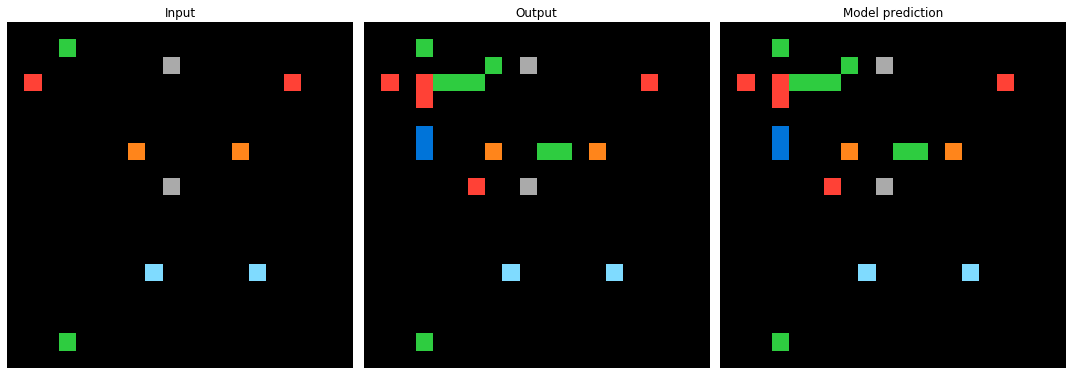

1da012fc


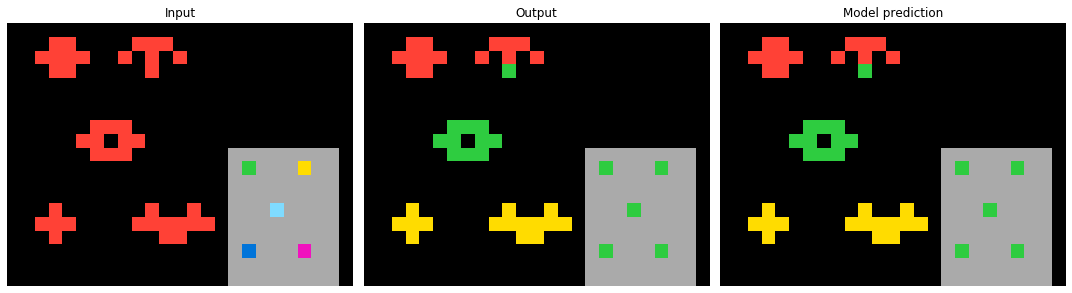

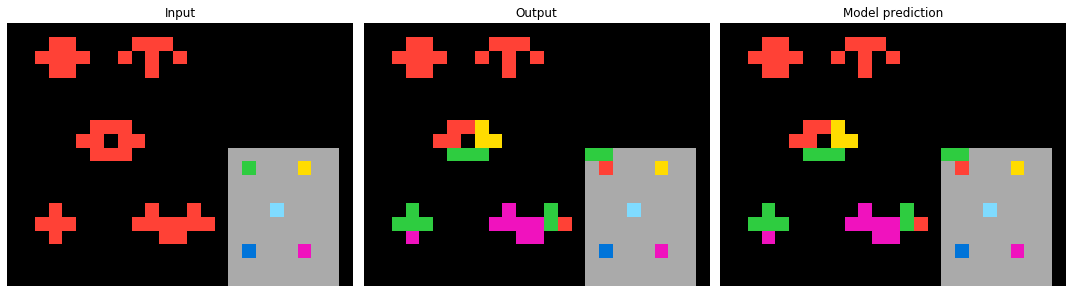

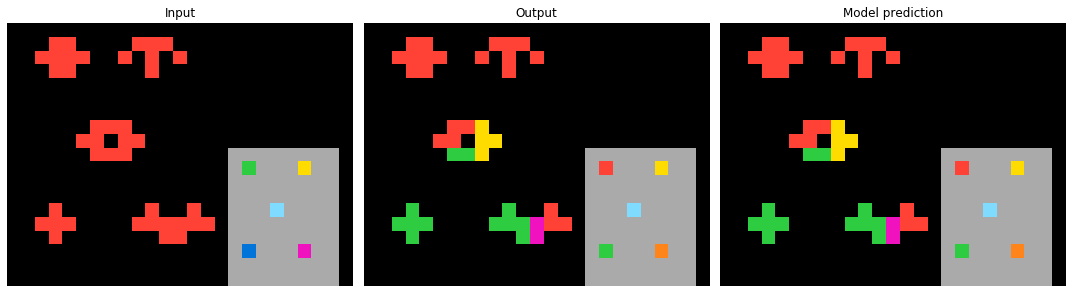

09c534e7


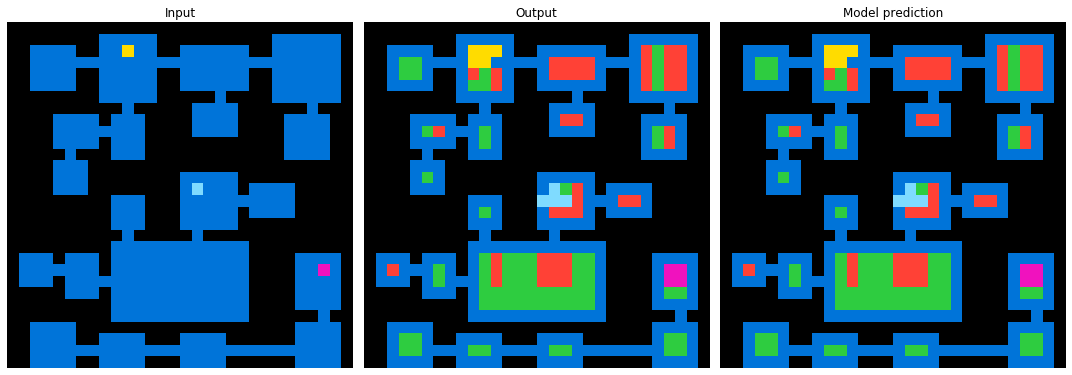

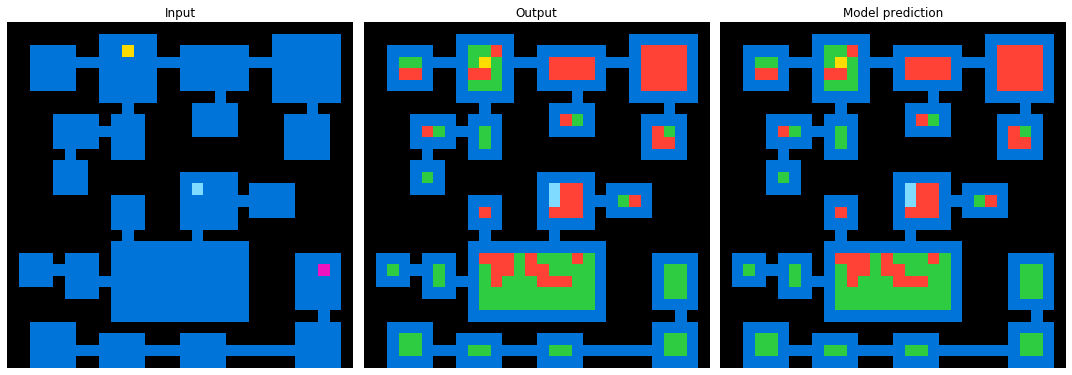

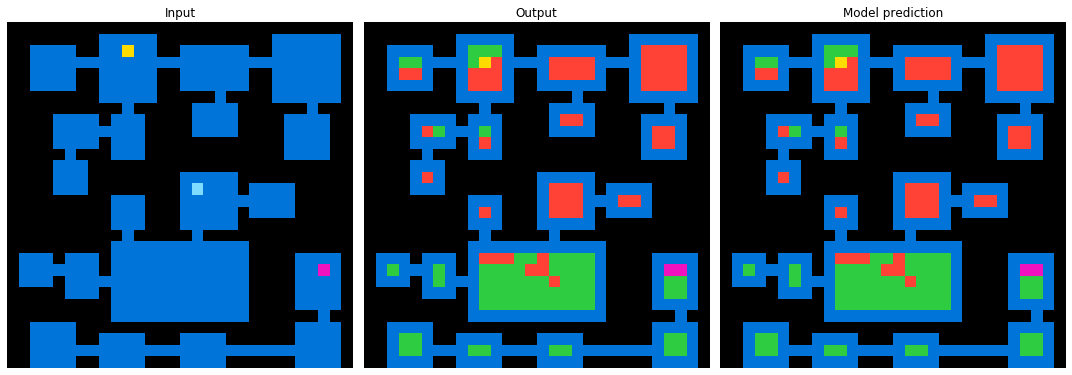

1d0a4b61


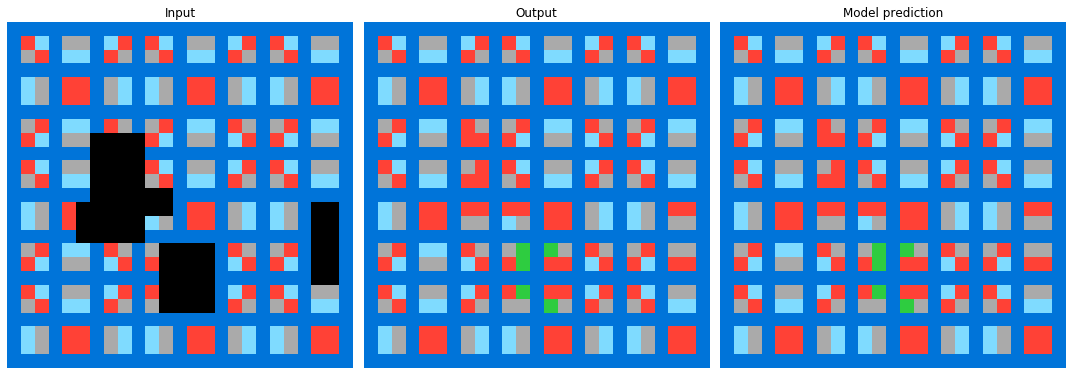

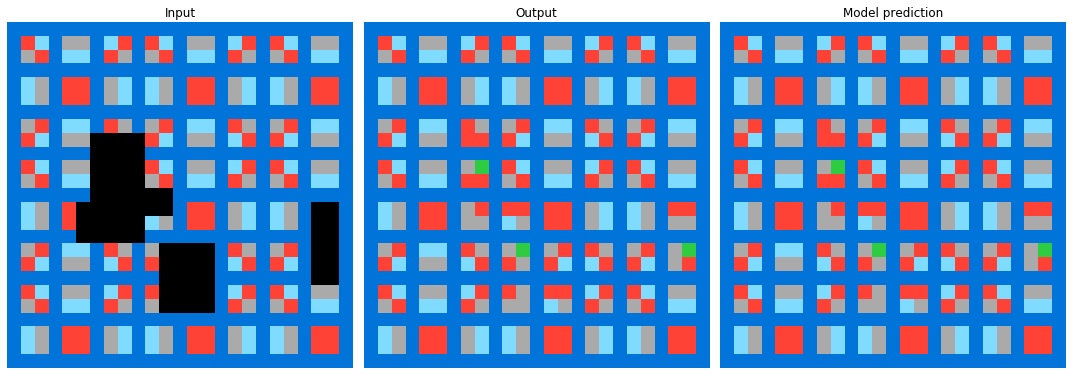

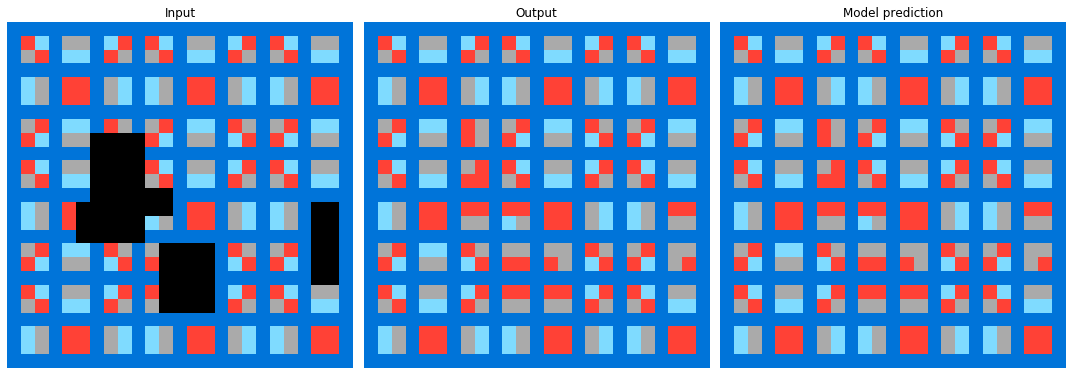

351d6448
1acc24af


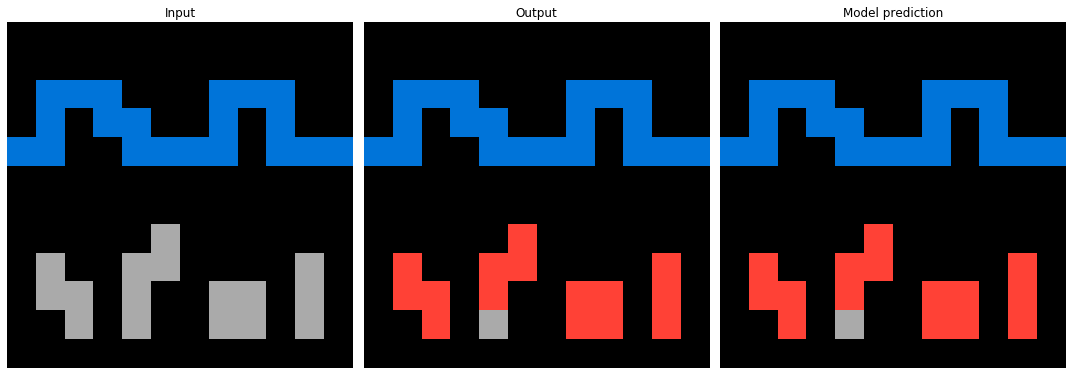

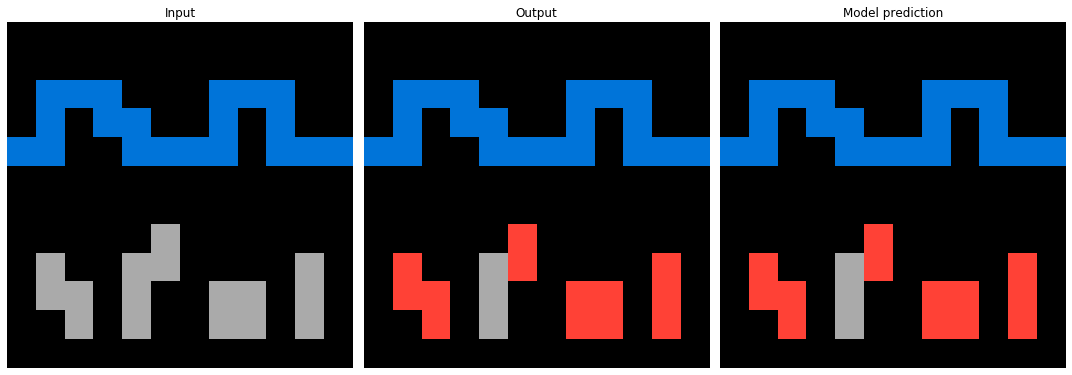

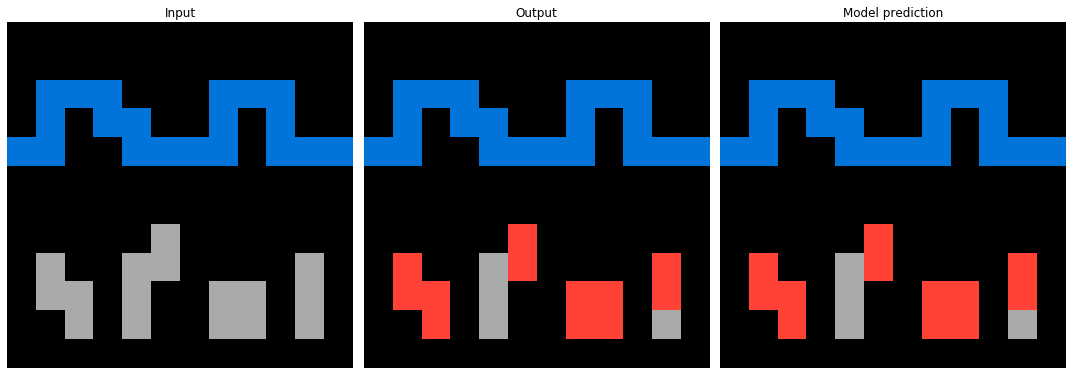

14754a24


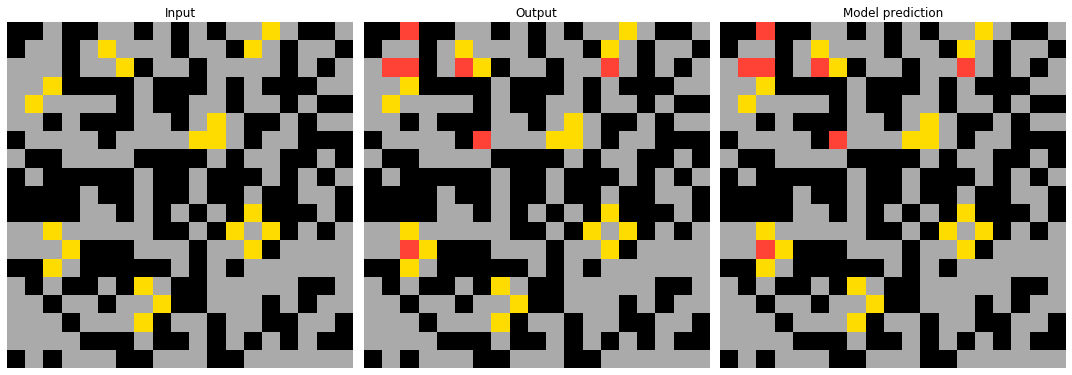

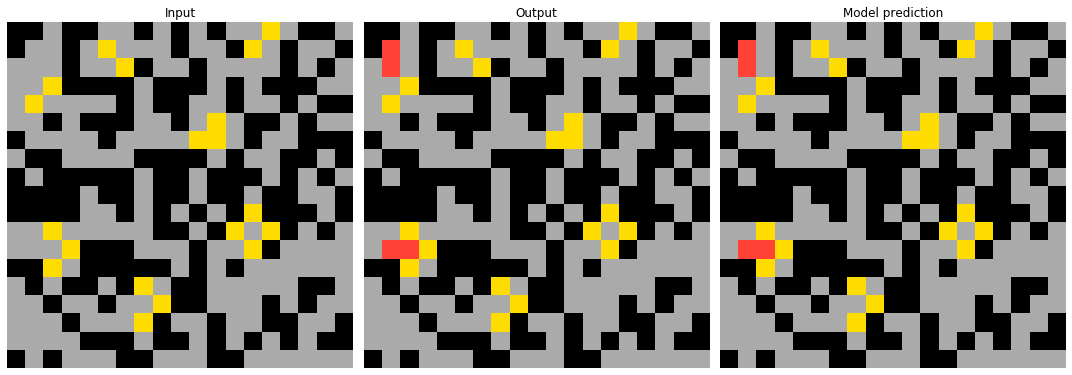

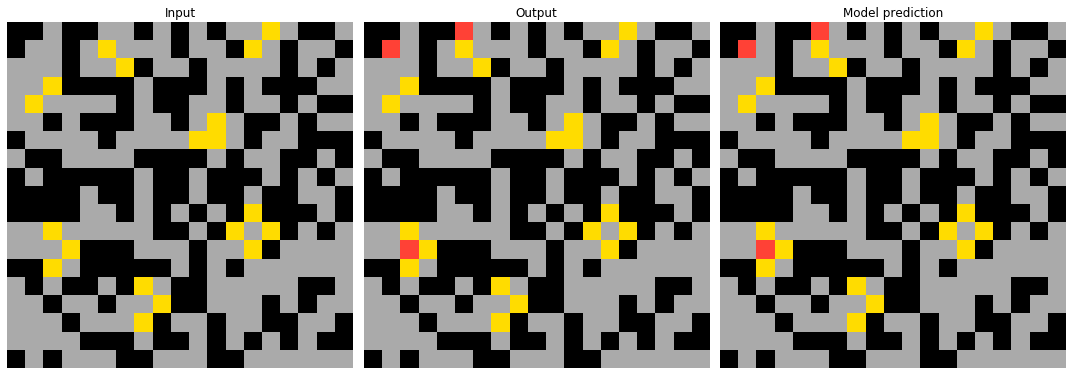

00dbd492


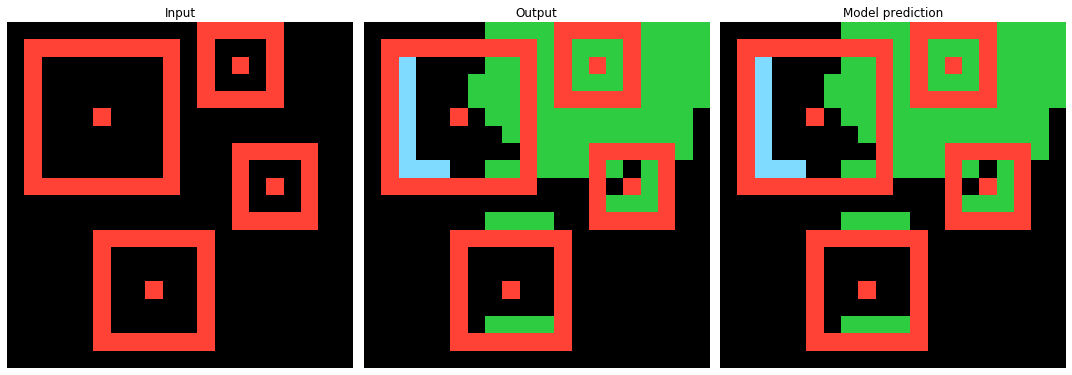

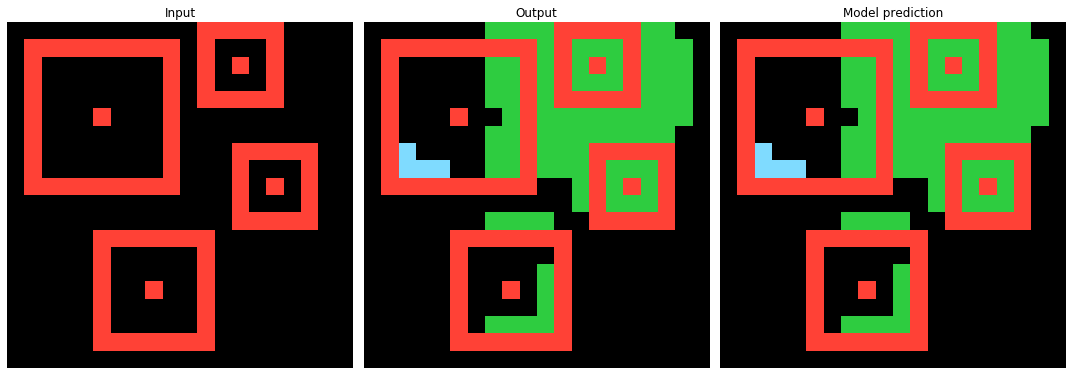

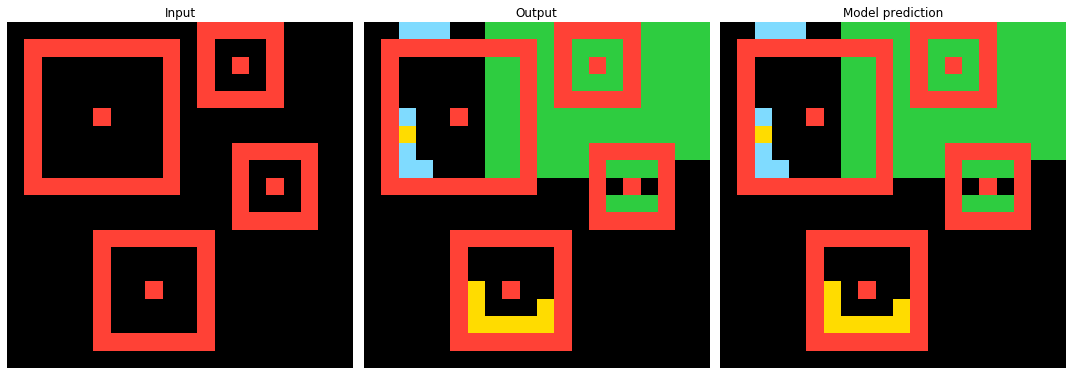

281123b4
12eac192


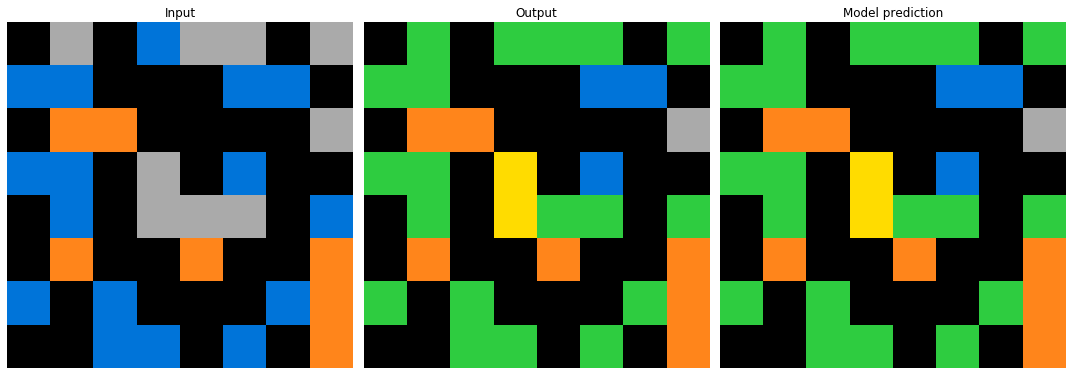

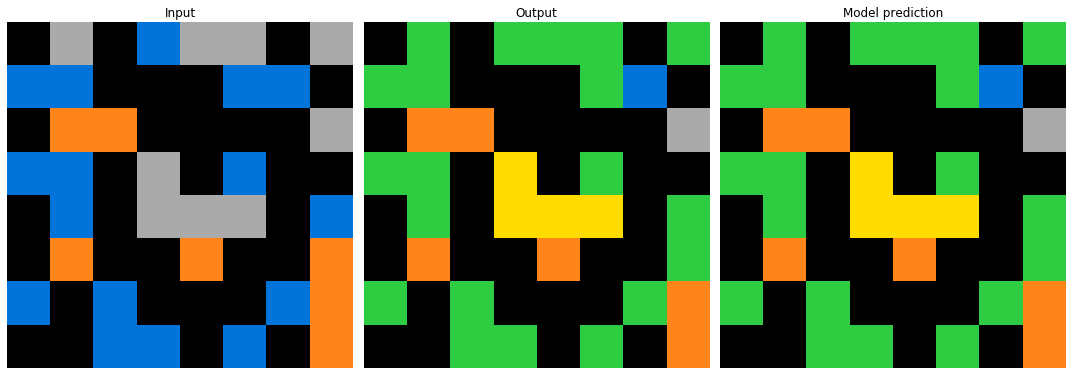

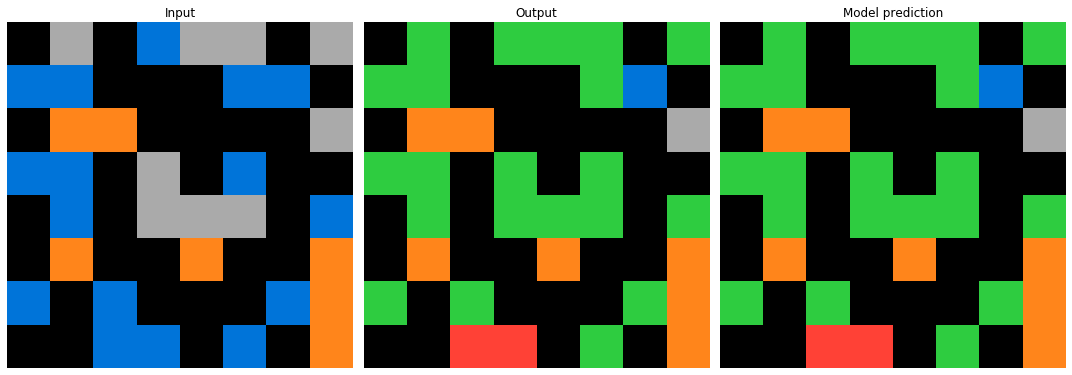

0934a4d8
1c02dbbe


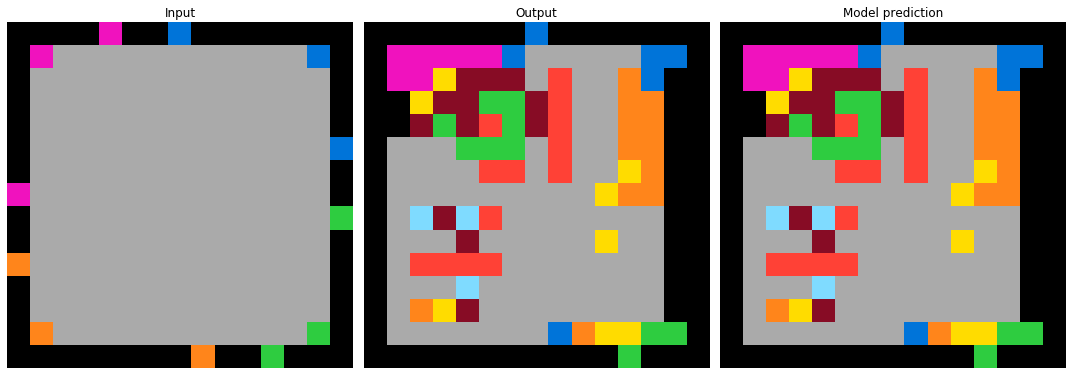

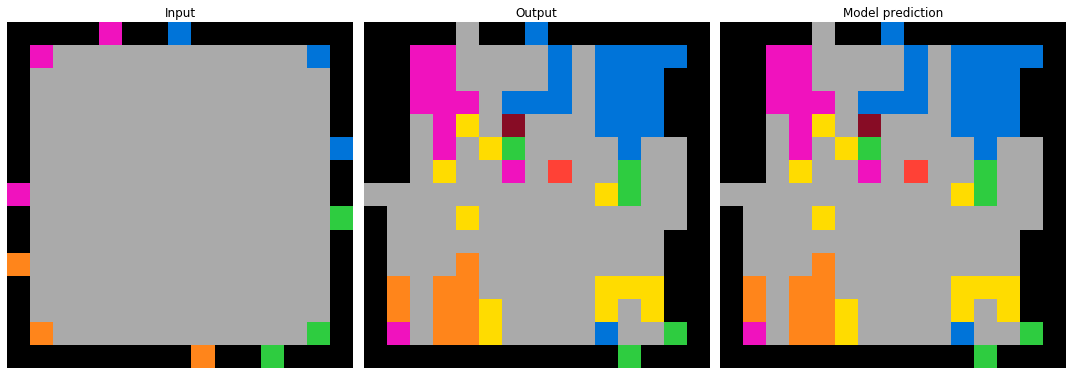

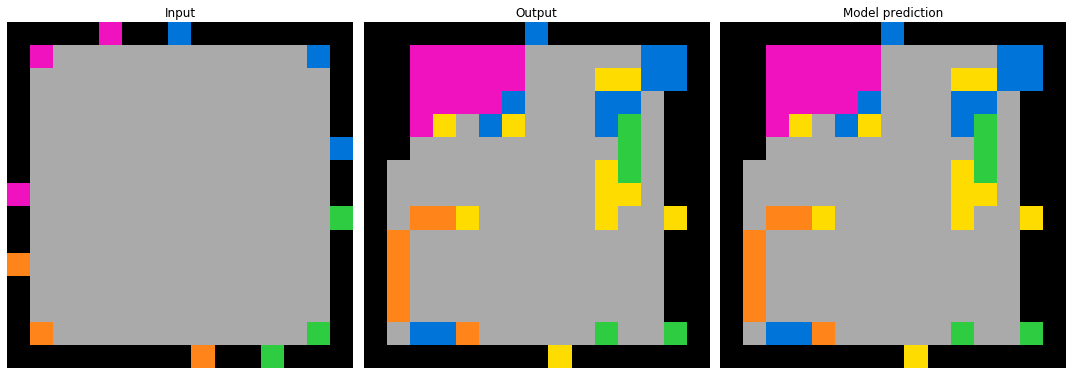

2a5f8217


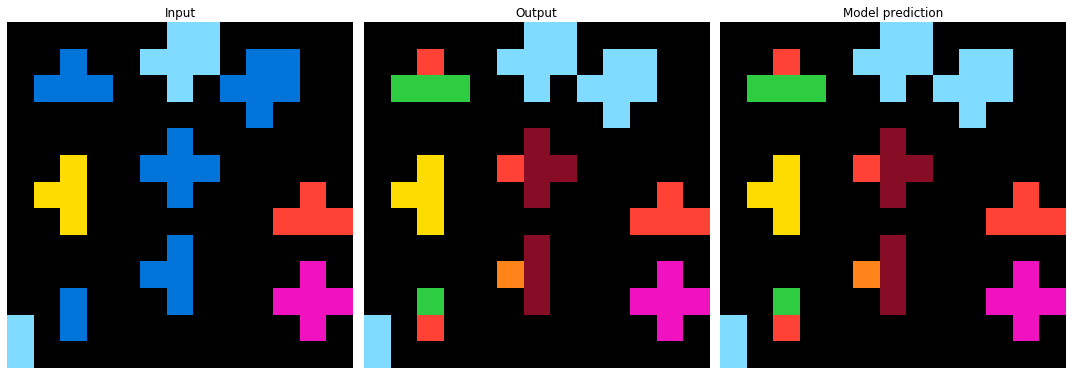

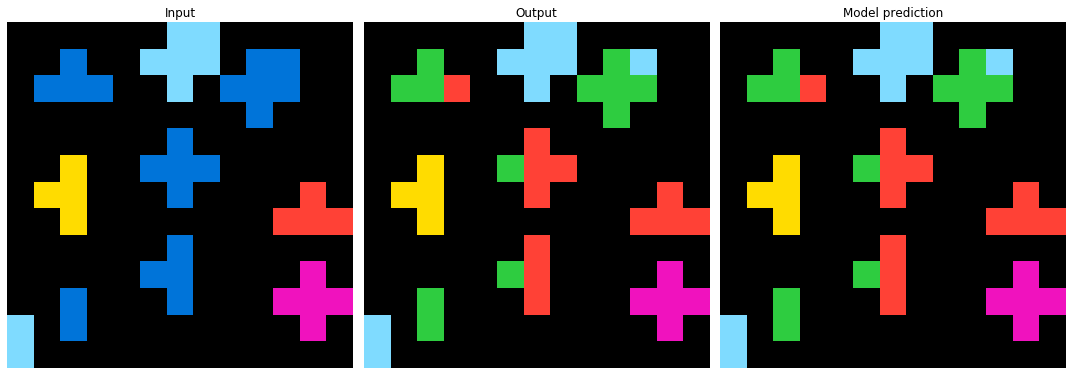

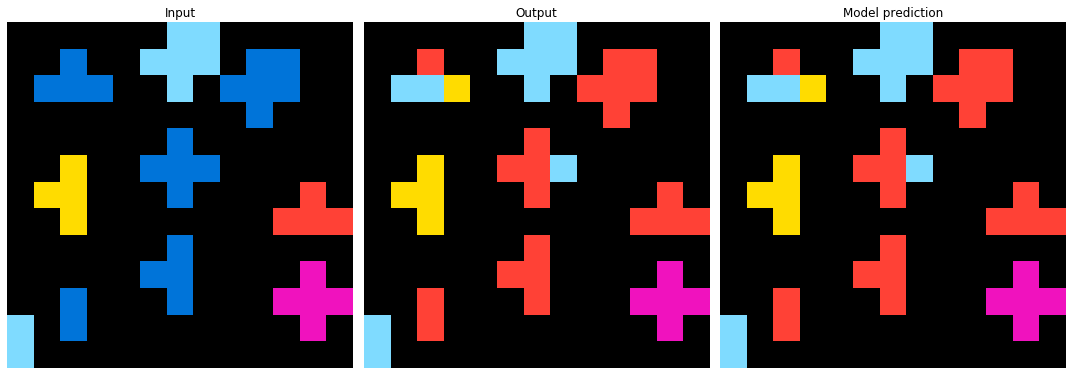

1e97544e


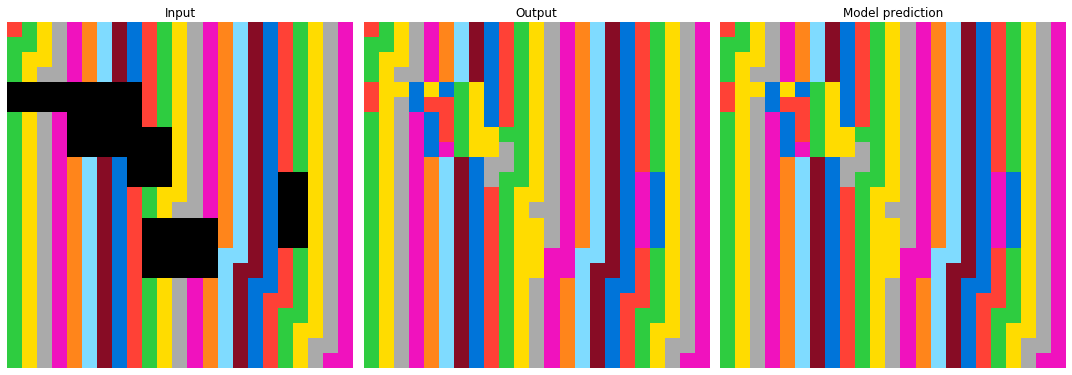

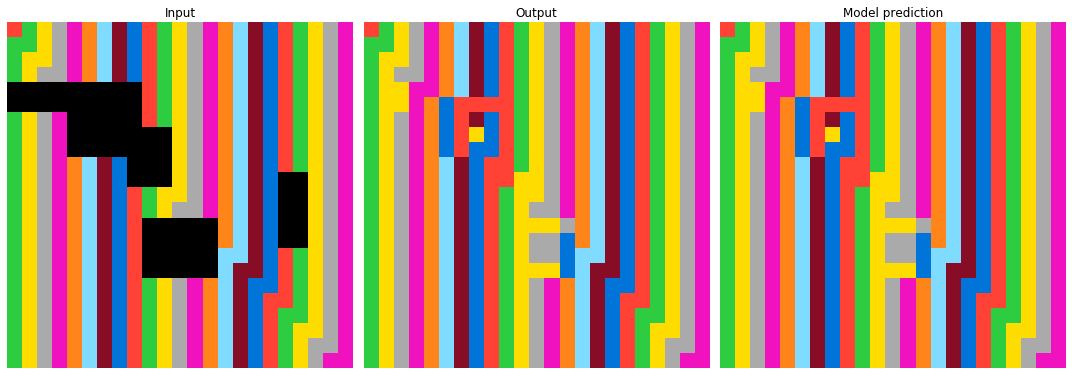

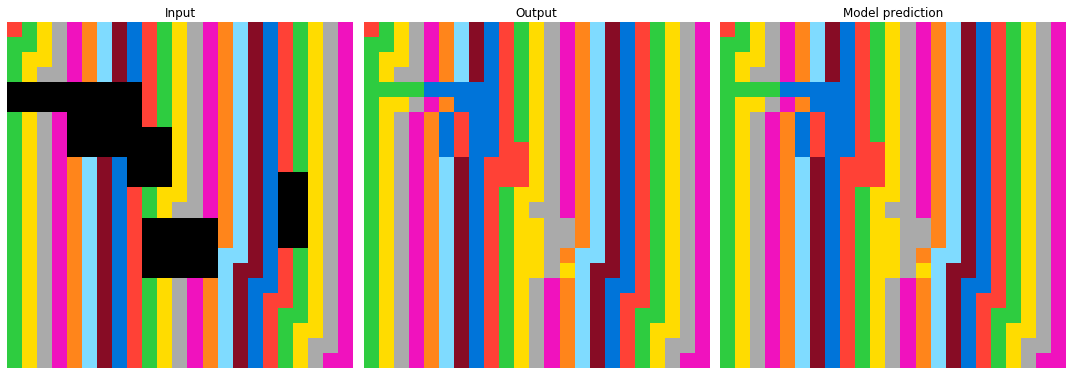

0f63c0b9


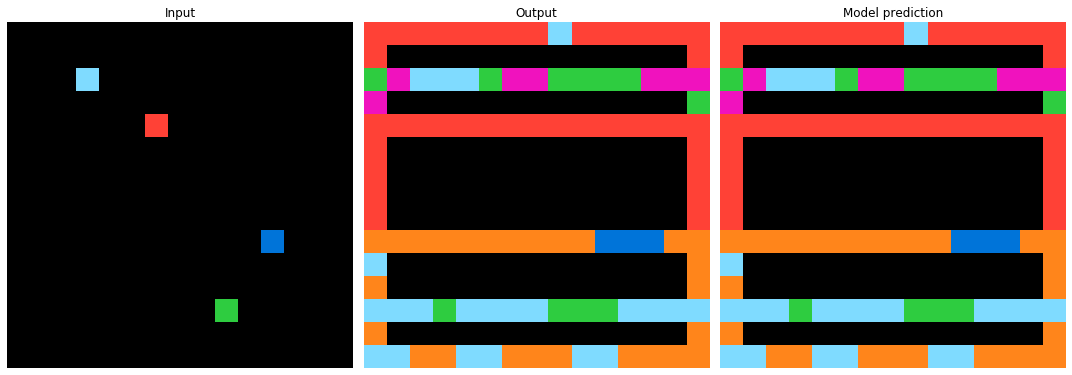

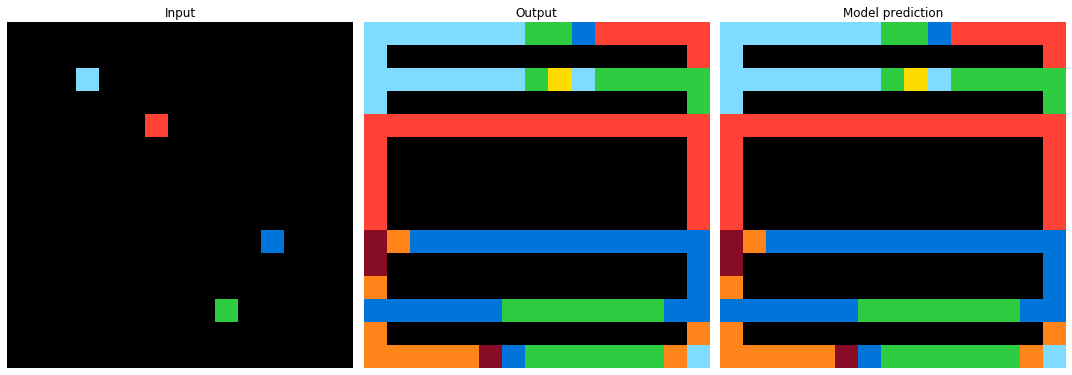

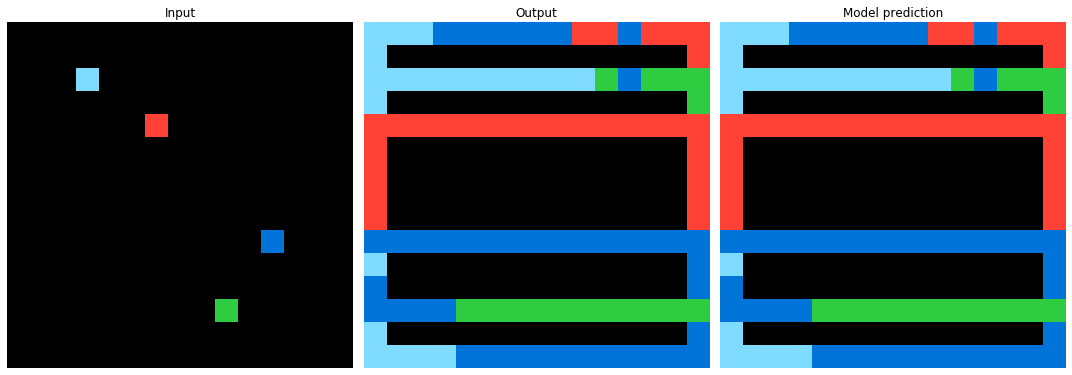

103eff5b


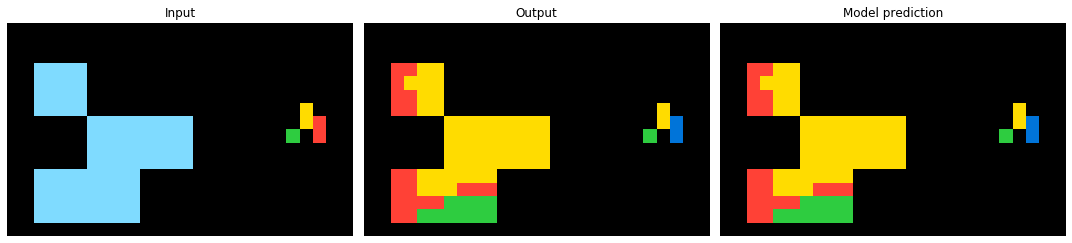

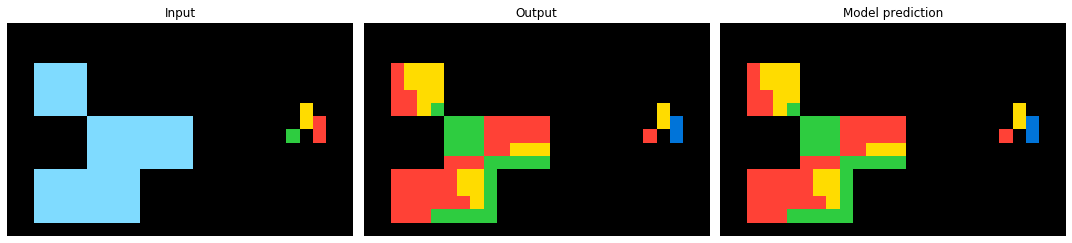

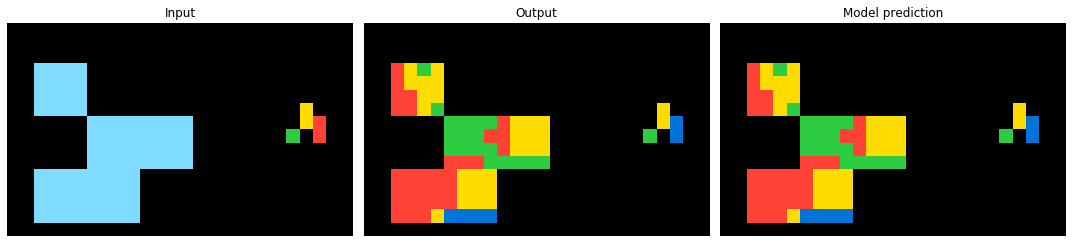

2b01abd0


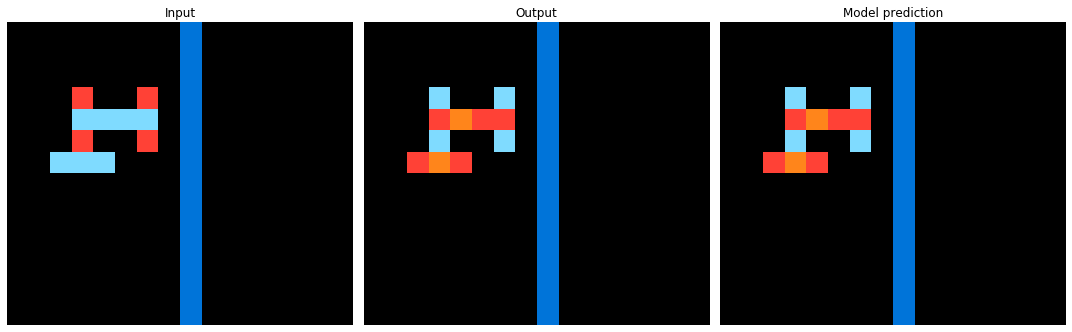

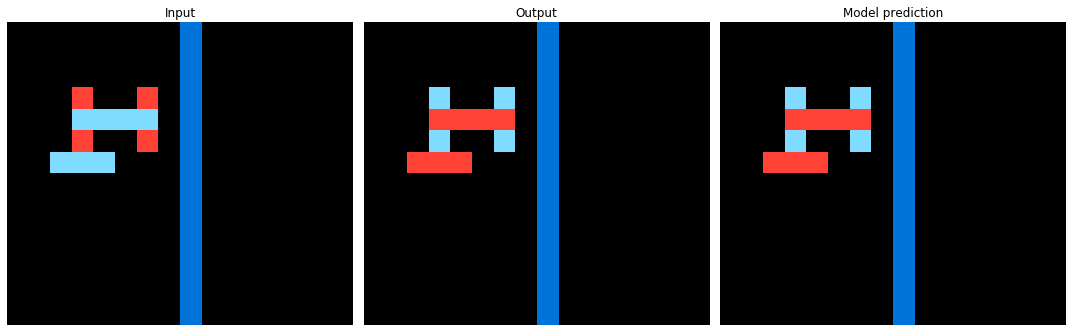

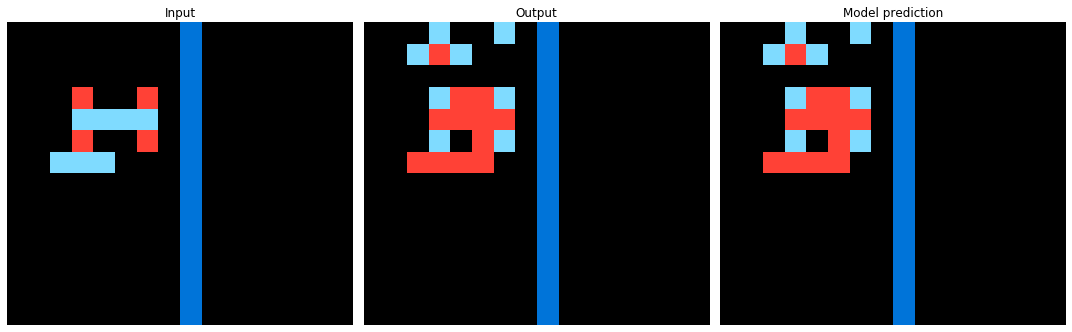

12997ef3


In [0]:
def inp_oup_dim_same(task_json):
    return all([ len(pair["input"]) == len(pair["output"]) and len(pair["input"][0]) == len(pair["output"][0])
                for pair in task_json['train']])
    

solved_task = 0
total_task = 0
task_ids = []
task_preds = []
for task_path in test_path.glob("*.json"):
    task_json = json.load(open(task_path))
    tk_id = str(task_path).split("/")[-1].split(".")[0]
    print(tk_id)
    if(inp_oup_dim_same(task_json)):
        a_size = get_a_size(task_json)
        bl_cols = get_bl_cols(task_json)
        
        isflip = False
        X1,Y1 = gettaskxy(task_json,True,1,bl_cols,isflip)
        X3,Y3 = gettaskxy(task_json,True,3,bl_cols,isflip)
        X5,Y5 = gettaskxy(task_json,True,5,bl_cols,isflip)
        
        model_1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100).fit(X1, Y1)
        model_3 = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100).fit(X3, Y3)
        model_5 = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100).fit(X5, Y5)
        
        pred_map_1 = submit_predict(task_json,model_1,1)
        pred_map_3 = submit_predict(task_json,model_3,3)
        pred_map_5 = submit_predict(task_json,model_5,5)
        
        for tks,str_pred in combine_preds(tk_id,pred_map_1,pred_map_3,pred_map_5):
            task_ids.append(tks)
            task_preds.append(str_pred)
            #print(tks,str_pred)
        solved_task+=1
        #break
    else:
        pred_map_1 = dumb_predict(task_json)
        pred_map_3 = dumb_predict(task_json)
        pred_map_5 = dumb_predict(task_json)
        
        for tks,str_pred in combine_preds(tk_id,pred_map_1,pred_map_3,pred_map_5):
            task_ids.append(tks)
            task_preds.append(str_pred)
            #print(tks,str_pred)
        
    total_task+=1

In [0]:
sub_df = pd.DataFrame({"output_id":task_ids,'output':task_preds})

In [0]:


sub_df.to_csv("submission.csv", index=None)

